In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import torch
print(torch.cuda.device_count())   # should be 1 now
print(torch.cuda.get_device_name(0))  # GPU 8 will appear as cuda:0

import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of visible GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")



1
NVIDIA L40S
CUDA available: True
Number of visible GPUs: 1
Device 0: NVIDIA L40S


In [2]:
import cv2
import numpy as np
import random
import torch
import gc
import os
import pandas as pd
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import json
import time
from datetime import datetime
from scipy import stats

class ImagePreprocessor:
    
    def __init__(self, square_size=3052, target_size=(1024, 1024)):
        self.square_size = square_size
        self.target_size = target_size
    
    def analyze_image_color_distribution(self, image):
        """
        Analyze color distribution of the original image and find the mode
        Returns the mode value and the noise color range (±20%)
        """
        # Convert to grayscale if colored image for analysis
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        # Calculate histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist.flatten()  # Convert to 1D array for easier processing
        
        # Find mode in the valid range (20-235) - CORRECTED RANGE
        # Create a copy of histogram for finding peaks
        hist_for_peaks = hist.copy()
        
        # Zero out values outside our desired range (20-235)
        hist_for_peaks[:21] = 0   # Remove values <= 20
        hist_for_peaks[235:] = 0  # Remove values >= 235
        
        # Find the mode (highest peak) in the valid range
        if np.sum(hist_for_peaks) > 0:
            mode_value = np.argmax(hist_for_peaks)
        else:
            # If no pixels in 20-235 range, find next best option
            # Look for highest peak outside extreme values (0, 255)
            hist_fallback = hist.copy()
            hist_fallback[0] = 0
            hist_fallback[255] = 0
            
            if np.sum(hist_fallback) > 0:
                mode_value = np.argmax(hist_fallback)
            else:
                # Final fallback
                mode_value = 128
        
        # Additional check: if mode is still outside 20-235, find next peak
        if mode_value <= 20 or mode_value >= 235:
            # Find multiple peaks and select the best one in range
            hist_copy = hist.copy()
            hist_copy[mode_value] = 0  # Remove current peak
            
            # Look for next highest peak in valid range
            hist_copy[:21] = 0   # Remove <= 20
            hist_copy[235:] = 0  # Remove >= 235
            
            if np.sum(hist_copy) > 0:
                next_mode = np.argmax(hist_copy)
                mode_value = next_mode
            else:
                mode_value = 128
        
        # Calculate ±20% range, ensuring it stays within [0, 255]
        range_offset = max(int(mode_value * 0.2), 15)  # Minimum range of 15
        min_noise_color = max(0, mode_value - range_offset)
        max_noise_color = min(255, mode_value + range_offset)
        
        # Ensure minimum range width of 30 pixels
        if max_noise_color - min_noise_color < 30:
            center = (min_noise_color + max_noise_color) // 2
            min_noise_color = max(0, center - 15)
            max_noise_color = min(255, center + 15)
        
        return mode_value, (min_noise_color, max_noise_color), hist
    
    def pad_to_square_and_resize(self, image_path, analyze_colors=True):
        """
        Load image, analyze color distribution, then pad and resize
        Returns processed image and color analysis results
        """
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Cannot load image: {image_path}")
        
        # Analyze original image color distribution BEFORE padding
        color_analysis = None
        if analyze_colors:
            mode_value, noise_range, hist = self.analyze_image_color_distribution(image)
            color_analysis = {
                'mode_value': mode_value,
                'noise_range': noise_range,
                'histogram': hist
            }
        
        h, w = image.shape[:2]
        
        # Determine the size of square needed (larger of image dimensions or default square_size)
        max_dim = max(h, w, self.square_size)
        
        # Step 1: Pad to square with black padding (using the larger dimension)
        pad_h = max_dim - h
        pad_w = max_dim - w
        
        top = pad_h // 2
        bottom = pad_h - top
        left = pad_w // 2
        right = pad_w - left
        
        # Black padding
        if len(image.shape) == 3:
            padded = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                      cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            padded = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                      cv2.BORDER_CONSTANT, value=0)
        
        # Step 2: Resize to target size (1024x1024)
        resized = cv2.resize(padded, self.target_size, interpolation=cv2.INTER_LANCZOS4)
        
        return resized, color_analysis

class NoiseInjector:
    
    def __init__(self):
        pass
    
    def generate_diagonal_noise_pattern(self, color_analysis, dot_size, pattern_type='diagonal'):
        """
        Generate diagonal or anti-diagonal noise pattern
        pattern_type: 'diagonal' or 'anti_diagonal'
        Returns a dot_size x dot_size array with diagonal pattern
        """
        if color_analysis is None:
            # Fallback to default range if analysis failed
            min_color, max_color = 20, 235
            mode_value = 128
        else:
            min_color, max_color = color_analysis['noise_range']
            mode_value = color_analysis['mode_value']
        
        # Create noise pattern filled with zeros initially
        noise_pattern = np.zeros((dot_size, dot_size), dtype=np.uint8)
        
        # Generate values for the diagonal based on mode and range
        # Create values that vary within the noise range
        diagonal_values = []
        for i in range(dot_size):
            # Generate a value within the noise range for each diagonal position
            if i == 0:
                # First value can be closer to one end of the range
                value = random.randint(min_color, min_color + (max_color - min_color) // 3)
            elif i == dot_size - 1:
                # Last value can be closer to the other end
                value = random.randint(max_color - (max_color - min_color) // 3, max_color)
            else:
                # Middle values distributed across the range
                value = random.randint(min_color, max_color)
            diagonal_values.append(value)
        
        # Apply the pattern
        if pattern_type == 'diagonal':
            # Fill main diagonal (top-left to bottom-right)
            for i in range(dot_size):
                noise_pattern[i, i] = diagonal_values[i]
        elif pattern_type == 'anti_diagonal':
            # Fill anti-diagonal (top-right to bottom-left)
            for i in range(dot_size):
                noise_pattern[i, dot_size - 1 - i] = diagonal_values[i]
        else:
            raise ValueError("pattern_type must be 'diagonal' or 'anti_diagonal'")
        
        return noise_pattern
    
    def add_adaptive_dot_noise(self, image, color_analysis, dot_size=2, num_dots=1, pattern_type='diagonal'):
        """
        Add diagonal or anti-diagonal noise dots using adaptive color range
        pattern_type: 'diagonal' or 'anti_diagonal'
        Returns the image with noise and the noise patterns used
        """
        image_with_noise = image.copy()
        h, w = image.shape[:2]
        
        # Conservative approach: use center 70% region for dot placement
        margin_x, margin_y = int(0.15 * w), int(0.15 * h)
        x_min, y_min = margin_x, margin_y
        x_max, y_max = w - margin_x - dot_size, h - margin_y - dot_size
        
        all_noise_patterns = []
        
        for _ in range(num_dots):
            # Random position within anatomical region
            x = random.randint(x_min, x_max)
            y = random.randint(y_min, y_max)
            
            # Generate diagonal or anti-diagonal noise pattern
            noise_pattern = self.generate_diagonal_noise_pattern(
                color_analysis, dot_size, pattern_type
            )
            all_noise_patterns.append(noise_pattern)
            
            # Apply the noise pattern to the image
            if len(image.shape) == 3:
                # For colored images, use the noise pattern in all channels
                for i in range(dot_size):
                    for j in range(dot_size):
                        if noise_pattern[i, j] > 0:  # Only apply non-zero values
                            color_val = noise_pattern[i, j]
                            image_with_noise[y+i:y+i+1, x+j:x+j+1] = [color_val, color_val, color_val]
            else:
                # For grayscale images, directly apply the noise pattern
                for i in range(dot_size):
                    for j in range(dot_size):
                        if noise_pattern[i, j] > 0:  # Only apply non-zero values
                            image_with_noise[y+i, x+j] = noise_pattern[i, j]
        
        return image_with_noise, all_noise_patterns

class EmbeddingExtractor:
    
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Clear GPU memory before loading models
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Load models with memory management
        self.load_raddino_model()
        
        # Clear memory before loading second model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        self.load_dinov3_model()
        
    def load_raddino_model(self):
        """Load RadDiNo model from HuggingFace"""
        try:
            print("Loading RadDiNo model...")
            self.raddino_processor = AutoImageProcessor.from_pretrained("microsoft/rad-dino")
            self.raddino_model = AutoModel.from_pretrained("microsoft/rad-dino").to(self.device)
            self.raddino_model.eval()
            print("RadDiNo model loaded successfully")
        except Exception as e:
            print(f"Error loading RadDiNo model: {e}")
            self.raddino_model = None
            self.raddino_processor = None
    
    def load_dinov3_model(self):
        try:
            print("Loading DINOv3 model...")
            self.dinov3_processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vit7b16-pretrain-lvd1689m")
            self.dinov3_model = AutoModel.from_pretrained("facebook/dinov3-vit7b16-pretrain-lvd1689m").to(self.device)
            self.dinov3_model.eval()
            print("DINOv3 model loaded successfully")
        except Exception as e:
            print(f"Error loading DINOv3 model: {e}")
            self.dinov3_model = None
            self.dinov3_processor = None
            
    def _to_pil(self, image):
        # numpy BGR/RGB or grayscale -> PIL RGB
        if image.ndim == 3:
            # OpenCV read path leads to BGR; convert to RGB
            return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            # grayscale
            return Image.fromarray(image).convert("RGB")
            
    def extract_raddino_batch(self, images):
        """images: list of numpy arrays (H,W[,3])"""
        if self.raddino_model is None:
            return None
        
        pil_list = [self._to_pil(im) for im in images]
        with torch.no_grad():
            inputs = self.raddino_processor(pil_list, return_tensors="pt").to(self.device)
            outputs = self.raddino_model(**inputs)
            if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
                embs = outputs.pooler_output
            else:
                # (B, T, D) -> mean over tokens
                embs = outputs.last_hidden_state.mean(dim=1)
            return embs.detach().cpu().numpy()
    
    def extract_dinov3_batch(self, images):
        if self.dinov3_model is None:
            return None
            
        pil_list = [self._to_pil(im) for im in images]
        with torch.no_grad():
            inputs = self.dinov3_processor(pil_list, return_tensors="pt").to(self.device)
            outputs = self.dinov3_model(**inputs)
            if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
                embs = outputs.pooler_output
            else:
                embs = outputs.last_hidden_state.mean(dim=1)
            return embs.detach().cpu().numpy()

class ProgressTracker:
    """Track progress and enable resuming from checkpoints"""
    
    def __init__(self, output_dir):
        self.output_dir = output_dir
        self.progress_file = os.path.join(output_dir, "progress.json")
        self.load_progress()
    
    def load_progress(self):
        """Load existing progress if available"""
        if os.path.exists(self.progress_file):
            with open(self.progress_file, 'r') as f:
                self.progress = json.load(f)
        else:
            self.progress = {
                "completed_tasks": [],
                "current_task": None,
                "last_updated": None
            }
    
    def save_progress(self):
        """Save current progress"""
        self.progress["last_updated"] = datetime.now().isoformat()
        os.makedirs(self.output_dir, exist_ok=True)
        with open(self.progress_file, 'w') as f:
            json.dump(self.progress, f, indent=2)
    
    def is_task_completed(self, task_id):
        """Check if a task is already completed"""
        return task_id in self.progress["completed_tasks"]
    
    def mark_task_completed(self, task_id):
        """Mark a task as completed"""
        if task_id not in self.progress["completed_tasks"]:
            self.progress["completed_tasks"].append(task_id)
        self.save_progress()
    
    def set_current_task(self, task_id):
        """Set the current task being processed"""
        self.progress["current_task"] = task_id
        self.save_progress()

class ImagePipeline:
    """Complete pipeline for image processing and embedding extraction with adaptive noise"""
    
    def __init__(self, root_path):
        self.root_path = root_path
        self.preprocessor = ImagePreprocessor()
        self.noise_injector = NoiseInjector()
        self.embedding_extractor = EmbeddingExtractor()
    
    def load_datasets(self, train_csv_path, test_csv_path):
        """Load train and test CSV files"""
        print("Loading datasets...")
        self.train_df = pd.read_csv(train_csv_path)
        self.test_df = pd.read_csv(test_csv_path)
        
        print(f"Train dataset shape: {self.train_df.shape}")
        print(f"Test dataset shape: {self.test_df.shape}")
        
        # Validate required columns
        required_cols = ['ImagePath', 'noise']
        for df_name, df in [('train', self.train_df), ('test', self.test_df)]:
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Missing columns in {df_name} dataset: {missing_cols}")
        
        return self.train_df, self.test_df
    
    def process_single_image(self, image_path, add_noise=False, dot_size=2, pattern_type='diagonal'):
        """Process single image: analyze colors, resize and optionally add diagonal/anti-diagonal noise"""
        # Accept absolute or relative paths
        full_image_path = image_path if os.path.isabs(image_path) else os.path.join(self.root_path, image_path)
        
        if not os.path.exists(full_image_path):
            raise FileNotFoundError(f"Image not found: {full_image_path}")
        
        # Step 1: Analyze colors, pad to 3052x3052 and resize to 1024x1024
        processed_image, color_analysis = self.preprocessor.pad_to_square_and_resize(
            full_image_path, analyze_colors=True
        )
        
        # Step 2: Add diagonal/anti-diagonal noise if required
        if add_noise and color_analysis is not None:
            processed_image, noise_patterns = self.noise_injector.add_adaptive_dot_noise(
                processed_image, color_analysis, dot_size=dot_size, num_dots=1, pattern_type=pattern_type
            )
        elif add_noise:
            # Fallback to diagonal pattern with default values if color analysis failed
            if len(processed_image.shape) == 3:
                # Create a simple diagonal pattern as fallback
                for i in range(dot_size):
                    processed_image[100+i, 100+i] = [255, 255, 255]
            else:
                for i in range(dot_size):
                    processed_image[100+i, 100+i] = 255
        
        return processed_image

    def extract_embeddings_for_dataset_batched(self, df, dataset_name, dot_size, batch_size=32, 
                                             save_intermediate=True, intermediate_save_frequency=100,
                                             pattern_type='diagonal'):
        """Extract embeddings for entire dataset using batched processing with intermediate saves"""
        print(f"\nExtracting embeddings for {dataset_name} (dot={dot_size}, pattern={pattern_type}) in batches of {batch_size}...")
        result_df = df.copy()
        rcol = f'raddino_embedding_dot{dot_size}'
        dcol = f'dinov3_embedding_dot{dot_size}'
        result_df[rcol] = None
        result_df[dcol] = None
        
        idxs = result_df.index.tolist()
        total_batches = len(range(0, len(idxs), batch_size))
        
        # Setup intermediate save path
        if save_intermediate:
            intermediate_dir = os.path.join(os.path.dirname(self.output_dir), "intermediate_saves")
            os.makedirs(intermediate_dir, exist_ok=True)
            intermediate_path = os.path.join(intermediate_dir, f"{dataset_name}_dot{dot_size}_{pattern_type}_intermediate.parquet")
        
        batch_count = 0
        for start in tqdm(range(0, len(idxs), batch_size), desc=f"Processing {dataset_name}"):
            batch_start_time = time.time()
            end = min(start + batch_size, len(idxs))
            batch_idx = idxs[start:end]
            
            # Load and process images
            load_start_time = time.time()
            imgs = []
            for i in batch_idx:
                row = result_df.loc[i]
                try:
                    add_noise = (row['noise'] == 1)
                    im = self.process_single_image(row['ImagePath'], add_noise=add_noise, 
                                                 dot_size=dot_size, pattern_type=pattern_type)
                except Exception as e:
                    print(f"Error processing {row['ImagePath']}: {e}")
                    im = None
                imgs.append(im)
            load_time = time.time() - load_start_time
            
            valid_mask = [im is not None for im in imgs]
            valid_imgs = [im for im, ok in zip(imgs, valid_mask) if ok]
            if len(valid_imgs) == 0:
                for i, ok in zip(batch_idx, valid_mask):
                    if not ok:
                        result_df.at[i, rcol] = None
                        result_df.at[i, dcol] = None
                continue
            
            # Extract embeddings in batch
            embed_start_time = time.time()
            r_embs = self.embedding_extractor.extract_raddino_batch(valid_imgs)
            d_embs = self.embedding_extractor.extract_dinov3_batch(valid_imgs)
            embed_time = time.time() - embed_start_time
            
            # Store results back to dataframe
            store_start_time = time.time()
            valid_iter = iter(range(len(valid_imgs)))
            for i, ok in zip(batch_idx, valid_mask):
                if ok:
                    j = next(valid_iter)
                    if r_embs is not None and len(r_embs) > j:
                        result_df.at[i, rcol] = r_embs[j].tolist()
                    else:
                        result_df.at[i, rcol] = None
                        
                    if d_embs is not None and len(d_embs) > j:
                        result_df.at[i, dcol] = d_embs[j].tolist()
                    else:
                        result_df.at[i, dcol] = None
                else:
                    result_df.at[i, rcol] = None
                    result_df.at[i, dcol] = None
            store_time = time.time() - store_start_time
            
            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            batch_count += 1
            batch_total_time = time.time() - batch_start_time
            
            # Save intermediate results periodically
            if save_intermediate and (batch_count % intermediate_save_frequency == 0 or batch_count == total_batches):
                result_df.to_parquet(intermediate_path, index=False)
            
            # Print timing every 10 batches
            if batch_count % 10 == 0 or batch_count == total_batches:
                print(f"\nBatch {batch_count}/{total_batches}: "
                      f"Load={load_time:.2f}s, "
                      f"Embed={embed_time:.2f}s, "
                      f"Store={store_time:.2f}s, "
                      f"Total={batch_total_time:.2f}s, "
                      f"Images/sec={len(valid_imgs)/batch_total_time:.2f}")
                
                # Estimate remaining time
                if batch_count < total_batches:
                    avg_batch_time = batch_total_time
                    remaining_batches = total_batches - batch_count
                    estimated_remaining_time = remaining_batches * avg_batch_time / 60  # in minutes
                    print(f"Estimated remaining time: {estimated_remaining_time:.1f} minutes")
        
        return result_df
        
    def save_parquet_files(self, df, dataset_name, dot_size, output_dir="output", pattern_type='diagonal'):
        """Save separate parquet files for RadDiNo and DINOv3 embeddings"""
        os.makedirs(output_dir, exist_ok=True)
        
        # Create separate dataframes for each model
        raddino_df = df[['AccessionNumber_anon', 'ImagePath', 'ViewPosition', 'CLAHE', 'Cardiomegaly', 'noise', f'raddino_embedding_dot{dot_size}']].copy()
        dinov3_df = df[['AccessionNumber_anon', 'ImagePath', 'ViewPosition', 'CLAHE', 'Cardiomegaly', 'noise', f'dinov3_embedding_dot{dot_size}']].copy()
        
        # Save parquet files with pattern type in filename
        raddino_filename = f"{output_dir}/raddino-{dataset_name}-dot{dot_size}-{pattern_type}.parquet"
        dinov3_filename = f"{output_dir}/dinov3-{dataset_name}-dot{dot_size}-{pattern_type}.parquet"
        
        raddino_df.to_parquet(raddino_filename, index=False)
        dinov3_df.to_parquet(dinov3_filename, index=False)
        
        print(f"Saved: {raddino_filename}")
        print(f"Saved: {dinov3_filename}")
        
        return raddino_filename, dinov3_filename
    
    def run_single_dot_size(self, train_csv_path, test_csv_path, dot_size, output_dir="output", 
                           batch_size=32, pattern_type='diagonal'):
        """Run pipeline for a single dot size with specified pattern type"""
        print(f"=" * 60)
        print(f"PROCESSING DOT SIZE: {dot_size}x{dot_size} with {pattern_type.upper()} pattern")
        print(f"=" * 60)
        
        # Initialize progress tracker
        self.output_dir = output_dir
        tracker = ProgressTracker(output_dir)
        
        # Load datasets
        train_df, test_df = self.load_datasets(train_csv_path, test_csv_path)
        
        # Define task IDs with pattern type
        train_task = f"train_dot{dot_size}_{pattern_type}"
        test_task = f"test_dot{dot_size}_{pattern_type}"
        
        # Process train dataset
        if not tracker.is_task_completed(train_task):
            print(f"\nProcessing train dataset for dot size {dot_size} with {pattern_type} pattern...")
            tracker.set_current_task(train_task)
            
            train_result = self.extract_embeddings_for_dataset_batched(
                train_df, "train", dot_size, batch_size=batch_size,
                save_intermediate=True, intermediate_save_frequency=50,
                pattern_type=pattern_type
            )
            
            self.save_parquet_files(train_result, "train", dot_size, output_dir, pattern_type)
            tracker.mark_task_completed(train_task)
            
            del train_result
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        else:
            print(f"Train dataset for dot size {dot_size} with {pattern_type} pattern already completed. Skipping...")
        
        # Process test dataset
        if not tracker.is_task_completed(test_task):
            print(f"\nProcessing test dataset for dot size {dot_size} with {pattern_type} pattern...")
            tracker.set_current_task(test_task)
            
            test_result = self.extract_embeddings_for_dataset_batched(
                test_df, "test", dot_size, batch_size=batch_size,
                save_intermediate=True, intermediate_save_frequency=50,
                pattern_type=pattern_type
            )
            
            self.save_parquet_files(test_result, "test", dot_size, output_dir, pattern_type)
            tracker.mark_task_completed(test_task)
            
            del test_result
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        else:
            print(f"Test dataset for dot size {dot_size} with {pattern_type} pattern already completed. Skipping...")
        
        print(f"\nCompleted processing for dot size {dot_size} with {pattern_type} pattern")
        return True


/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

ROOT_PATH = "/home/rmuthy2/central_data/datasets/internal/EmoryCXRv2/ORIGINAL_PNG"
TRAIN_CSV = "/home/rmuthy2/Line-noise/train_dataset.csv"
TEST_CSV  = "/home/rmuthy2/Line-noise/test_dataset.csv"
OUTPUT_DIR = "/home/rmuthy2/Line-noise/EmbeddingsOutput"

pipe = ImagePipeline(ROOT_PATH)
pipe.run_single_dot_size(TRAIN_CSV, TEST_CSV, dot_size=8, output_dir=OUTPUT_DIR, batch_size=12)


Using device: cuda
Loading RadDiNo model...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


RadDiNo model loaded successfully
Loading DINOv3 model...


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00, 112.67it/s]


DINOv3 model loaded successfully
PROCESSING DOT SIZE: 8x8 with DIAGONAL pattern
Loading datasets...
Train dataset shape: (109824, 6)
Test dataset shape: (27456, 6)

Processing train dataset for dot size 8 with diagonal pattern...

Extracting embeddings for train (dot=8, pattern=diagonal) in batches of 12...


Processing train:   0%|          | 10/9152 [00:33<8:28:28,  3.34s/it]


Batch 10/9152: Load=1.62s, Embed=1.56s, Store=0.00s, Total=3.36s, Images/sec=3.57
Estimated remaining time: 511.6 minutes


Processing train:   0%|          | 20/9152 [01:08<8:41:34,  3.43s/it]


Batch 20/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=3.35s, Images/sec=3.58
Estimated remaining time: 510.2 minutes


Processing train:   0%|          | 30/9152 [01:41<8:39:55,  3.42s/it]


Batch 30/9152: Load=1.85s, Embed=1.62s, Store=0.00s, Total=3.61s, Images/sec=3.32
Estimated remaining time: 549.3 minutes


Processing train:   0%|          | 40/9152 [02:16<8:41:19,  3.43s/it]


Batch 40/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=3.35s, Images/sec=3.59
Estimated remaining time: 508.1 minutes


Processing train:   1%|          | 50/9152 [02:51<9:06:50,  3.60s/it]


Batch 50/9152: Load=1.82s, Embed=1.61s, Store=0.00s, Total=3.58s, Images/sec=3.35
Estimated remaining time: 543.5 minutes


Processing train:   1%|          | 60/9152 [03:26<8:48:53,  3.49s/it]


Batch 60/9152: Load=1.74s, Embed=1.61s, Store=0.00s, Total=3.50s, Images/sec=3.43
Estimated remaining time: 530.4 minutes


Processing train:   1%|          | 70/9152 [04:01<8:50:15,  3.50s/it]


Batch 70/9152: Load=1.81s, Embed=1.63s, Store=0.00s, Total=3.59s, Images/sec=3.34
Estimated remaining time: 544.1 minutes


Processing train:   1%|          | 80/9152 [04:36<8:53:54,  3.53s/it]


Batch 80/9152: Load=1.81s, Embed=1.61s, Store=0.00s, Total=3.58s, Images/sec=3.36
Estimated remaining time: 540.7 minutes


Processing train:   1%|          | 90/9152 [05:12<9:01:44,  3.59s/it]


Batch 90/9152: Load=1.84s, Embed=1.62s, Store=0.00s, Total=3.63s, Images/sec=3.31
Estimated remaining time: 547.5 minutes


Processing train:   1%|          | 100/9152 [05:48<9:16:54,  3.69s/it]


Batch 100/9152: Load=1.80s, Embed=1.62s, Store=0.00s, Total=3.59s, Images/sec=3.34
Estimated remaining time: 541.3 minutes


Processing train:   1%|          | 109/9152 [06:20<9:02:41,  3.60s/it]


Batch 110/9152: Load=1.77s, Embed=1.61s, Store=0.00s, Total=3.55s, Images/sec=3.38
Estimated remaining time: 535.6 minutes


Processing train:   1%|▏         | 120/9152 [06:59<8:55:07,  3.55s/it]


Batch 120/9152: Load=1.71s, Embed=1.64s, Store=0.00s, Total=3.63s, Images/sec=3.31
Estimated remaining time: 546.0 minutes


Processing train:   1%|▏         | 130/9152 [07:33<8:49:00,  3.52s/it]


Batch 130/9152: Load=1.71s, Embed=1.59s, Store=0.00s, Total=3.57s, Images/sec=3.36
Estimated remaining time: 537.5 minutes


Processing train:   2%|▏         | 140/9152 [08:10<9:14:45,  3.69s/it]


Batch 140/9152: Load=1.67s, Embed=1.62s, Store=0.00s, Total=3.60s, Images/sec=3.34
Estimated remaining time: 540.0 minutes


Processing train:   2%|▏         | 150/9152 [08:45<9:18:02,  3.72s/it]


Batch 150/9152: Load=1.67s, Embed=1.60s, Store=0.00s, Total=3.52s, Images/sec=3.41
Estimated remaining time: 527.6 minutes


Processing train:   2%|▏         | 160/9152 [09:20<8:38:55,  3.46s/it]


Batch 160/9152: Load=1.61s, Embed=1.60s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 513.5 minutes


Processing train:   2%|▏         | 170/9152 [09:54<8:39:50,  3.47s/it]


Batch 170/9152: Load=1.61s, Embed=1.62s, Store=0.00s, Total=3.46s, Images/sec=3.47
Estimated remaining time: 517.3 minutes


Processing train:   2%|▏         | 180/9152 [10:28<8:22:49,  3.36s/it]


Batch 180/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=3.41s, Images/sec=3.52
Estimated remaining time: 509.7 minutes


Processing train:   2%|▏         | 190/9152 [11:02<8:25:16,  3.38s/it]


Batch 190/9152: Load=1.61s, Embed=1.62s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 512.3 minutes


Processing train:   2%|▏         | 200/9152 [11:37<9:16:20,  3.73s/it]


Batch 200/9152: Load=1.65s, Embed=1.61s, Store=0.00s, Total=3.46s, Images/sec=3.46
Estimated remaining time: 516.9 minutes


Processing train:   2%|▏         | 210/9152 [12:11<8:31:12,  3.43s/it]


Batch 210/9152: Load=1.64s, Embed=1.62s, Store=0.00s, Total=3.45s, Images/sec=3.48
Estimated remaining time: 514.1 minutes


Processing train:   2%|▏         | 220/9152 [12:45<8:26:37,  3.40s/it]


Batch 220/9152: Load=1.56s, Embed=1.62s, Store=0.00s, Total=3.37s, Images/sec=3.56
Estimated remaining time: 502.2 minutes


Processing train:   3%|▎         | 230/9152 [13:19<8:26:02,  3.40s/it]


Batch 230/9152: Load=1.60s, Embed=1.65s, Store=0.00s, Total=3.44s, Images/sec=3.49
Estimated remaining time: 511.6 minutes


Processing train:   3%|▎         | 240/9152 [13:52<8:16:37,  3.34s/it]


Batch 240/9152: Load=1.52s, Embed=1.60s, Store=0.00s, Total=3.32s, Images/sec=3.61
Estimated remaining time: 493.5 minutes


Processing train:   3%|▎         | 250/9152 [14:28<9:18:08,  3.76s/it]


Batch 250/9152: Load=1.60s, Embed=1.62s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 508.4 minutes


Processing train:   3%|▎         | 260/9152 [15:02<8:31:53,  3.45s/it]


Batch 260/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 508.7 minutes


Processing train:   3%|▎         | 270/9152 [15:37<8:25:07,  3.41s/it]


Batch 270/9152: Load=1.60s, Embed=1.61s, Store=0.00s, Total=3.42s, Images/sec=3.51
Estimated remaining time: 506.1 minutes


Processing train:   3%|▎         | 280/9152 [16:11<8:22:30,  3.40s/it]


Batch 280/9152: Load=1.48s, Embed=1.60s, Store=0.00s, Total=3.33s, Images/sec=3.60
Estimated remaining time: 492.6 minutes


Processing train:   3%|▎         | 290/9152 [16:45<8:28:08,  3.44s/it]


Batch 290/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=3.44s, Images/sec=3.49
Estimated remaining time: 507.8 minutes


Processing train:   3%|▎         | 300/9152 [17:21<9:23:59,  3.82s/it]


Batch 300/9152: Load=1.67s, Embed=1.59s, Store=0.00s, Total=3.47s, Images/sec=3.46
Estimated remaining time: 511.5 minutes


Processing train:   3%|▎         | 310/9152 [17:54<8:22:01,  3.41s/it]


Batch 310/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 505.8 minutes


Processing train:   3%|▎         | 320/9152 [18:30<9:04:47,  3.70s/it]


Batch 320/9152: Load=1.68s, Embed=1.72s, Store=0.00s, Total=3.64s, Images/sec=3.30
Estimated remaining time: 535.1 minutes


Processing train:   4%|▎         | 330/9152 [19:08<9:21:16,  3.82s/it]


Batch 330/9152: Load=1.65s, Embed=1.69s, Store=0.00s, Total=3.62s, Images/sec=3.32
Estimated remaining time: 532.2 minutes


Processing train:   4%|▎         | 340/9152 [19:54<11:04:37,  4.53s/it]


Batch 340/9152: Load=2.76s, Embed=1.67s, Store=0.00s, Total=4.74s, Images/sec=2.53
Estimated remaining time: 695.4 minutes


Processing train:   4%|▍         | 350/9152 [20:39<12:09:57,  4.98s/it]


Batch 350/9152: Load=2.80s, Embed=1.67s, Store=0.00s, Total=4.74s, Images/sec=2.53
Estimated remaining time: 696.0 minutes


Processing train:   4%|▍         | 360/9152 [21:25<11:13:46,  4.60s/it]


Batch 360/9152: Load=2.51s, Embed=1.71s, Store=0.00s, Total=4.52s, Images/sec=2.66
Estimated remaining time: 662.2 minutes


Processing train:   4%|▍         | 370/9152 [22:08<10:24:46,  4.27s/it]


Batch 370/9152: Load=2.54s, Embed=1.59s, Store=0.01s, Total=4.44s, Images/sec=2.70
Estimated remaining time: 650.2 minutes


Processing train:   4%|▍         | 380/9152 [22:50<9:22:16,  3.85s/it] 


Batch 380/9152: Load=1.61s, Embed=1.62s, Store=0.00s, Total=3.67s, Images/sec=3.27
Estimated remaining time: 536.8 minutes


Processing train:   4%|▍         | 390/9152 [23:28<9:52:03,  4.05s/it]


Batch 390/9152: Load=2.28s, Embed=1.64s, Store=0.00s, Total=4.35s, Images/sec=2.76
Estimated remaining time: 635.3 minutes


Processing train:   4%|▍         | 400/9152 [24:15<12:29:58,  5.14s/it]


Batch 400/9152: Load=2.77s, Embed=1.69s, Store=0.00s, Total=4.81s, Images/sec=2.50
Estimated remaining time: 701.1 minutes


Processing train:   4%|▍         | 410/9152 [24:54<9:16:25,  3.82s/it] 


Batch 410/9152: Load=1.81s, Embed=1.62s, Store=0.00s, Total=3.70s, Images/sec=3.25
Estimated remaining time: 538.8 minutes


Processing train:   5%|▍         | 420/9152 [25:30<8:46:17,  3.62s/it]


Batch 420/9152: Load=1.78s, Embed=1.62s, Store=0.00s, Total=3.64s, Images/sec=3.29
Estimated remaining time: 530.1 minutes


Processing train:   5%|▍         | 430/9152 [26:08<9:03:57,  3.74s/it]


Batch 430/9152: Load=1.78s, Embed=1.60s, Store=0.00s, Total=3.68s, Images/sec=3.26
Estimated remaining time: 535.7 minutes


Processing train:   5%|▍         | 440/9152 [26:47<9:18:30,  3.85s/it] 


Batch 440/9152: Load=1.78s, Embed=1.62s, Store=0.00s, Total=3.70s, Images/sec=3.24
Estimated remaining time: 537.7 minutes


Processing train:   5%|▍         | 450/9152 [27:24<9:53:37,  4.09s/it]


Batch 450/9152: Load=1.53s, Embed=1.63s, Store=0.00s, Total=3.45s, Images/sec=3.48
Estimated remaining time: 500.3 minutes


Processing train:   5%|▌         | 460/9152 [28:00<8:29:43,  3.52s/it]


Batch 460/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=3.44s, Images/sec=3.49
Estimated remaining time: 497.7 minutes


Processing train:   5%|▌         | 470/9152 [28:35<8:41:54,  3.61s/it]


Batch 470/9152: Load=1.58s, Embed=1.61s, Store=0.00s, Total=3.56s, Images/sec=3.37
Estimated remaining time: 515.3 minutes


Processing train:   5%|▌         | 480/9152 [29:12<8:56:49,  3.71s/it]


Batch 480/9152: Load=1.55s, Embed=1.60s, Store=0.00s, Total=3.80s, Images/sec=3.16
Estimated remaining time: 548.7 minutes


Processing train:   5%|▌         | 490/9152 [29:47<8:31:59,  3.55s/it]


Batch 490/9152: Load=1.60s, Embed=1.63s, Store=0.00s, Total=3.50s, Images/sec=3.42
Estimated remaining time: 505.8 minutes


Processing train:   5%|▌         | 500/9152 [30:25<10:08:57,  4.22s/it]


Batch 500/9152: Load=1.67s, Embed=1.61s, Store=0.00s, Total=3.58s, Images/sec=3.35
Estimated remaining time: 515.8 minutes


Processing train:   6%|▌         | 510/9152 [31:01<8:32:45,  3.56s/it] 


Batch 510/9152: Load=1.62s, Embed=1.62s, Store=0.00s, Total=3.52s, Images/sec=3.41
Estimated remaining time: 507.2 minutes


Processing train:   6%|▌         | 520/9152 [31:36<8:17:20,  3.46s/it]


Batch 520/9152: Load=1.53s, Embed=1.59s, Store=0.00s, Total=3.37s, Images/sec=3.56
Estimated remaining time: 484.9 minutes


Processing train:   6%|▌         | 530/9152 [32:10<8:15:20,  3.45s/it]


Batch 530/9152: Load=1.54s, Embed=1.61s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 492.9 minutes


Processing train:   6%|▌         | 540/9152 [32:47<8:43:35,  3.65s/it]


Batch 540/9152: Load=1.61s, Embed=1.64s, Store=0.00s, Total=3.59s, Images/sec=3.35
Estimated remaining time: 514.8 minutes


Processing train:   6%|▌         | 550/9152 [33:25<10:03:23,  4.21s/it]


Batch 550/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=3.52s, Images/sec=3.41
Estimated remaining time: 504.3 minutes


Processing train:   6%|▌         | 560/9152 [34:01<8:44:18,  3.66s/it] 


Batch 560/9152: Load=1.65s, Embed=1.63s, Store=0.00s, Total=3.65s, Images/sec=3.29
Estimated remaining time: 522.3 minutes


Processing train:   6%|▌         | 570/9152 [34:37<8:39:57,  3.64s/it]


Batch 570/9152: Load=1.48s, Embed=1.61s, Store=0.00s, Total=3.52s, Images/sec=3.41
Estimated remaining time: 503.6 minutes


Processing train:   6%|▋         | 580/9152 [35:13<8:29:14,  3.56s/it]


Batch 580/9152: Load=1.49s, Embed=1.60s, Store=0.00s, Total=3.46s, Images/sec=3.47
Estimated remaining time: 494.6 minutes


Processing train:   6%|▋         | 590/9152 [35:49<8:41:55,  3.66s/it]


Batch 590/9152: Load=1.61s, Embed=1.62s, Store=0.00s, Total=3.71s, Images/sec=3.23
Estimated remaining time: 530.0 minutes


Processing train:   7%|▋         | 600/9152 [36:28<10:20:39,  4.35s/it]


Batch 600/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=3.53s, Images/sec=3.40
Estimated remaining time: 502.5 minutes


Processing train:   7%|▋         | 610/9152 [37:05<8:51:00,  3.73s/it] 


Batch 610/9152: Load=1.59s, Embed=1.59s, Store=0.00s, Total=3.53s, Images/sec=3.40
Estimated remaining time: 502.0 minutes


Processing train:   7%|▋         | 620/9152 [37:43<9:16:11,  3.91s/it]


Batch 620/9152: Load=2.39s, Embed=1.69s, Store=0.00s, Total=4.50s, Images/sec=2.67
Estimated remaining time: 640.2 minutes


Processing train:   7%|▋         | 630/9152 [38:25<9:47:11,  4.13s/it] 


Batch 630/9152: Load=2.07s, Embed=1.77s, Store=0.00s, Total=4.49s, Images/sec=2.68
Estimated remaining time: 637.1 minutes


Processing train:   7%|▋         | 640/9152 [39:03<8:49:18,  3.73s/it]


Batch 640/9152: Load=1.68s, Embed=1.62s, Store=0.00s, Total=3.60s, Images/sec=3.33
Estimated remaining time: 511.0 minutes


Processing train:   7%|▋         | 650/9152 [39:42<10:23:40,  4.40s/it]


Batch 650/9152: Load=1.72s, Embed=1.62s, Store=0.00s, Total=3.67s, Images/sec=3.27
Estimated remaining time: 519.9 minutes


Processing train:   7%|▋         | 660/9152 [40:18<8:42:25,  3.69s/it] 


Batch 660/9152: Load=1.71s, Embed=1.60s, Store=0.00s, Total=3.63s, Images/sec=3.30
Estimated remaining time: 513.9 minutes


Processing train:   7%|▋         | 670/9152 [40:55<8:37:55,  3.66s/it]


Batch 670/9152: Load=1.67s, Embed=1.59s, Store=0.00s, Total=3.55s, Images/sec=3.38
Estimated remaining time: 501.6 minutes


Processing train:   7%|▋         | 680/9152 [41:32<8:39:18,  3.68s/it]


Batch 680/9152: Load=1.83s, Embed=1.59s, Store=0.00s, Total=3.82s, Images/sec=3.14
Estimated remaining time: 539.0 minutes


Processing train:   8%|▊         | 690/9152 [42:09<8:43:53,  3.71s/it]


Batch 690/9152: Load=1.78s, Embed=1.61s, Store=0.00s, Total=3.77s, Images/sec=3.18
Estimated remaining time: 532.1 minutes


Processing train:   8%|▊         | 700/9152 [42:49<10:22:48,  4.42s/it]


Batch 700/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=3.49s, Images/sec=3.44
Estimated remaining time: 491.1 minutes


Processing train:   8%|▊         | 710/9152 [43:26<8:51:09,  3.78s/it] 


Batch 710/9152: Load=1.91s, Embed=1.64s, Store=0.00s, Total=3.96s, Images/sec=3.03
Estimated remaining time: 556.6 minutes


Processing train:   8%|▊         | 720/9152 [44:04<9:20:44,  3.99s/it]


Batch 720/9152: Load=2.07s, Embed=1.65s, Store=0.00s, Total=4.05s, Images/sec=2.96
Estimated remaining time: 569.0 minutes


Processing train:   8%|▊         | 730/9152 [44:41<8:49:31,  3.77s/it]


Batch 730/9152: Load=1.73s, Embed=1.63s, Store=0.00s, Total=3.66s, Images/sec=3.28
Estimated remaining time: 513.5 minutes


Processing train:   8%|▊         | 740/9152 [45:19<8:56:46,  3.83s/it]


Batch 740/9152: Load=1.64s, Embed=1.61s, Store=0.00s, Total=3.86s, Images/sec=3.11
Estimated remaining time: 540.7 minutes


Processing train:   8%|▊         | 750/9152 [45:58<10:18:30,  4.42s/it]


Batch 750/9152: Load=1.49s, Embed=1.60s, Store=0.00s, Total=3.41s, Images/sec=3.52
Estimated remaining time: 477.9 minutes


Processing train:   8%|▊         | 760/9152 [46:34<8:31:15,  3.66s/it] 


Batch 760/9152: Load=1.54s, Embed=1.63s, Store=0.00s, Total=3.51s, Images/sec=3.42
Estimated remaining time: 491.2 minutes


Processing train:   8%|▊         | 770/9152 [47:10<8:15:21,  3.55s/it]


Batch 770/9152: Load=1.52s, Embed=1.61s, Store=0.00s, Total=3.44s, Images/sec=3.49
Estimated remaining time: 480.8 minutes


Processing train:   9%|▊         | 780/9152 [47:46<8:37:52,  3.71s/it]


Batch 780/9152: Load=1.70s, Embed=1.61s, Store=0.00s, Total=3.99s, Images/sec=3.01
Estimated remaining time: 557.2 minutes


Processing train:   9%|▊         | 790/9152 [48:22<8:23:34,  3.61s/it]


Batch 790/9152: Load=1.65s, Embed=1.58s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 513.9 minutes


Processing train:   9%|▊         | 800/9152 [49:01<10:28:56,  4.52s/it]


Batch 800/9152: Load=1.65s, Embed=1.60s, Store=0.00s, Total=3.59s, Images/sec=3.34
Estimated remaining time: 499.6 minutes


Processing train:   9%|▉         | 810/9152 [49:36<8:22:37,  3.62s/it] 


Batch 810/9152: Load=1.69s, Embed=1.58s, Store=0.00s, Total=3.62s, Images/sec=3.32
Estimated remaining time: 503.3 minutes


Processing train:   9%|▉         | 820/9152 [50:13<8:23:48,  3.63s/it]


Batch 820/9152: Load=1.66s, Embed=1.60s, Store=0.00s, Total=3.72s, Images/sec=3.23
Estimated remaining time: 516.3 minutes


Processing train:   9%|▉         | 830/9152 [50:48<8:14:27,  3.56s/it]


Batch 830/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=3.63s, Images/sec=3.30
Estimated remaining time: 504.0 minutes


Processing train:   9%|▉         | 840/9152 [51:24<8:10:13,  3.54s/it]


Batch 840/9152: Load=1.56s, Embed=1.58s, Store=0.00s, Total=3.51s, Images/sec=3.42
Estimated remaining time: 486.7 minutes


Processing train:   9%|▉         | 850/9152 [52:02<10:24:47,  4.52s/it]


Batch 850/9152: Load=1.61s, Embed=1.62s, Store=0.00s, Total=3.57s, Images/sec=3.37
Estimated remaining time: 493.3 minutes


Processing train:   9%|▉         | 860/9152 [52:39<8:24:48,  3.65s/it] 


Batch 860/9152: Load=1.55s, Embed=1.63s, Store=0.00s, Total=3.56s, Images/sec=3.37
Estimated remaining time: 492.5 minutes


Processing train:  10%|▉         | 870/9152 [53:15<8:14:17,  3.58s/it]


Batch 870/9152: Load=1.60s, Embed=1.61s, Store=0.00s, Total=3.70s, Images/sec=3.25
Estimated remaining time: 510.1 minutes


Processing train:  10%|▉         | 880/9152 [53:50<8:05:21,  3.52s/it]


Batch 880/9152: Load=1.56s, Embed=1.59s, Store=0.00s, Total=3.49s, Images/sec=3.44
Estimated remaining time: 480.9 minutes


Processing train:  10%|▉         | 890/9152 [54:27<8:24:18,  3.66s/it]


Batch 890/9152: Load=1.48s, Embed=1.60s, Store=0.00s, Total=3.58s, Images/sec=3.35
Estimated remaining time: 492.7 minutes


Processing train:  10%|▉         | 900/9152 [55:06<10:47:28,  4.71s/it]


Batch 900/9152: Load=1.60s, Embed=1.66s, Store=0.00s, Total=3.78s, Images/sec=3.17
Estimated remaining time: 520.1 minutes


Processing train:  10%|▉         | 910/9152 [55:43<8:25:52,  3.68s/it] 


Batch 910/9152: Load=1.66s, Embed=1.60s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 507.3 minutes


Processing train:  10%|█         | 920/9152 [56:20<8:30:03,  3.72s/it]


Batch 920/9152: Load=1.57s, Embed=1.60s, Store=0.00s, Total=3.61s, Images/sec=3.32
Estimated remaining time: 495.4 minutes


Processing train:  10%|█         | 930/9152 [56:56<8:09:03,  3.57s/it]


Batch 930/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=3.53s, Images/sec=3.40
Estimated remaining time: 484.3 minutes


Processing train:  10%|█         | 940/9152 [57:32<8:13:45,  3.61s/it]


Batch 940/9152: Load=1.50s, Embed=1.58s, Store=0.00s, Total=3.45s, Images/sec=3.48
Estimated remaining time: 472.5 minutes


Processing train:  10%|█         | 950/9152 [58:11<10:33:09,  4.63s/it]


Batch 950/9152: Load=1.57s, Embed=1.59s, Store=0.00s, Total=3.50s, Images/sec=3.43
Estimated remaining time: 478.3 minutes


Processing train:  10%|█         | 960/9152 [58:49<8:32:43,  3.76s/it] 


Batch 960/9152: Load=1.84s, Embed=1.61s, Store=0.00s, Total=3.79s, Images/sec=3.17
Estimated remaining time: 517.4 minutes


Processing train:  11%|█         | 970/9152 [59:26<8:33:39,  3.77s/it]


Batch 970/9152: Load=1.66s, Embed=1.59s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 503.8 minutes


Processing train:  11%|█         | 980/9152 [1:00:02<8:04:56,  3.56s/it]


Batch 980/9152: Load=1.59s, Embed=1.59s, Store=0.00s, Total=3.54s, Images/sec=3.39
Estimated remaining time: 482.2 minutes


Processing train:  11%|█         | 990/9152 [1:00:38<8:02:49,  3.55s/it]


Batch 990/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=3.49s, Images/sec=3.44
Estimated remaining time: 474.3 minutes


Processing train:  11%|█         | 1000/9152 [1:01:17<10:38:15,  4.70s/it]


Batch 1000/9152: Load=1.58s, Embed=1.58s, Store=0.00s, Total=3.51s, Images/sec=3.42
Estimated remaining time: 477.3 minutes


Processing train:  11%|█         | 1010/9152 [1:01:53<8:24:18,  3.72s/it] 


Batch 1010/9152: Load=1.65s, Embed=1.61s, Store=0.00s, Total=3.80s, Images/sec=3.16
Estimated remaining time: 515.5 minutes


Processing train:  11%|█         | 1020/9152 [1:02:30<8:13:46,  3.64s/it]


Batch 1020/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=3.68s, Images/sec=3.26
Estimated remaining time: 498.6 minutes


Processing train:  11%|█▏        | 1030/9152 [1:03:06<8:15:43,  3.66s/it]


Batch 1030/9152: Load=1.54s, Embed=1.63s, Store=0.00s, Total=3.65s, Images/sec=3.29
Estimated remaining time: 494.4 minutes


Processing train:  11%|█▏        | 1040/9152 [1:03:43<8:13:56,  3.65s/it]


Batch 1040/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=3.70s, Images/sec=3.25
Estimated remaining time: 499.8 minutes


Processing train:  11%|█▏        | 1050/9152 [1:04:23<10:41:07,  4.75s/it]


Batch 1050/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=3.65s, Images/sec=3.29
Estimated remaining time: 492.3 minutes


Processing train:  12%|█▏        | 1060/9152 [1:04:59<8:10:27,  3.64s/it] 


Batch 1060/9152: Load=1.60s, Embed=1.58s, Store=0.00s, Total=3.64s, Images/sec=3.30
Estimated remaining time: 490.3 minutes


Processing train:  12%|█▏        | 1070/9152 [1:05:34<7:59:47,  3.56s/it]


Batch 1070/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=3.53s, Images/sec=3.40
Estimated remaining time: 475.4 minutes


Processing train:  12%|█▏        | 1080/9152 [1:06:10<8:04:10,  3.60s/it]


Batch 1080/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=3.64s, Images/sec=3.30
Estimated remaining time: 489.7 minutes


Processing train:  12%|█▏        | 1090/9152 [1:06:47<8:10:11,  3.65s/it]


Batch 1090/9152: Load=1.48s, Embed=1.61s, Store=0.00s, Total=3.58s, Images/sec=3.35
Estimated remaining time: 480.7 minutes


Processing train:  12%|█▏        | 1100/9152 [1:07:26<10:37:00,  4.75s/it]


Batch 1100/9152: Load=1.46s, Embed=1.58s, Store=0.00s, Total=3.42s, Images/sec=3.51
Estimated remaining time: 458.9 minutes


Processing train:  12%|█▏        | 1110/9152 [1:08:03<8:20:17,  3.73s/it] 


Batch 1110/9152: Load=1.52s, Embed=1.66s, Store=0.00s, Total=3.76s, Images/sec=3.19
Estimated remaining time: 504.2 minutes


Processing train:  12%|█▏        | 1120/9152 [1:08:40<8:14:12,  3.69s/it]


Batch 1120/9152: Load=1.56s, Embed=1.59s, Store=0.00s, Total=3.61s, Images/sec=3.33
Estimated remaining time: 482.8 minutes


Processing train:  12%|█▏        | 1130/9152 [1:09:17<8:16:30,  3.71s/it]


Batch 1130/9152: Load=1.62s, Embed=1.61s, Store=0.00s, Total=3.70s, Images/sec=3.25
Estimated remaining time: 494.3 minutes


Processing train:  12%|█▏        | 1140/9152 [1:09:55<8:25:15,  3.78s/it]


Batch 1140/9152: Load=1.69s, Embed=1.61s, Store=0.00s, Total=3.81s, Images/sec=3.15
Estimated remaining time: 508.4 minutes


Processing train:  13%|█▎        | 1150/9152 [1:10:38<11:18:20,  5.09s/it]


Batch 1150/9152: Load=1.87s, Embed=1.59s, Store=0.00s, Total=3.84s, Images/sec=3.12
Estimated remaining time: 512.5 minutes


Processing train:  13%|█▎        | 1160/9152 [1:11:15<8:28:39,  3.82s/it] 


Batch 1160/9152: Load=1.71s, Embed=1.60s, Store=0.00s, Total=3.70s, Images/sec=3.25
Estimated remaining time: 492.6 minutes


Processing train:  13%|█▎        | 1170/9152 [1:11:53<8:18:46,  3.75s/it]


Batch 1170/9152: Load=1.76s, Embed=1.60s, Store=0.00s, Total=3.75s, Images/sec=3.20
Estimated remaining time: 498.7 minutes


Processing train:  13%|█▎        | 1180/9152 [1:12:30<8:20:44,  3.77s/it]


Batch 1180/9152: Load=1.72s, Embed=1.61s, Store=0.00s, Total=3.72s, Images/sec=3.23
Estimated remaining time: 494.0 minutes


Processing train:  13%|█▎        | 1190/9152 [1:13:09<8:31:41,  3.86s/it]


Batch 1190/9152: Load=1.76s, Embed=1.62s, Store=0.00s, Total=3.86s, Images/sec=3.11
Estimated remaining time: 512.1 minutes


Processing train:  13%|█▎        | 1200/9152 [1:13:51<11:20:18,  5.13s/it]


Batch 1200/9152: Load=1.79s, Embed=1.62s, Store=0.00s, Total=3.80s, Images/sec=3.16
Estimated remaining time: 504.0 minutes


Processing train:  13%|█▎        | 1210/9152 [1:14:29<8:37:49,  3.91s/it] 


Batch 1210/9152: Load=1.78s, Embed=1.61s, Store=0.00s, Total=3.97s, Images/sec=3.02
Estimated remaining time: 525.7 minutes


Processing train:  13%|█▎        | 1220/9152 [1:15:07<8:24:43,  3.82s/it]


Batch 1220/9152: Load=1.72s, Embed=1.62s, Store=0.00s, Total=3.72s, Images/sec=3.22
Estimated remaining time: 492.3 minutes


Processing train:  13%|█▎        | 1230/9152 [1:15:47<8:26:43,  3.84s/it]


Batch 1230/9152: Load=1.65s, Embed=1.62s, Store=0.00s, Total=3.71s, Images/sec=3.24
Estimated remaining time: 489.5 minutes


Processing train:  14%|█▎        | 1240/9152 [1:16:26<8:33:46,  3.90s/it]


Batch 1240/9152: Load=1.72s, Embed=1.61s, Store=0.00s, Total=3.89s, Images/sec=3.08
Estimated remaining time: 513.2 minutes


Processing train:  14%|█▎        | 1250/9152 [1:17:10<11:41:33,  5.33s/it]


Batch 1250/9152: Load=1.78s, Embed=1.62s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 516.5 minutes


Processing train:  14%|█▍        | 1260/9152 [1:17:51<9:57:26,  4.54s/it] 


Batch 1260/9152: Load=2.62s, Embed=1.69s, Store=0.00s, Total=5.17s, Images/sec=2.32
Estimated remaining time: 679.7 minutes


Processing train:  14%|█▍        | 1270/9152 [1:18:32<8:24:09,  3.84s/it] 


Batch 1270/9152: Load=1.60s, Embed=1.61s, Store=0.00s, Total=3.66s, Images/sec=3.28
Estimated remaining time: 480.7 minutes


Processing train:  14%|█▍        | 1280/9152 [1:19:10<8:11:06,  3.74s/it]


Batch 1280/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 484.0 minutes


Processing train:  14%|█▍        | 1290/9152 [1:19:47<8:25:30,  3.86s/it]


Batch 1290/9152: Load=1.57s, Embed=1.58s, Store=0.00s, Total=3.93s, Images/sec=3.05
Estimated remaining time: 514.9 minutes


Processing train:  14%|█▍        | 1300/9152 [1:20:30<11:18:36,  5.19s/it]


Batch 1300/9152: Load=1.69s, Embed=1.62s, Store=0.00s, Total=3.77s, Images/sec=3.18
Estimated remaining time: 493.3 minutes


Processing train:  14%|█▍        | 1310/9152 [1:21:07<8:14:43,  3.79s/it] 


Batch 1310/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=3.82s, Images/sec=3.14
Estimated remaining time: 498.7 minutes


Processing train:  14%|█▍        | 1320/9152 [1:21:44<8:05:48,  3.72s/it]


Batch 1320/9152: Load=1.67s, Embed=1.59s, Store=0.00s, Total=3.84s, Images/sec=3.13
Estimated remaining time: 500.7 minutes


Processing train:  15%|█▍        | 1330/9152 [1:22:21<8:05:58,  3.73s/it]


Batch 1330/9152: Load=1.70s, Embed=1.59s, Store=0.00s, Total=3.83s, Images/sec=3.14
Estimated remaining time: 499.0 minutes


Processing train:  15%|█▍        | 1340/9152 [1:22:58<7:58:17,  3.67s/it]


Batch 1340/9152: Load=1.55s, Embed=1.59s, Store=0.00s, Total=3.57s, Images/sec=3.36
Estimated remaining time: 465.0 minutes


Processing train:  15%|█▍        | 1350/9152 [1:23:40<11:26:40,  5.28s/it]


Batch 1350/9152: Load=1.60s, Embed=1.67s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 510.0 minutes


Processing train:  15%|█▍        | 1360/9152 [1:24:20<9:07:03,  4.21s/it] 


Batch 1360/9152: Load=1.65s, Embed=1.70s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 596.6 minutes


Processing train:  15%|█▍        | 1370/9152 [1:25:00<8:33:18,  3.96s/it]


Batch 1370/9152: Load=1.52s, Embed=1.61s, Store=0.00s, Total=3.79s, Images/sec=3.17
Estimated remaining time: 491.0 minutes


Processing train:  15%|█▌        | 1380/9152 [1:25:39<8:24:58,  3.90s/it]


Batch 1380/9152: Load=1.53s, Embed=1.60s, Store=0.00s, Total=4.04s, Images/sec=2.97
Estimated remaining time: 522.9 minutes


Processing train:  15%|█▌        | 1390/9152 [1:26:19<8:37:16,  4.00s/it]


Batch 1390/9152: Load=1.54s, Embed=1.58s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 477.6 minutes


Processing train:  15%|█▌        | 1400/9152 [1:27:01<11:26:55,  5.32s/it]


Batch 1400/9152: Load=1.68s, Embed=1.60s, Store=0.00s, Total=3.84s, Images/sec=3.13
Estimated remaining time: 495.7 minutes


Processing train:  15%|█▌        | 1410/9152 [1:27:37<7:42:30,  3.58s/it] 


Batch 1410/9152: Load=1.45s, Embed=1.60s, Store=0.00s, Total=3.47s, Images/sec=3.45
Estimated remaining time: 448.3 minutes


Processing train:  16%|█▌        | 1420/9152 [1:28:13<7:50:57,  3.65s/it]


Batch 1420/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=3.68s, Images/sec=3.26
Estimated remaining time: 474.4 minutes


Processing train:  16%|█▌        | 1430/9152 [1:28:50<7:56:17,  3.70s/it]


Batch 1430/9152: Load=1.76s, Embed=1.62s, Store=0.00s, Total=3.81s, Images/sec=3.15
Estimated remaining time: 490.6 minutes


Processing train:  16%|█▌        | 1440/9152 [1:29:27<8:00:11,  3.74s/it]


Batch 1440/9152: Load=1.62s, Embed=1.58s, Store=0.00s, Total=3.65s, Images/sec=3.29
Estimated remaining time: 469.0 minutes


Processing train:  16%|█▌        | 1450/9152 [1:30:10<11:27:21,  5.35s/it]


Batch 1450/9152: Load=1.68s, Embed=1.58s, Store=0.00s, Total=3.70s, Images/sec=3.24
Estimated remaining time: 475.4 minutes


Processing train:  16%|█▌        | 1460/9152 [1:30:49<8:14:41,  3.86s/it] 


Batch 1460/9152: Load=1.80s, Embed=1.59s, Store=0.00s, Total=3.84s, Images/sec=3.12
Estimated remaining time: 492.5 minutes


Processing train:  16%|█▌        | 1470/9152 [1:31:28<8:20:34,  3.91s/it]


Batch 1470/9152: Load=1.64s, Embed=1.61s, Store=0.00s, Total=3.91s, Images/sec=3.07
Estimated remaining time: 500.1 minutes


Processing train:  16%|█▌        | 1480/9152 [1:32:06<8:09:22,  3.83s/it]


Batch 1480/9152: Load=1.71s, Embed=1.58s, Store=0.00s, Total=3.98s, Images/sec=3.02
Estimated remaining time: 508.6 minutes


Processing train:  16%|█▋        | 1490/9152 [1:32:44<8:12:12,  3.85s/it]


Batch 1490/9152: Load=1.72s, Embed=1.57s, Store=0.00s, Total=4.05s, Images/sec=2.96
Estimated remaining time: 516.9 minutes


Processing train:  16%|█▋        | 1500/9152 [1:33:26<11:17:41,  5.31s/it]


Batch 1500/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=3.64s, Images/sec=3.29
Estimated remaining time: 464.6 minutes


Processing train:  16%|█▋        | 1510/9152 [1:34:04<8:12:26,  3.87s/it] 


Batch 1510/9152: Load=1.74s, Embed=1.59s, Store=0.00s, Total=3.79s, Images/sec=3.17
Estimated remaining time: 482.5 minutes


Processing train:  17%|█▋        | 1520/9152 [1:34:43<8:00:26,  3.78s/it]


Batch 1520/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 469.7 minutes


Processing train:  17%|█▋        | 1530/9152 [1:35:21<8:10:51,  3.86s/it]


Batch 1530/9152: Load=1.82s, Embed=1.70s, Store=0.00s, Total=4.16s, Images/sec=2.89
Estimated remaining time: 527.9 minutes


Processing train:  17%|█▋        | 1540/9152 [1:35:59<8:18:43,  3.93s/it]


Batch 1540/9152: Load=1.72s, Embed=1.65s, Store=0.00s, Total=4.13s, Images/sec=2.90
Estimated remaining time: 524.5 minutes


Processing train:  17%|█▋        | 1550/9152 [1:36:44<11:34:44,  5.48s/it]


Batch 1550/9152: Load=1.57s, Embed=1.58s, Store=0.00s, Total=3.71s, Images/sec=3.23
Estimated remaining time: 470.3 minutes


Processing train:  17%|█▋        | 1560/9152 [1:37:24<8:10:36,  3.88s/it] 


Batch 1560/9152: Load=1.63s, Embed=1.62s, Store=0.00s, Total=3.88s, Images/sec=3.09
Estimated remaining time: 490.9 minutes


Processing train:  17%|█▋        | 1570/9152 [1:38:03<8:40:34,  4.12s/it]


Batch 1570/9152: Load=1.63s, Embed=1.67s, Store=0.00s, Total=4.28s, Images/sec=2.80
Estimated remaining time: 541.1 minutes


Processing train:  17%|█▋        | 1580/9152 [1:38:43<8:29:03,  4.03s/it]


Batch 1580/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=4.05s, Images/sec=2.96
Estimated remaining time: 511.6 minutes


Processing train:  17%|█▋        | 1590/9152 [1:39:23<8:29:33,  4.04s/it]


Batch 1590/9152: Load=1.61s, Embed=1.62s, Store=0.00s, Total=3.88s, Images/sec=3.09
Estimated remaining time: 489.3 minutes


Processing train:  17%|█▋        | 1600/9152 [1:40:10<11:51:44,  5.65s/it]


Batch 1600/9152: Load=1.62s, Embed=1.61s, Store=0.00s, Total=3.75s, Images/sec=3.20
Estimated remaining time: 471.6 minutes


Processing train:  18%|█▊        | 1610/9152 [1:40:48<7:51:06,  3.75s/it] 


Batch 1610/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=3.65s, Images/sec=3.29
Estimated remaining time: 458.6 minutes


Processing train:  18%|█▊        | 1620/9152 [1:41:33<10:21:45,  4.95s/it]


Batch 1620/9152: Load=2.02s, Embed=1.60s, Store=0.00s, Total=4.25s, Images/sec=2.82
Estimated remaining time: 533.8 minutes


Processing train:  18%|█▊        | 1630/9152 [1:42:18<9:09:33,  4.38s/it] 


Batch 1630/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=3.73s, Images/sec=3.22
Estimated remaining time: 467.6 minutes


Processing train:  18%|█▊        | 1640/9152 [1:42:58<8:13:54,  3.95s/it]


Batch 1640/9152: Load=1.52s, Embed=1.60s, Store=0.00s, Total=3.74s, Images/sec=3.21
Estimated remaining time: 468.3 minutes


Processing train:  18%|█▊        | 1650/9152 [1:43:42<12:02:46,  5.78s/it]


Batch 1650/9152: Load=1.56s, Embed=1.61s, Store=0.00s, Total=3.86s, Images/sec=3.11
Estimated remaining time: 482.1 minutes


Processing train:  18%|█▊        | 1660/9152 [1:44:23<8:24:09,  4.04s/it] 


Batch 1660/9152: Load=1.68s, Embed=1.60s, Store=0.00s, Total=3.99s, Images/sec=3.01
Estimated remaining time: 497.7 minutes


Processing train:  18%|█▊        | 1670/9152 [1:45:05<8:30:18,  4.09s/it]


Batch 1670/9152: Load=1.59s, Embed=1.57s, Store=0.00s, Total=3.93s, Images/sec=3.05
Estimated remaining time: 490.1 minutes


Processing train:  18%|█▊        | 1680/9152 [1:45:45<8:24:58,  4.05s/it]


Batch 1680/9152: Load=1.68s, Embed=1.59s, Store=0.00s, Total=3.83s, Images/sec=3.13
Estimated remaining time: 476.9 minutes


Processing train:  18%|█▊        | 1690/9152 [1:46:27<8:43:22,  4.21s/it]


Batch 1690/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=3.83s, Images/sec=3.14
Estimated remaining time: 475.8 minutes


Processing train:  19%|█▊        | 1700/9152 [1:47:13<12:11:52,  5.89s/it]


Batch 1700/9152: Load=1.72s, Embed=1.58s, Store=0.00s, Total=3.85s, Images/sec=3.12
Estimated remaining time: 477.6 minutes


Processing train:  19%|█▊        | 1710/9152 [1:47:54<8:24:05,  4.06s/it] 


Batch 1710/9152: Load=1.67s, Embed=1.58s, Store=0.00s, Total=4.03s, Images/sec=2.98
Estimated remaining time: 499.3 minutes


Processing train:  19%|█▉        | 1720/9152 [1:48:33<8:01:01,  3.88s/it]


Batch 1720/9152: Load=1.60s, Embed=1.58s, Store=0.00s, Total=3.83s, Images/sec=3.14
Estimated remaining time: 473.8 minutes


Processing train:  19%|█▉        | 1730/9152 [1:49:11<7:54:30,  3.84s/it]


Batch 1730/9152: Load=1.71s, Embed=1.59s, Store=0.00s, Total=3.82s, Images/sec=3.14
Estimated remaining time: 473.0 minutes


Processing train:  19%|█▉        | 1740/9152 [1:49:49<7:58:11,  3.87s/it]


Batch 1740/9152: Load=1.72s, Embed=1.60s, Store=0.00s, Total=3.88s, Images/sec=3.09
Estimated remaining time: 479.9 minutes


Processing train:  19%|█▉        | 1750/9152 [1:50:34<11:50:26,  5.76s/it]


Batch 1750/9152: Load=1.61s, Embed=1.61s, Store=0.00s, Total=3.74s, Images/sec=3.21
Estimated remaining time: 461.1 minutes


Processing train:  19%|█▉        | 1760/9152 [1:51:13<8:03:58,  3.93s/it] 


Batch 1760/9152: Load=1.66s, Embed=1.60s, Store=0.00s, Total=3.97s, Images/sec=3.02
Estimated remaining time: 489.3 minutes


Processing train:  19%|█▉        | 1770/9152 [1:51:51<7:45:30,  3.78s/it]


Batch 1770/9152: Load=1.60s, Embed=1.60s, Store=0.00s, Total=3.71s, Images/sec=3.23
Estimated remaining time: 456.9 minutes


Processing train:  19%|█▉        | 1780/9152 [1:52:29<7:46:42,  3.80s/it]


Batch 1780/9152: Load=1.69s, Embed=1.63s, Store=0.00s, Total=3.87s, Images/sec=3.10
Estimated remaining time: 475.2 minutes


Processing train:  20%|█▉        | 1790/9152 [1:53:08<8:02:45,  3.93s/it]


Batch 1790/9152: Load=1.70s, Embed=1.58s, Store=0.00s, Total=3.80s, Images/sec=3.16
Estimated remaining time: 466.1 minutes


Processing train:  20%|█▉        | 1800/9152 [1:53:53<11:58:41,  5.87s/it]


Batch 1800/9152: Load=1.68s, Embed=1.59s, Store=0.00s, Total=3.83s, Images/sec=3.13
Estimated remaining time: 469.3 minutes


Processing train:  20%|█▉        | 1810/9152 [1:54:33<8:16:58,  4.06s/it] 


Batch 1810/9152: Load=2.02s, Embed=1.58s, Store=0.00s, Total=4.22s, Images/sec=2.85
Estimated remaining time: 515.9 minutes


Processing train:  20%|█▉        | 1820/9152 [1:55:12<7:57:20,  3.91s/it]


Batch 1820/9152: Load=1.66s, Embed=1.58s, Store=0.00s, Total=3.93s, Images/sec=3.05
Estimated remaining time: 480.4 minutes


Processing train:  20%|█▉        | 1830/9152 [1:55:51<7:53:35,  3.88s/it]


Batch 1830/9152: Load=1.72s, Embed=1.59s, Store=0.00s, Total=4.02s, Images/sec=2.98
Estimated remaining time: 490.7 minutes


Processing train:  20%|██        | 1840/9152 [1:56:30<7:52:28,  3.88s/it]


Batch 1840/9152: Load=1.70s, Embed=1.60s, Store=0.00s, Total=3.83s, Images/sec=3.13
Estimated remaining time: 466.8 minutes


Processing train:  20%|██        | 1850/9152 [1:57:17<12:52:27,  6.35s/it]


Batch 1850/9152: Load=1.50s, Embed=1.60s, Store=0.00s, Total=3.63s, Images/sec=3.30
Estimated remaining time: 442.3 minutes


Processing train:  20%|██        | 1860/9152 [1:57:57<8:18:39,  4.10s/it] 


Batch 1860/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=3.99s, Images/sec=3.01
Estimated remaining time: 484.5 minutes


Processing train:  20%|██        | 1870/9152 [1:58:38<7:49:47,  3.87s/it]


Batch 1870/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=3.75s, Images/sec=3.20
Estimated remaining time: 454.9 minutes


Processing train:  21%|██        | 1880/9152 [1:59:16<7:39:20,  3.79s/it]


Batch 1880/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=3.79s, Images/sec=3.17
Estimated remaining time: 459.2 minutes


Processing train:  21%|██        | 1890/9152 [1:59:55<7:49:13,  3.88s/it]


Batch 1890/9152: Load=1.61s, Embed=1.61s, Store=0.00s, Total=3.90s, Images/sec=3.08
Estimated remaining time: 472.2 minutes


Processing train:  21%|██        | 1900/9152 [2:00:40<12:11:45,  6.05s/it]


Batch 1900/9152: Load=1.78s, Embed=1.60s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 474.4 minutes


Processing train:  21%|██        | 1910/9152 [2:01:19<7:50:26,  3.90s/it] 


Batch 1910/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=3.77s, Images/sec=3.18
Estimated remaining time: 455.3 minutes


Processing train:  21%|██        | 1920/9152 [2:01:58<7:37:05,  3.79s/it]


Batch 1920/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=3.79s, Images/sec=3.17
Estimated remaining time: 456.4 minutes


Processing train:  21%|██        | 1930/9152 [2:02:36<7:51:57,  3.92s/it]


Batch 1930/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=3.83s, Images/sec=3.13
Estimated remaining time: 461.3 minutes


Processing train:  21%|██        | 1940/9152 [2:03:15<7:47:52,  3.89s/it]


Batch 1940/9152: Load=1.75s, Embed=1.60s, Store=0.00s, Total=3.90s, Images/sec=3.08
Estimated remaining time: 468.3 minutes


Processing train:  21%|██▏       | 1950/9152 [2:04:03<12:32:57,  6.27s/it]


Batch 1950/9152: Load=1.71s, Embed=1.59s, Store=0.00s, Total=4.02s, Images/sec=2.99
Estimated remaining time: 482.1 minutes


Processing train:  21%|██▏       | 1960/9152 [2:04:42<7:52:30,  3.94s/it] 


Batch 1960/9152: Load=1.66s, Embed=1.59s, Store=0.00s, Total=3.95s, Images/sec=3.04
Estimated remaining time: 473.5 minutes


Processing train:  22%|██▏       | 1970/9152 [2:05:21<7:53:13,  3.95s/it]


Batch 1970/9152: Load=1.65s, Embed=1.58s, Store=0.00s, Total=3.82s, Images/sec=3.14
Estimated remaining time: 456.8 minutes


Processing train:  22%|██▏       | 1980/9152 [2:06:01<7:49:56,  3.93s/it]


Batch 1980/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=4.02s, Images/sec=2.98
Estimated remaining time: 481.0 minutes


Processing train:  22%|██▏       | 1990/9152 [2:06:40<7:50:47,  3.94s/it]


Batch 1990/9152: Load=1.70s, Embed=1.61s, Store=0.00s, Total=3.93s, Images/sec=3.05
Estimated remaining time: 469.3 minutes


Processing train:  22%|██▏       | 2000/9152 [2:07:28<12:18:21,  6.19s/it]


Batch 2000/9152: Load=1.78s, Embed=1.59s, Store=0.00s, Total=3.97s, Images/sec=3.03
Estimated remaining time: 472.7 minutes


Processing train:  22%|██▏       | 2010/9152 [2:08:09<7:59:03,  4.02s/it] 


Batch 2010/9152: Load=1.71s, Embed=1.56s, Store=0.00s, Total=3.86s, Images/sec=3.11
Estimated remaining time: 459.2 minutes


Processing train:  22%|██▏       | 2020/9152 [2:08:48<7:44:59,  3.91s/it]


Batch 2020/9152: Load=1.52s, Embed=1.58s, Store=0.00s, Total=3.91s, Images/sec=3.07
Estimated remaining time: 464.5 minutes


Processing train:  22%|██▏       | 2030/9152 [2:09:27<7:43:20,  3.90s/it]


Batch 2030/9152: Load=1.70s, Embed=1.59s, Store=0.00s, Total=3.89s, Images/sec=3.08
Estimated remaining time: 461.8 minutes


Processing train:  22%|██▏       | 2040/9152 [2:10:08<8:23:17,  4.25s/it]


Batch 2040/9152: Load=1.87s, Embed=1.61s, Store=0.00s, Total=4.60s, Images/sec=2.61
Estimated remaining time: 545.8 minutes


Processing train:  22%|██▏       | 2050/9152 [2:10:56<12:24:34,  6.29s/it]


Batch 2050/9152: Load=1.62s, Embed=1.58s, Store=0.00s, Total=4.11s, Images/sec=2.92
Estimated remaining time: 486.8 minutes


Processing train:  23%|██▎       | 2060/9152 [2:11:35<7:39:07,  3.88s/it] 


Batch 2060/9152: Load=1.57s, Embed=1.58s, Store=0.00s, Total=3.76s, Images/sec=3.19
Estimated remaining time: 444.8 minutes


Processing train:  23%|██▎       | 2070/9152 [2:12:15<7:55:02,  4.02s/it]


Batch 2070/9152: Load=1.55s, Embed=1.65s, Store=0.00s, Total=3.85s, Images/sec=3.12
Estimated remaining time: 454.2 minutes


Processing train:  23%|██▎       | 2080/9152 [2:12:55<7:59:34,  4.07s/it]


Batch 2080/9152: Load=1.61s, Embed=1.65s, Store=0.00s, Total=4.03s, Images/sec=2.98
Estimated remaining time: 474.6 minutes


Processing train:  23%|██▎       | 2090/9152 [2:13:35<8:06:26,  4.13s/it]


Batch 2090/9152: Load=1.69s, Embed=1.58s, Store=0.00s, Total=4.32s, Images/sec=2.78
Estimated remaining time: 508.3 minutes


Processing train:  23%|██▎       | 2100/9152 [2:14:24<12:33:34,  6.41s/it]


Batch 2100/9152: Load=1.64s, Embed=1.66s, Store=0.00s, Total=4.10s, Images/sec=2.93
Estimated remaining time: 481.7 minutes


Processing train:  23%|██▎       | 2110/9152 [2:15:05<8:13:03,  4.20s/it] 


Batch 2110/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 460.4 minutes


Processing train:  23%|██▎       | 2120/9152 [2:15:48<8:33:29,  4.38s/it]


Batch 2120/9152: Load=1.99s, Embed=1.62s, Store=0.00s, Total=4.45s, Images/sec=2.70
Estimated remaining time: 521.7 minutes


Processing train:  23%|██▎       | 2130/9152 [2:16:35<9:16:27,  4.75s/it]


Batch 2130/9152: Load=2.65s, Embed=1.63s, Store=0.00s, Total=4.92s, Images/sec=2.44
Estimated remaining time: 575.6 minutes


Processing train:  23%|██▎       | 2140/9152 [2:17:26<9:47:20,  5.03s/it] 


Batch 2140/9152: Load=2.61s, Embed=1.67s, Store=0.00s, Total=4.89s, Images/sec=2.46
Estimated remaining time: 571.1 minutes


Processing train:  23%|██▎       | 2150/9152 [2:18:23<13:31:58,  6.96s/it]


Batch 2150/9152: Load=1.84s, Embed=1.60s, Store=0.00s, Total=4.16s, Images/sec=2.89
Estimated remaining time: 485.3 minutes


Processing train:  24%|██▎       | 2160/9152 [2:19:05<8:13:05,  4.23s/it] 


Batch 2160/9152: Load=1.70s, Embed=1.59s, Store=0.00s, Total=3.94s, Images/sec=3.05
Estimated remaining time: 458.8 minutes


Processing train:  24%|██▎       | 2170/9152 [2:19:52<9:02:43,  4.66s/it]


Batch 2170/9152: Load=1.74s, Embed=1.69s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 586.8 minutes


Processing train:  24%|██▍       | 2180/9152 [2:20:44<10:25:04,  5.38s/it]


Batch 2180/9152: Load=2.72s, Embed=1.65s, Store=0.00s, Total=5.26s, Images/sec=2.28
Estimated remaining time: 611.8 minutes


Processing train:  24%|██▍       | 2190/9152 [2:21:33<10:02:15,  5.19s/it]


Batch 2190/9152: Load=2.73s, Embed=1.67s, Store=0.00s, Total=5.47s, Images/sec=2.19
Estimated remaining time: 635.2 minutes


Processing train:  24%|██▍       | 2200/9152 [2:22:28<14:00:39,  7.26s/it]


Batch 2200/9152: Load=2.39s, Embed=1.66s, Store=0.00s, Total=4.67s, Images/sec=2.57
Estimated remaining time: 541.3 minutes


Processing train:  24%|██▍       | 2210/9152 [2:23:16<9:37:04,  4.99s/it] 


Batch 2210/9152: Load=2.48s, Embed=1.66s, Store=0.00s, Total=4.75s, Images/sec=2.53
Estimated remaining time: 549.4 minutes


Processing train:  24%|██▍       | 2220/9152 [2:24:06<9:16:52,  4.82s/it]


Batch 2220/9152: Load=1.83s, Embed=1.62s, Store=0.00s, Total=4.28s, Images/sec=2.80
Estimated remaining time: 494.4 minutes


Processing train:  24%|██▍       | 2230/9152 [2:24:51<8:39:39,  4.50s/it]


Batch 2230/9152: Load=1.81s, Embed=1.85s, Store=0.00s, Total=4.33s, Images/sec=2.77
Estimated remaining time: 500.0 minutes


Processing train:  24%|██▍       | 2240/9152 [2:25:39<9:32:57,  4.97s/it]


Batch 2240/9152: Load=2.20s, Embed=1.62s, Store=0.00s, Total=4.49s, Images/sec=2.67
Estimated remaining time: 517.7 minutes


Processing train:  25%|██▍       | 2250/9152 [2:26:37<13:45:11,  7.17s/it]


Batch 2250/9152: Load=1.64s, Embed=1.57s, Store=0.00s, Total=4.85s, Images/sec=2.47
Estimated remaining time: 558.4 minutes


Processing train:  25%|██▍       | 2260/9152 [2:27:17<7:56:30,  4.15s/it] 


Batch 2260/9152: Load=1.65s, Embed=1.57s, Store=0.00s, Total=4.42s, Images/sec=2.72
Estimated remaining time: 507.6 minutes


Processing train:  25%|██▍       | 2270/9152 [2:27:56<7:43:28,  4.04s/it]


Batch 2270/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=4.17s, Images/sec=2.88
Estimated remaining time: 478.4 minutes


Processing train:  25%|██▍       | 2280/9152 [2:28:35<7:22:06,  3.86s/it]


Batch 2280/9152: Load=1.62s, Embed=1.57s, Store=0.00s, Total=3.81s, Images/sec=3.15
Estimated remaining time: 436.4 minutes


Processing train:  25%|██▌       | 2290/9152 [2:29:15<7:45:21,  4.07s/it]


Batch 2290/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=4.14s, Images/sec=2.90
Estimated remaining time: 473.3 minutes


Processing train:  25%|██▌       | 2300/9152 [2:30:05<13:07:12,  6.89s/it]


Batch 2300/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 447.9 minutes


Processing train:  25%|██▌       | 2310/9152 [2:30:44<7:37:39,  4.01s/it] 


Batch 2310/9152: Load=1.56s, Embed=1.59s, Store=0.00s, Total=3.76s, Images/sec=3.19
Estimated remaining time: 429.0 minutes


Processing train:  25%|██▌       | 2320/9152 [2:31:24<7:32:18,  3.97s/it]


Batch 2320/9152: Load=1.52s, Embed=1.66s, Store=0.00s, Total=3.97s, Images/sec=3.03
Estimated remaining time: 451.6 minutes


Processing train:  25%|██▌       | 2330/9152 [2:32:04<7:26:50,  3.93s/it]


Batch 2330/9152: Load=1.60s, Embed=1.65s, Store=0.00s, Total=3.88s, Images/sec=3.09
Estimated remaining time: 441.5 minutes


Processing train:  26%|██▌       | 2340/9152 [2:32:44<7:33:52,  4.00s/it]


Batch 2340/9152: Load=1.67s, Embed=1.65s, Store=0.00s, Total=4.01s, Images/sec=2.99
Estimated remaining time: 455.3 minutes


Processing train:  26%|██▌       | 2350/9152 [2:33:32<12:27:15,  6.59s/it]


Batch 2350/9152: Load=1.56s, Embed=1.68s, Store=0.00s, Total=4.12s, Images/sec=2.91
Estimated remaining time: 466.9 minutes


Processing train:  26%|██▌       | 2360/9152 [2:34:12<7:40:08,  4.06s/it] 


Batch 2360/9152: Load=1.58s, Embed=1.70s, Store=0.00s, Total=4.13s, Images/sec=2.91
Estimated remaining time: 467.4 minutes


Processing train:  26%|██▌       | 2370/9152 [2:34:52<7:28:45,  3.97s/it]


Batch 2370/9152: Load=1.54s, Embed=1.66s, Store=0.00s, Total=3.93s, Images/sec=3.05
Estimated remaining time: 444.7 minutes


Processing train:  26%|██▌       | 2380/9152 [2:35:30<7:22:49,  3.92s/it]


Batch 2380/9152: Load=1.64s, Embed=1.69s, Store=0.00s, Total=3.99s, Images/sec=3.01
Estimated remaining time: 450.4 minutes


Processing train:  26%|██▌       | 2390/9152 [2:36:11<7:49:36,  4.17s/it]


Batch 2390/9152: Load=1.81s, Embed=1.67s, Store=0.00s, Total=4.26s, Images/sec=2.82
Estimated remaining time: 479.7 minutes


Processing train:  26%|██▌       | 2400/9152 [2:37:00<12:41:19,  6.77s/it]


Batch 2400/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=4.04s, Images/sec=2.97
Estimated remaining time: 454.3 minutes


Processing train:  26%|██▋       | 2410/9152 [2:37:42<7:35:53,  4.06s/it] 


Batch 2410/9152: Load=1.47s, Embed=1.57s, Store=0.00s, Total=3.68s, Images/sec=3.26
Estimated remaining time: 413.8 minutes


Processing train:  26%|██▋       | 2420/9152 [2:38:22<7:17:33,  3.90s/it]


Batch 2420/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=3.89s, Images/sec=3.08
Estimated remaining time: 437.0 minutes


Processing train:  27%|██▋       | 2430/9152 [2:39:01<7:06:18,  3.81s/it]


Batch 2430/9152: Load=1.41s, Embed=1.62s, Store=0.00s, Total=3.74s, Images/sec=3.21
Estimated remaining time: 419.4 minutes


Processing train:  27%|██▋       | 2440/9152 [2:39:39<7:11:37,  3.86s/it]


Batch 2440/9152: Load=1.61s, Embed=1.60s, Store=0.00s, Total=3.86s, Images/sec=3.11
Estimated remaining time: 431.9 minutes


Processing train:  27%|██▋       | 2450/9152 [2:40:27<12:14:50,  6.58s/it]


Batch 2450/9152: Load=1.57s, Embed=1.59s, Store=0.00s, Total=3.81s, Images/sec=3.15
Estimated remaining time: 425.5 minutes


Processing train:  27%|██▋       | 2460/9152 [2:41:06<7:15:45,  3.91s/it] 


Batch 2460/9152: Load=1.44s, Embed=1.61s, Store=0.00s, Total=3.69s, Images/sec=3.25
Estimated remaining time: 411.3 minutes


Processing train:  27%|██▋       | 2470/9152 [2:41:44<7:08:15,  3.85s/it]


Batch 2470/9152: Load=1.56s, Embed=1.61s, Store=0.00s, Total=3.82s, Images/sec=3.14
Estimated remaining time: 425.7 minutes


Processing train:  27%|██▋       | 2480/9152 [2:42:23<7:13:17,  3.90s/it]


Batch 2480/9152: Load=1.59s, Embed=1.60s, Store=0.00s, Total=3.89s, Images/sec=3.08
Estimated remaining time: 433.0 minutes


Processing train:  27%|██▋       | 2490/9152 [2:43:02<7:19:23,  3.96s/it]


Batch 2490/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=3.97s, Images/sec=3.02
Estimated remaining time: 440.5 minutes


Processing train:  27%|██▋       | 2500/9152 [2:43:51<12:30:35,  6.77s/it]


Batch 2500/9152: Load=1.53s, Embed=1.59s, Store=0.00s, Total=3.84s, Images/sec=3.13
Estimated remaining time: 425.2 minutes


Processing train:  27%|██▋       | 2510/9152 [2:44:30<7:20:18,  3.98s/it] 


Batch 2510/9152: Load=1.67s, Embed=1.59s, Store=0.00s, Total=3.91s, Images/sec=3.07
Estimated remaining time: 432.7 minutes


Processing train:  28%|██▊       | 2520/9152 [2:45:11<7:32:15,  4.09s/it]


Batch 2520/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=4.03s, Images/sec=2.98
Estimated remaining time: 445.3 minutes


Processing train:  28%|██▊       | 2530/9152 [2:45:50<7:13:47,  3.93s/it]


Batch 2530/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=3.96s, Images/sec=3.03
Estimated remaining time: 437.1 minutes


Processing train:  28%|██▊       | 2540/9152 [2:46:30<7:16:19,  3.96s/it]


Batch 2540/9152: Load=1.58s, Embed=1.67s, Store=0.00s, Total=4.01s, Images/sec=2.99
Estimated remaining time: 441.8 minutes


Processing train:  28%|██▊       | 2550/9152 [2:47:21<13:03:09,  7.12s/it]


Batch 2550/9152: Load=1.64s, Embed=1.65s, Store=0.00s, Total=3.98s, Images/sec=3.02
Estimated remaining time: 437.7 minutes


Processing train:  28%|██▊       | 2560/9152 [2:48:04<7:49:35,  4.27s/it] 


Batch 2560/9152: Load=1.67s, Embed=1.61s, Store=0.00s, Total=3.94s, Images/sec=3.05
Estimated remaining time: 432.5 minutes


Processing train:  28%|██▊       | 2570/9152 [2:48:45<7:32:16,  4.12s/it]


Batch 2570/9152: Load=1.61s, Embed=1.67s, Store=0.00s, Total=4.10s, Images/sec=2.92
Estimated remaining time: 450.3 minutes


Processing train:  28%|██▊       | 2580/9152 [2:49:25<7:28:09,  4.09s/it]


Batch 2580/9152: Load=1.66s, Embed=1.67s, Store=0.00s, Total=4.12s, Images/sec=2.91
Estimated remaining time: 451.0 minutes


Processing train:  28%|██▊       | 2590/9152 [2:50:09<8:50:55,  4.85s/it]


Batch 2590/9152: Load=2.71s, Embed=1.68s, Store=0.00s, Total=5.78s, Images/sec=2.07
Estimated remaining time: 632.7 minutes


Processing train:  28%|██▊       | 2600/9152 [2:51:09<13:58:47,  7.68s/it]


Batch 2600/9152: Load=2.09s, Embed=1.63s, Store=0.00s, Total=4.39s, Images/sec=2.73
Estimated remaining time: 479.4 minutes


Processing train:  29%|██▊       | 2610/9152 [2:52:44<26:48:31, 14.75s/it]


Batch 2610/9152: Load=16.76s, Embed=2.76s, Store=0.00s, Total=20.49s, Images/sec=0.59
Estimated remaining time: 2234.5 minutes


Processing train:  29%|██▊       | 2620/9152 [2:54:45<12:51:39,  7.09s/it]


Batch 2620/9152: Load=2.51s, Embed=1.63s, Store=0.00s, Total=4.83s, Images/sec=2.48
Estimated remaining time: 525.9 minutes


Processing train:  29%|██▊       | 2630/9152 [2:55:30<7:31:05,  4.15s/it] 


Batch 2630/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=3.91s, Images/sec=3.07
Estimated remaining time: 424.7 minutes


Processing train:  29%|██▉       | 2640/9152 [2:56:10<7:28:23,  4.13s/it]


Batch 2640/9152: Load=1.81s, Embed=1.61s, Store=0.00s, Total=4.21s, Images/sec=2.85
Estimated remaining time: 457.5 minutes


Processing train:  29%|██▉       | 2650/9152 [2:57:02<13:15:53,  7.34s/it]


Batch 2650/9152: Load=1.95s, Embed=1.65s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 466.2 minutes


Processing train:  29%|██▉       | 2660/9152 [2:57:52<8:49:04,  4.89s/it] 


Batch 2660/9152: Load=2.56s, Embed=1.67s, Store=0.00s, Total=5.15s, Images/sec=2.33
Estimated remaining time: 557.1 minutes


Processing train:  29%|██▉       | 2670/9152 [2:58:43<9:26:12,  5.24s/it]


Batch 2670/9152: Load=2.79s, Embed=1.66s, Store=0.00s, Total=5.25s, Images/sec=2.28
Estimated remaining time: 567.5 minutes


Processing train:  29%|██▉       | 2680/9152 [2:59:35<9:06:33,  5.07s/it]


Batch 2680/9152: Load=2.50s, Embed=1.68s, Store=0.00s, Total=4.89s, Images/sec=2.46
Estimated remaining time: 527.1 minutes


Processing train:  29%|██▉       | 2690/9152 [3:00:17<7:09:37,  3.99s/it]


Batch 2690/9152: Load=1.55s, Embed=1.59s, Store=0.00s, Total=3.84s, Images/sec=3.13
Estimated remaining time: 413.2 minutes


Processing train:  30%|██▉       | 2700/9152 [3:01:08<12:48:37,  7.15s/it]


Batch 2700/9152: Load=1.65s, Embed=1.65s, Store=0.00s, Total=4.62s, Images/sec=2.60
Estimated remaining time: 496.9 minutes


Processing train:  30%|██▉       | 2710/9152 [3:01:49<7:18:45,  4.09s/it] 


Batch 2710/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=4.13s, Images/sec=2.90
Estimated remaining time: 443.9 minutes


Processing train:  30%|██▉       | 2720/9152 [3:02:30<7:09:15,  4.00s/it]


Batch 2720/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=4.21s, Images/sec=2.85
Estimated remaining time: 450.9 minutes


Processing train:  30%|██▉       | 2730/9152 [3:03:10<7:10:55,  4.03s/it]


Batch 2730/9152: Load=1.52s, Embed=1.60s, Store=0.00s, Total=4.14s, Images/sec=2.90
Estimated remaining time: 443.5 minutes


Processing train:  30%|██▉       | 2740/9152 [3:03:50<7:01:48,  3.95s/it]


Batch 2740/9152: Load=1.56s, Embed=1.61s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 419.1 minutes


Processing train:  30%|███       | 2750/9152 [3:04:41<12:34:11,  7.07s/it]


Batch 2750/9152: Load=1.55s, Embed=1.60s, Store=0.00s, Total=3.87s, Images/sec=3.10
Estimated remaining time: 413.0 minutes


Processing train:  30%|███       | 2760/9152 [3:05:21<7:27:20,  4.20s/it] 


Batch 2760/9152: Load=1.54s, Embed=1.56s, Store=0.00s, Total=3.95s, Images/sec=3.04
Estimated remaining time: 420.7 minutes


Processing train:  30%|███       | 2770/9152 [3:06:01<7:03:45,  3.98s/it]


Batch 2770/9152: Load=1.68s, Embed=1.59s, Store=0.00s, Total=4.03s, Images/sec=2.98
Estimated remaining time: 428.7 minutes


Processing train:  30%|███       | 2780/9152 [3:06:41<7:03:46,  3.99s/it]


Batch 2780/9152: Load=1.58s, Embed=1.58s, Store=0.00s, Total=3.91s, Images/sec=3.07
Estimated remaining time: 415.5 minutes


Processing train:  30%|███       | 2790/9152 [3:07:22<7:01:11,  3.97s/it]


Batch 2790/9152: Load=1.68s, Embed=1.58s, Store=0.00s, Total=3.96s, Images/sec=3.03
Estimated remaining time: 420.3 minutes


Processing train:  31%|███       | 2800/9152 [3:08:13<12:43:35,  7.21s/it]


Batch 2800/9152: Load=1.58s, Embed=1.58s, Store=0.00s, Total=4.04s, Images/sec=2.97
Estimated remaining time: 427.3 minutes


Processing train:  31%|███       | 2810/9152 [3:08:54<7:09:04,  4.06s/it] 


Batch 2810/9152: Load=1.57s, Embed=1.60s, Store=0.00s, Total=3.90s, Images/sec=3.07
Estimated remaining time: 412.5 minutes


Processing train:  31%|███       | 2820/9152 [3:09:35<7:15:05,  4.12s/it]


Batch 2820/9152: Load=1.55s, Embed=1.59s, Store=0.00s, Total=3.91s, Images/sec=3.07
Estimated remaining time: 413.0 minutes


Processing train:  31%|███       | 2830/9152 [3:10:15<7:08:06,  4.06s/it]


Batch 2830/9152: Load=1.72s, Embed=1.60s, Store=0.00s, Total=4.08s, Images/sec=2.94
Estimated remaining time: 430.3 minutes


Processing train:  31%|███       | 2840/9152 [3:10:57<7:12:20,  4.11s/it]


Batch 2840/9152: Load=1.69s, Embed=1.59s, Store=0.00s, Total=4.29s, Images/sec=2.80
Estimated remaining time: 451.2 minutes


Processing train:  31%|███       | 2850/9152 [3:11:49<12:43:17,  7.27s/it]


Batch 2850/9152: Load=1.54s, Embed=1.61s, Store=0.00s, Total=3.90s, Images/sec=3.07
Estimated remaining time: 410.1 minutes


Processing train:  31%|███▏      | 2860/9152 [3:12:30<7:10:25,  4.10s/it] 


Batch 2860/9152: Load=1.63s, Embed=1.60s, Store=0.00s, Total=3.96s, Images/sec=3.03
Estimated remaining time: 415.5 minutes


Processing train:  31%|███▏      | 2870/9152 [3:13:11<7:08:47,  4.10s/it]


Batch 2870/9152: Load=1.55s, Embed=1.60s, Store=0.00s, Total=3.87s, Images/sec=3.10
Estimated remaining time: 404.7 minutes


Processing train:  31%|███▏      | 2880/9152 [3:13:52<7:05:53,  4.07s/it]


Batch 2880/9152: Load=1.62s, Embed=1.61s, Store=0.00s, Total=4.08s, Images/sec=2.94
Estimated remaining time: 426.1 minutes


Processing train:  32%|███▏      | 2890/9152 [3:14:37<7:45:11,  4.46s/it]


Batch 2890/9152: Load=2.63s, Embed=1.69s, Store=0.00s, Total=5.22s, Images/sec=2.30
Estimated remaining time: 545.3 minutes


Processing train:  32%|███▏      | 2900/9152 [3:15:33<13:46:33,  7.93s/it]


Batch 2900/9152: Load=2.77s, Embed=1.69s, Store=0.00s, Total=5.43s, Images/sec=2.21
Estimated remaining time: 566.0 minutes


Processing train:  32%|███▏      | 2910/9152 [3:16:22<8:26:23,  4.87s/it] 


Batch 2910/9152: Load=2.10s, Embed=2.35s, Store=0.00s, Total=5.58s, Images/sec=2.15
Estimated remaining time: 580.6 minutes


Processing train:  32%|███▏      | 2920/9152 [3:17:14<8:15:34,  4.77s/it] 


Batch 2920/9152: Load=1.58s, Embed=2.17s, Store=0.00s, Total=4.87s, Images/sec=2.46
Estimated remaining time: 505.9 minutes


Processing train:  32%|███▏      | 2930/9152 [3:17:56<7:11:21,  4.16s/it]


Batch 2930/9152: Load=1.53s, Embed=1.59s, Store=0.00s, Total=3.88s, Images/sec=3.09
Estimated remaining time: 402.7 minutes


Processing train:  32%|███▏      | 2940/9152 [3:18:39<7:51:23,  4.55s/it]


Batch 2940/9152: Load=2.73s, Embed=1.69s, Store=0.00s, Total=5.21s, Images/sec=2.30
Estimated remaining time: 539.8 minutes


Processing train:  32%|███▏      | 2950/9152 [3:19:37<13:46:27,  8.00s/it]


Batch 2950/9152: Load=1.78s, Embed=1.62s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 444.8 minutes


Processing train:  32%|███▏      | 2960/9152 [3:20:23<8:26:34,  4.91s/it] 


Batch 2960/9152: Load=2.90s, Embed=1.73s, Store=0.00s, Total=5.70s, Images/sec=2.10
Estimated remaining time: 588.6 minutes


Processing train:  32%|███▏      | 2970/9152 [3:21:10<8:19:19,  4.85s/it]


Batch 2970/9152: Load=2.28s, Embed=1.62s, Store=0.00s, Total=5.02s, Images/sec=2.39
Estimated remaining time: 517.3 minutes


Processing train:  33%|███▎      | 2980/9152 [3:21:58<8:44:57,  5.10s/it]


Batch 2980/9152: Load=2.68s, Embed=1.69s, Store=0.00s, Total=5.29s, Images/sec=2.27
Estimated remaining time: 544.2 minutes


Processing train:  33%|███▎      | 2990/9152 [3:22:44<7:32:58,  4.41s/it]


Batch 2990/9152: Load=2.00s, Embed=1.66s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 468.4 minutes


Processing train:  33%|███▎      | 3000/9152 [3:24:04<14:05:31,  8.25s/it]


Batch 3000/9152: Load=1.48s, Embed=1.56s, Store=0.00s, Total=3.81s, Images/sec=3.15
Estimated remaining time: 390.2 minutes


Processing train:  33%|███▎      | 3010/9152 [3:24:46<7:08:04,  4.18s/it] 


Batch 3010/9152: Load=1.63s, Embed=1.57s, Store=0.00s, Total=3.97s, Images/sec=3.03
Estimated remaining time: 406.0 minutes


Processing train:  33%|███▎      | 3020/9152 [3:25:30<7:17:11,  4.28s/it]


Batch 3020/9152: Load=1.60s, Embed=1.82s, Store=0.00s, Total=4.17s, Images/sec=2.88
Estimated remaining time: 426.4 minutes


Processing train:  33%|███▎      | 3030/9152 [3:26:18<7:19:16,  4.31s/it] 


Batch 3030/9152: Load=1.53s, Embed=1.59s, Store=0.00s, Total=4.17s, Images/sec=2.88
Estimated remaining time: 425.2 minutes


Processing train:  33%|███▎      | 3040/9152 [3:26:59<6:50:25,  4.03s/it]


Batch 3040/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=3.95s, Images/sec=3.04
Estimated remaining time: 402.7 minutes


Processing train:  33%|███▎      | 3050/9152 [3:27:52<13:03:38,  7.71s/it]


Batch 3050/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=4.11s, Images/sec=2.92
Estimated remaining time: 418.4 minutes


Processing train:  33%|███▎      | 3060/9152 [3:28:33<7:10:12,  4.24s/it] 


Batch 3060/9152: Load=1.45s, Embed=1.58s, Store=0.00s, Total=3.80s, Images/sec=3.16
Estimated remaining time: 385.4 minutes


Processing train:  34%|███▎      | 3070/9152 [3:29:13<6:50:44,  4.05s/it]


Batch 3070/9152: Load=1.53s, Embed=1.60s, Store=0.00s, Total=3.96s, Images/sec=3.03
Estimated remaining time: 401.0 minutes


Processing train:  34%|███▎      | 3080/9152 [3:29:55<6:59:34,  4.15s/it]


Batch 3080/9152: Load=1.54s, Embed=1.58s, Store=0.00s, Total=3.97s, Images/sec=3.02
Estimated remaining time: 401.7 minutes


Processing train:  34%|███▍      | 3090/9152 [3:30:36<6:56:08,  4.12s/it]


Batch 3090/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.11s, Images/sec=2.92
Estimated remaining time: 414.8 minutes


Processing train:  34%|███▍      | 3100/9152 [3:31:29<12:45:46,  7.59s/it]


Batch 3100/9152: Load=1.56s, Embed=1.58s, Store=0.00s, Total=3.92s, Images/sec=3.06
Estimated remaining time: 395.2 minutes


Processing train:  34%|███▍      | 3110/9152 [3:32:10<6:56:49,  4.14s/it] 


Batch 3110/9152: Load=1.48s, Embed=1.59s, Store=0.00s, Total=3.85s, Images/sec=3.12
Estimated remaining time: 387.4 minutes


Processing train:  34%|███▍      | 3120/9152 [3:32:52<6:55:18,  4.13s/it]


Batch 3120/9152: Load=1.69s, Embed=1.61s, Store=0.00s, Total=4.18s, Images/sec=2.87
Estimated remaining time: 420.5 minutes


Processing train:  34%|███▍      | 3130/9152 [3:33:37<7:19:26,  4.38s/it]


Batch 3130/9152: Load=1.53s, Embed=1.58s, Store=0.00s, Total=4.01s, Images/sec=3.00
Estimated remaining time: 402.0 minutes


Processing train:  34%|███▍      | 3140/9152 [3:34:20<6:59:03,  4.18s/it]


Batch 3140/9152: Load=1.51s, Embed=1.59s, Store=0.00s, Total=3.99s, Images/sec=3.01
Estimated remaining time: 399.6 minutes


Processing train:  34%|███▍      | 3150/9152 [3:35:17<13:26:03,  8.06s/it]


Batch 3150/9152: Load=1.62s, Embed=1.62s, Store=0.00s, Total=4.50s, Images/sec=2.67
Estimated remaining time: 450.2 minutes


Processing train:  35%|███▍      | 3160/9152 [3:35:59<7:17:05,  4.38s/it] 


Batch 3160/9152: Load=1.61s, Embed=1.67s, Store=0.00s, Total=4.64s, Images/sec=2.59
Estimated remaining time: 463.4 minutes


Processing train:  35%|███▍      | 3170/9152 [3:36:41<6:51:18,  4.13s/it]


Batch 3170/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=4.01s, Images/sec=2.99
Estimated remaining time: 399.9 minutes


Processing train:  35%|███▍      | 3180/9152 [3:37:22<6:52:48,  4.15s/it]


Batch 3180/9152: Load=1.66s, Embed=1.67s, Store=0.00s, Total=4.12s, Images/sec=2.91
Estimated remaining time: 410.1 minutes


Processing train:  35%|███▍      | 3190/9152 [3:38:05<7:02:22,  4.25s/it]


Batch 3190/9152: Load=1.50s, Embed=1.77s, Store=0.00s, Total=4.33s, Images/sec=2.77
Estimated remaining time: 430.0 minutes


Processing train:  35%|███▍      | 3200/9152 [3:39:04<13:52:46,  8.39s/it]


Batch 3200/9152: Load=1.49s, Embed=2.16s, Store=0.00s, Total=4.66s, Images/sec=2.57
Estimated remaining time: 462.7 minutes


Processing train:  35%|███▌      | 3210/9152 [3:39:47<7:23:50,  4.48s/it] 


Batch 3210/9152: Load=1.85s, Embed=1.66s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 425.8 minutes


Processing train:  35%|███▌      | 3220/9152 [3:40:29<6:54:11,  4.19s/it]


Batch 3220/9152: Load=1.61s, Embed=1.67s, Store=0.00s, Total=4.27s, Images/sec=2.81
Estimated remaining time: 422.5 minutes


Processing train:  35%|███▌      | 3230/9152 [3:41:11<6:51:58,  4.17s/it]


Batch 3230/9152: Load=1.65s, Embed=1.58s, Store=0.00s, Total=4.02s, Images/sec=2.98
Estimated remaining time: 397.2 minutes


Processing train:  35%|███▌      | 3240/9152 [3:41:53<6:45:00,  4.11s/it]


Batch 3240/9152: Load=1.56s, Embed=1.58s, Store=0.00s, Total=4.06s, Images/sec=2.95
Estimated remaining time: 400.5 minutes


Processing train:  36%|███▌      | 3250/9152 [3:42:49<13:29:01,  8.22s/it]


Batch 3250/9152: Load=1.57s, Embed=1.61s, Store=0.00s, Total=4.84s, Images/sec=2.48
Estimated remaining time: 476.3 minutes


Processing train:  36%|███▌      | 3260/9152 [3:43:31<7:02:02,  4.30s/it] 


Batch 3260/9152: Load=1.48s, Embed=1.58s, Store=0.00s, Total=3.96s, Images/sec=3.03
Estimated remaining time: 389.0 minutes


Processing train:  36%|███▌      | 3270/9152 [3:44:12<6:47:05,  4.15s/it]


Batch 3270/9152: Load=1.55s, Embed=1.64s, Store=0.00s, Total=4.24s, Images/sec=2.83
Estimated remaining time: 416.0 minutes


Processing train:  36%|███▌      | 3280/9152 [3:44:55<7:07:59,  4.37s/it]


Batch 3280/9152: Load=1.66s, Embed=1.66s, Store=0.00s, Total=4.21s, Images/sec=2.85
Estimated remaining time: 412.5 minutes


Processing train:  36%|███▌      | 3290/9152 [3:45:37<6:53:54,  4.24s/it]


Batch 3290/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=4.15s, Images/sec=2.89
Estimated remaining time: 405.6 minutes


Processing train:  36%|███▌      | 3300/9152 [3:46:32<13:05:54,  8.06s/it]


Batch 3300/9152: Load=1.59s, Embed=1.60s, Store=0.00s, Total=4.27s, Images/sec=2.81
Estimated remaining time: 416.9 minutes


Processing train:  36%|███▌      | 3310/9152 [3:47:20<7:47:06,  4.80s/it] 


Batch 3310/9152: Load=1.60s, Embed=1.77s, Store=0.00s, Total=4.34s, Images/sec=2.76
Estimated remaining time: 423.0 minutes


Processing train:  36%|███▋      | 3320/9152 [3:48:05<7:17:26,  4.50s/it]


Batch 3320/9152: Load=1.64s, Embed=1.66s, Store=0.00s, Total=4.12s, Images/sec=2.91
Estimated remaining time: 400.7 minutes


Processing train:  36%|███▋      | 3330/9152 [3:49:28<10:51:46,  6.72s/it]


Batch 3330/9152: Load=2.53s, Embed=1.66s, Store=0.00s, Total=5.37s, Images/sec=2.23
Estimated remaining time: 521.4 minutes


Processing train:  36%|███▋      | 3340/9152 [3:50:27<10:04:41,  6.24s/it]


Batch 3340/9152: Load=4.27s, Embed=1.66s, Store=0.00s, Total=6.97s, Images/sec=1.72
Estimated remaining time: 675.2 minutes


Processing train:  37%|███▋      | 3350/9152 [3:51:27<13:10:19,  8.17s/it]


Batch 3350/9152: Load=1.51s, Embed=1.66s, Store=0.00s, Total=4.01s, Images/sec=2.99
Estimated remaining time: 387.9 minutes


Processing train:  37%|███▋      | 3360/9152 [3:52:09<6:46:30,  4.21s/it] 


Batch 3360/9152: Load=1.62s, Embed=1.61s, Store=0.00s, Total=4.05s, Images/sec=2.96
Estimated remaining time: 391.4 minutes


Processing train:  37%|███▋      | 3370/9152 [3:52:51<6:39:52,  4.15s/it]


Batch 3370/9152: Load=1.53s, Embed=1.65s, Store=0.00s, Total=4.05s, Images/sec=2.97
Estimated remaining time: 389.9 minutes


Processing train:  37%|███▋      | 3380/9152 [3:53:32<6:50:25,  4.27s/it]


Batch 3380/9152: Load=1.57s, Embed=1.71s, Store=0.00s, Total=4.58s, Images/sec=2.62
Estimated remaining time: 440.5 minutes


Processing train:  37%|███▋      | 3390/9152 [3:54:16<6:51:41,  4.29s/it]


Batch 3390/9152: Load=1.55s, Embed=1.71s, Store=0.00s, Total=4.32s, Images/sec=2.77
Estimated remaining time: 415.3 minutes


Processing train:  37%|███▋      | 3400/9152 [3:55:12<13:07:05,  8.21s/it]


Batch 3400/9152: Load=1.55s, Embed=1.61s, Store=0.00s, Total=4.17s, Images/sec=2.88
Estimated remaining time: 399.8 minutes


Processing train:  37%|███▋      | 3410/9152 [3:55:54<6:42:53,  4.21s/it] 


Batch 3410/9152: Load=1.51s, Embed=1.60s, Store=0.00s, Total=3.95s, Images/sec=3.04
Estimated remaining time: 378.3 minutes


Processing train:  37%|███▋      | 3420/9152 [3:56:35<6:35:03,  4.14s/it]


Batch 3420/9152: Load=1.69s, Embed=1.62s, Store=0.00s, Total=4.26s, Images/sec=2.82
Estimated remaining time: 406.9 minutes


Processing train:  37%|███▋      | 3430/9152 [3:57:16<6:35:11,  4.14s/it]


Batch 3430/9152: Load=1.62s, Embed=1.61s, Store=0.00s, Total=4.20s, Images/sec=2.86
Estimated remaining time: 400.2 minutes


Processing train:  38%|███▊      | 3440/9152 [3:57:57<6:30:00,  4.10s/it]


Batch 3440/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.10s, Images/sec=2.92
Estimated remaining time: 390.7 minutes


Processing train:  38%|███▊      | 3450/9152 [3:58:52<13:04:18,  8.25s/it]


Batch 3450/9152: Load=1.65s, Embed=1.75s, Store=0.00s, Total=4.34s, Images/sec=2.77
Estimated remaining time: 412.2 minutes


Processing train:  38%|███▊      | 3460/9152 [3:59:35<6:54:00,  4.36s/it] 


Batch 3460/9152: Load=2.02s, Embed=1.61s, Store=0.00s, Total=4.54s, Images/sec=2.64
Estimated remaining time: 430.6 minutes


Processing train:  38%|███▊      | 3470/9152 [4:00:18<7:07:49,  4.52s/it]


Batch 3470/9152: Load=1.57s, Embed=2.20s, Store=0.00s, Total=4.67s, Images/sec=2.57
Estimated remaining time: 442.7 minutes


Processing train:  38%|███▊      | 3480/9152 [4:01:04<7:11:32,  4.57s/it]


Batch 3480/9152: Load=1.70s, Embed=2.48s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 478.3 minutes


Processing train:  38%|███▊      | 3490/9152 [4:01:54<7:46:10,  4.94s/it]


Batch 3490/9152: Load=1.56s, Embed=2.13s, Store=0.00s, Total=4.66s, Images/sec=2.57
Estimated remaining time: 439.8 minutes


Processing train:  38%|███▊      | 3500/9152 [4:02:54<13:33:16,  8.63s/it]


Batch 3500/9152: Load=1.62s, Embed=1.61s, Store=0.00s, Total=4.16s, Images/sec=2.89
Estimated remaining time: 391.7 minutes


Processing train:  38%|███▊      | 3510/9152 [4:03:50<11:14:15,  7.17s/it]


Batch 3510/9152: Load=7.38s, Embed=2.20s, Store=0.00s, Total=10.45s, Images/sec=1.15
Estimated remaining time: 982.3 minutes


Processing train:  38%|███▊      | 3520/9152 [4:05:19<9:35:33,  6.13s/it] 


Batch 3520/9152: Load=2.71s, Embed=1.65s, Store=0.00s, Total=5.46s, Images/sec=2.20
Estimated remaining time: 513.0 minutes


Processing train:  39%|███▊      | 3530/9152 [4:06:13<7:46:02,  4.97s/it] 


Batch 3530/9152: Load=1.82s, Embed=1.59s, Store=0.00s, Total=4.49s, Images/sec=2.67
Estimated remaining time: 420.8 minutes


Processing train:  39%|███▊      | 3540/9152 [4:06:55<6:40:17,  4.28s/it]


Batch 3540/9152: Load=1.68s, Embed=1.62s, Store=0.00s, Total=4.22s, Images/sec=2.84
Estimated remaining time: 394.9 minutes


Processing train:  39%|███▉      | 3550/9152 [4:08:00<14:31:46,  9.34s/it]


Batch 3550/9152: Load=2.44s, Embed=1.65s, Store=0.00s, Total=5.18s, Images/sec=2.31
Estimated remaining time: 484.0 minutes


Processing train:  39%|███▉      | 3560/9152 [4:08:54<8:08:41,  5.24s/it] 


Batch 3560/9152: Load=2.23s, Embed=1.63s, Store=0.00s, Total=4.89s, Images/sec=2.45
Estimated remaining time: 455.8 minutes


Processing train:  39%|███▉      | 3570/9152 [4:09:48<8:13:51,  5.31s/it]


Batch 3570/9152: Load=1.72s, Embed=1.63s, Store=0.00s, Total=4.83s, Images/sec=2.48
Estimated remaining time: 449.4 minutes


Processing train:  39%|███▉      | 3580/9152 [4:10:42<8:31:42,  5.51s/it]


Batch 3580/9152: Load=2.76s, Embed=1.71s, Store=0.00s, Total=5.54s, Images/sec=2.17
Estimated remaining time: 514.4 minutes


Processing train:  39%|███▉      | 3590/9152 [4:11:29<7:11:28,  4.65s/it]


Batch 3590/9152: Load=1.89s, Embed=1.59s, Store=0.00s, Total=4.75s, Images/sec=2.53
Estimated remaining time: 440.0 minutes


Processing train:  39%|███▉      | 3600/9152 [4:12:31<13:26:04,  8.71s/it]


Batch 3600/9152: Load=1.82s, Embed=1.65s, Store=0.00s, Total=4.35s, Images/sec=2.76
Estimated remaining time: 402.1 minutes


Processing train:  39%|███▉      | 3610/9152 [4:13:15<6:55:27,  4.50s/it] 


Batch 3610/9152: Load=1.56s, Embed=1.67s, Store=0.00s, Total=4.59s, Images/sec=2.62
Estimated remaining time: 423.7 minutes


Processing train:  40%|███▉      | 3620/9152 [4:14:00<6:37:47,  4.31s/it]


Batch 3620/9152: Load=1.60s, Embed=1.62s, Store=0.00s, Total=4.20s, Images/sec=2.86
Estimated remaining time: 386.9 minutes


Processing train:  40%|███▉      | 3630/9152 [4:14:43<6:36:06,  4.30s/it]


Batch 3630/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=4.10s, Images/sec=2.93
Estimated remaining time: 377.4 minutes


Processing train:  40%|███▉      | 3640/9152 [4:15:27<6:43:24,  4.39s/it]


Batch 3640/9152: Load=1.63s, Embed=1.63s, Store=0.00s, Total=4.57s, Images/sec=2.62
Estimated remaining time: 420.0 minutes


Processing train:  40%|███▉      | 3650/9152 [4:16:27<13:23:22,  8.76s/it]


Batch 3650/9152: Load=1.71s, Embed=1.60s, Store=0.00s, Total=4.71s, Images/sec=2.55
Estimated remaining time: 431.5 minutes


Processing train:  40%|███▉      | 3660/9152 [4:17:11<6:45:37,  4.43s/it] 


Batch 3660/9152: Load=1.56s, Embed=1.66s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 393.9 minutes


Processing train:  40%|████      | 3670/9152 [4:17:58<7:22:31,  4.84s/it]


Batch 3670/9152: Load=1.52s, Embed=2.95s, Store=0.00s, Total=5.38s, Images/sec=2.23
Estimated remaining time: 491.6 minutes


Processing train:  40%|████      | 3680/9152 [4:18:43<6:29:53,  4.28s/it]


Batch 3680/9152: Load=1.49s, Embed=1.62s, Store=0.00s, Total=4.24s, Images/sec=2.83
Estimated remaining time: 386.4 minutes


Processing train:  40%|████      | 3690/9152 [4:19:25<6:27:43,  4.26s/it]


Batch 3690/9152: Load=1.56s, Embed=1.65s, Store=0.00s, Total=4.38s, Images/sec=2.74
Estimated remaining time: 398.5 minutes


Processing train:  40%|████      | 3700/9152 [4:20:20<12:36:33,  8.33s/it]


Batch 3700/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=4.05s, Images/sec=2.96
Estimated remaining time: 368.1 minutes


Processing train:  41%|████      | 3710/9152 [4:21:04<6:51:36,  4.54s/it] 


Batch 3710/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=4.55s, Images/sec=2.64
Estimated remaining time: 412.3 minutes


Processing train:  41%|████      | 3720/9152 [4:21:46<6:30:10,  4.31s/it]


Batch 3720/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=4.33s, Images/sec=2.77
Estimated remaining time: 392.4 minutes


Processing train:  41%|████      | 3730/9152 [4:22:29<6:23:45,  4.25s/it]


Batch 3730/9152: Load=1.69s, Embed=1.64s, Store=0.00s, Total=4.24s, Images/sec=2.83
Estimated remaining time: 383.4 minutes


Processing train:  41%|████      | 3740/9152 [4:23:12<6:26:59,  4.29s/it]


Batch 3740/9152: Load=1.67s, Embed=1.62s, Store=0.00s, Total=4.38s, Images/sec=2.74
Estimated remaining time: 395.1 minutes


Processing train:  41%|████      | 3750/9152 [4:24:09<12:42:34,  8.47s/it]


Batch 3750/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=4.22s, Images/sec=2.85
Estimated remaining time: 379.6 minutes


Processing train:  41%|████      | 3760/9152 [4:24:52<6:36:25,  4.41s/it] 


Batch 3760/9152: Load=1.60s, Embed=1.61s, Store=0.00s, Total=4.26s, Images/sec=2.82
Estimated remaining time: 382.5 minutes


Processing train:  41%|████      | 3770/9152 [4:25:34<6:19:51,  4.23s/it]


Batch 3770/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=4.17s, Images/sec=2.88
Estimated remaining time: 373.8 minutes


Processing train:  41%|████▏     | 3780/9152 [4:26:16<6:12:58,  4.17s/it]


Batch 3780/9152: Load=1.66s, Embed=1.58s, Store=0.00s, Total=4.14s, Images/sec=2.90
Estimated remaining time: 370.7 minutes


Processing train:  41%|████▏     | 3790/9152 [4:26:59<6:26:50,  4.33s/it]


Batch 3790/9152: Load=1.49s, Embed=1.59s, Store=0.00s, Total=4.20s, Images/sec=2.86
Estimated remaining time: 375.5 minutes


Processing train:  42%|████▏     | 3800/9152 [4:27:55<12:46:04,  8.59s/it]


Batch 3800/9152: Load=1.66s, Embed=1.59s, Store=0.00s, Total=4.38s, Images/sec=2.74
Estimated remaining time: 390.5 minutes


Processing train:  42%|████▏     | 3810/9152 [4:28:38<6:25:18,  4.33s/it] 


Batch 3810/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=4.07s, Images/sec=2.95
Estimated remaining time: 362.7 minutes


Processing train:  42%|████▏     | 3820/9152 [4:29:20<6:20:09,  4.28s/it]


Batch 3820/9152: Load=1.59s, Embed=1.60s, Store=0.00s, Total=4.35s, Images/sec=2.76
Estimated remaining time: 386.7 minutes


Processing train:  42%|████▏     | 3830/9152 [4:30:02<6:11:02,  4.18s/it]


Batch 3830/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.09s, Images/sec=2.93
Estimated remaining time: 363.0 minutes


Processing train:  42%|████▏     | 3840/9152 [4:30:43<6:03:36,  4.11s/it]


Batch 3840/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=4.08s, Images/sec=2.94
Estimated remaining time: 361.0 minutes


Processing train:  42%|████▏     | 3850/9152 [4:31:41<12:49:36,  8.71s/it]


Batch 3850/9152: Load=1.66s, Embed=1.68s, Store=0.00s, Total=4.26s, Images/sec=2.82
Estimated remaining time: 376.2 minutes


Processing train:  42%|████▏     | 3860/9152 [4:32:23<6:16:37,  4.27s/it] 


Batch 3860/9152: Load=1.55s, Embed=1.58s, Store=0.00s, Total=4.07s, Images/sec=2.95
Estimated remaining time: 358.8 minutes


Processing train:  42%|████▏     | 3870/9152 [4:33:05<6:07:08,  4.17s/it]


Batch 3870/9152: Load=1.60s, Embed=1.61s, Store=0.00s, Total=4.15s, Images/sec=2.89
Estimated remaining time: 365.2 minutes


Processing train:  42%|████▏     | 3880/9152 [4:33:48<6:10:14,  4.21s/it]


Batch 3880/9152: Load=1.57s, Embed=1.63s, Store=0.00s, Total=4.18s, Images/sec=2.87
Estimated remaining time: 367.5 minutes


Processing train:  43%|████▎     | 3890/9152 [4:34:30<6:09:36,  4.21s/it]


Batch 3890/9152: Load=1.76s, Embed=1.62s, Store=0.00s, Total=4.32s, Images/sec=2.78
Estimated remaining time: 378.8 minutes


Processing train:  43%|████▎     | 3900/9152 [4:35:26<12:21:26,  8.47s/it]


Batch 3900/9152: Load=1.57s, Embed=1.65s, Store=0.00s, Total=4.15s, Images/sec=2.89
Estimated remaining time: 363.6 minutes


Processing train:  43%|████▎     | 3910/9152 [4:36:08<6:19:18,  4.34s/it] 


Batch 3910/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=4.21s, Images/sec=2.85
Estimated remaining time: 367.6 minutes


Processing train:  43%|████▎     | 3920/9152 [4:36:52<6:22:27,  4.39s/it]


Batch 3920/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.16s, Images/sec=2.88
Estimated remaining time: 363.1 minutes


Processing train:  43%|████▎     | 3930/9152 [4:37:38<7:04:26,  4.88s/it]


Batch 3930/9152: Load=1.54s, Embed=2.66s, Store=0.00s, Total=5.21s, Images/sec=2.30
Estimated remaining time: 453.5 minutes


Processing train:  43%|████▎     | 3940/9152 [4:38:22<6:33:14,  4.53s/it]


Batch 3940/9152: Load=1.47s, Embed=1.58s, Store=0.00s, Total=4.18s, Images/sec=2.87
Estimated remaining time: 363.3 minutes


Processing train:  43%|████▎     | 3950/9152 [4:39:29<13:58:37,  9.67s/it]


Batch 3950/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=4.21s, Images/sec=2.85
Estimated remaining time: 364.7 minutes


Processing train:  43%|████▎     | 3960/9152 [4:40:12<6:28:11,  4.49s/it] 


Batch 3960/9152: Load=1.57s, Embed=1.67s, Store=0.00s, Total=4.55s, Images/sec=2.64
Estimated remaining time: 394.1 minutes


Processing train:  43%|████▎     | 3970/9152 [4:40:56<6:18:55,  4.39s/it]


Batch 3970/9152: Load=1.63s, Embed=1.68s, Store=0.00s, Total=4.32s, Images/sec=2.78
Estimated remaining time: 373.3 minutes


Processing train:  43%|████▎     | 3980/9152 [4:41:39<6:14:39,  4.35s/it]


Batch 3980/9152: Load=1.59s, Embed=1.66s, Store=0.00s, Total=4.48s, Images/sec=2.68
Estimated remaining time: 385.7 minutes


Processing train:  44%|████▎     | 3990/9152 [4:42:24<6:12:17,  4.33s/it]


Batch 3990/9152: Load=1.64s, Embed=1.62s, Store=0.00s, Total=4.22s, Images/sec=2.85
Estimated remaining time: 362.7 minutes


Processing train:  44%|████▎     | 4000/9152 [4:43:23<12:52:41,  9.00s/it]


Batch 4000/9152: Load=1.69s, Embed=1.65s, Store=0.00s, Total=4.46s, Images/sec=2.69
Estimated remaining time: 382.8 minutes


Processing train:  44%|████▍     | 4010/9152 [4:44:15<7:35:37,  5.32s/it] 


Batch 4010/9152: Load=2.54s, Embed=1.65s, Store=0.00s, Total=5.45s, Images/sec=2.20
Estimated remaining time: 467.3 minutes


Processing train:  44%|████▍     | 4020/9152 [4:45:07<7:06:26,  4.99s/it]


Batch 4020/9152: Load=2.48s, Embed=1.64s, Store=0.00s, Total=5.13s, Images/sec=2.34
Estimated remaining time: 439.0 minutes


Processing train:  44%|████▍     | 4030/9152 [4:45:57<7:09:01,  5.03s/it]


Batch 4030/9152: Load=2.66s, Embed=1.65s, Store=0.00s, Total=5.28s, Images/sec=2.27
Estimated remaining time: 450.6 minutes


Processing train:  44%|████▍     | 4040/9152 [4:46:51<7:31:05,  5.29s/it]


Batch 4040/9152: Load=2.41s, Embed=1.67s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 429.0 minutes


Processing train:  44%|████▍     | 4050/9152 [4:48:02<14:27:06, 10.20s/it]


Batch 4050/9152: Load=2.67s, Embed=1.68s, Store=0.00s, Total=5.40s, Images/sec=2.22
Estimated remaining time: 459.1 minutes


Processing train:  44%|████▍     | 4060/9152 [4:48:57<7:38:34,  5.40s/it] 


Batch 4060/9152: Load=2.14s, Embed=1.68s, Store=0.00s, Total=4.78s, Images/sec=2.51
Estimated remaining time: 405.7 minutes


Processing train:  44%|████▍     | 4070/9152 [4:49:44<6:42:18,  4.75s/it]


Batch 4070/9152: Load=1.92s, Embed=1.63s, Store=0.00s, Total=4.75s, Images/sec=2.53
Estimated remaining time: 401.9 minutes


Processing train:  45%|████▍     | 4080/9152 [4:50:36<7:30:57,  5.33s/it]


Batch 4080/9152: Load=2.70s, Embed=1.67s, Store=0.00s, Total=5.42s, Images/sec=2.21
Estimated remaining time: 458.2 minutes


Processing train:  45%|████▍     | 4090/9152 [4:51:24<6:24:39,  4.56s/it]


Batch 4090/9152: Load=1.64s, Embed=1.80s, Store=0.00s, Total=4.52s, Images/sec=2.66
Estimated remaining time: 381.0 minutes


Processing train:  45%|████▍     | 4100/9152 [4:52:23<12:57:29,  9.23s/it]


Batch 4100/9152: Load=1.57s, Embed=1.59s, Store=0.00s, Total=4.13s, Images/sec=2.91
Estimated remaining time: 347.4 minutes


Processing train:  45%|████▍     | 4110/9152 [4:53:09<6:54:04,  4.93s/it] 


Batch 4110/9152: Load=2.10s, Embed=1.65s, Store=0.00s, Total=4.90s, Images/sec=2.45
Estimated remaining time: 411.6 minutes


Processing train:  45%|████▌     | 4120/9152 [4:54:01<6:53:12,  4.93s/it]


Batch 4120/9152: Load=1.72s, Embed=1.66s, Store=0.00s, Total=4.47s, Images/sec=2.68
Estimated remaining time: 375.2 minutes


Processing train:  45%|████▌     | 4130/9152 [4:54:43<5:52:35,  4.21s/it]


Batch 4130/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.20s, Images/sec=2.86
Estimated remaining time: 351.7 minutes


Processing train:  45%|████▌     | 4140/9152 [4:55:25<5:50:05,  4.19s/it]


Batch 4140/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=4.12s, Images/sec=2.92
Estimated remaining time: 343.8 minutes


Processing train:  45%|████▌     | 4150/9152 [4:56:22<12:24:12,  8.93s/it]


Batch 4150/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=4.22s, Images/sec=2.84
Estimated remaining time: 351.9 minutes


Processing train:  45%|████▌     | 4160/9152 [4:57:06<6:09:56,  4.45s/it] 


Batch 4160/9152: Load=1.58s, Embed=1.64s, Store=0.00s, Total=4.19s, Images/sec=2.86
Estimated remaining time: 348.9 minutes


Processing train:  46%|████▌     | 4170/9152 [4:57:48<5:53:39,  4.26s/it]


Batch 4170/9152: Load=1.51s, Embed=1.64s, Store=0.00s, Total=4.38s, Images/sec=2.74
Estimated remaining time: 363.5 minutes


Processing train:  46%|████▌     | 4180/9152 [4:58:31<5:51:41,  4.24s/it]


Batch 4180/9152: Load=1.42s, Embed=1.65s, Store=0.00s, Total=4.06s, Images/sec=2.95
Estimated remaining time: 336.6 minutes


Processing train:  46%|████▌     | 4190/9152 [4:59:14<5:58:18,  4.33s/it]


Batch 4190/9152: Load=1.49s, Embed=1.67s, Store=0.00s, Total=4.15s, Images/sec=2.89
Estimated remaining time: 342.8 minutes


Processing train:  46%|████▌     | 4200/9152 [5:00:15<12:46:05,  9.28s/it]


Batch 4200/9152: Load=1.57s, Embed=1.66s, Store=0.00s, Total=4.23s, Images/sec=2.84
Estimated remaining time: 349.3 minutes


Processing train:  46%|████▌     | 4210/9152 [5:00:59<6:03:36,  4.41s/it] 


Batch 4210/9152: Load=1.46s, Embed=1.64s, Store=0.00s, Total=4.08s, Images/sec=2.94
Estimated remaining time: 335.9 minutes


Processing train:  46%|████▌     | 4220/9152 [5:01:42<5:58:51,  4.37s/it]


Batch 4220/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=4.24s, Images/sec=2.83
Estimated remaining time: 348.7 minutes


Processing train:  46%|████▌     | 4230/9152 [5:02:28<6:17:38,  4.60s/it]


Batch 4230/9152: Load=1.53s, Embed=1.62s, Store=0.00s, Total=4.69s, Images/sec=2.56
Estimated remaining time: 385.1 minutes


Processing train:  46%|████▋     | 4240/9152 [5:03:11<5:51:13,  4.29s/it]


Batch 4240/9152: Load=1.52s, Embed=1.65s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 351.7 minutes


Processing train:  46%|████▋     | 4250/9152 [5:04:11<12:25:29,  9.12s/it]


Batch 4250/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=4.27s, Images/sec=2.81
Estimated remaining time: 349.0 minutes


Processing train:  47%|████▋     | 4260/9152 [5:04:54<6:11:00,  4.55s/it] 


Batch 4260/9152: Load=1.77s, Embed=1.62s, Store=0.00s, Total=4.54s, Images/sec=2.64
Estimated remaining time: 370.3 minutes


Processing train:  47%|████▋     | 4270/9152 [5:05:37<5:48:13,  4.28s/it]


Batch 4270/9152: Load=1.55s, Embed=1.65s, Store=0.00s, Total=4.26s, Images/sec=2.82
Estimated remaining time: 346.2 minutes


Processing train:  47%|████▋     | 4280/9152 [5:06:19<5:40:19,  4.19s/it]


Batch 4280/9152: Load=1.47s, Embed=1.62s, Store=0.00s, Total=4.12s, Images/sec=2.92
Estimated remaining time: 334.2 minutes


Processing train:  47%|████▋     | 4290/9152 [5:07:03<5:52:56,  4.36s/it]


Batch 4290/9152: Load=1.60s, Embed=1.67s, Store=0.00s, Total=4.28s, Images/sec=2.81
Estimated remaining time: 346.6 minutes


Processing train:  47%|████▋     | 4300/9152 [5:08:03<12:40:40,  9.41s/it]


Batch 4300/9152: Load=1.57s, Embed=1.60s, Store=0.00s, Total=4.31s, Images/sec=2.78
Estimated remaining time: 348.6 minutes


Processing train:  47%|████▋     | 4310/9152 [5:08:47<6:01:57,  4.49s/it] 


Batch 4310/9152: Load=1.58s, Embed=1.64s, Store=0.00s, Total=4.33s, Images/sec=2.77
Estimated remaining time: 349.8 minutes


Processing train:  47%|████▋     | 4320/9152 [5:09:32<6:06:57,  4.56s/it]


Batch 4320/9152: Load=1.61s, Embed=1.70s, Store=0.00s, Total=4.43s, Images/sec=2.71
Estimated remaining time: 356.8 minutes


Processing train:  47%|████▋     | 4330/9152 [5:10:17<6:08:45,  4.59s/it]


Batch 4330/9152: Load=1.67s, Embed=1.68s, Store=0.00s, Total=4.62s, Images/sec=2.60
Estimated remaining time: 371.4 minutes


Processing train:  47%|████▋     | 4340/9152 [5:11:03<6:42:05,  5.01s/it]


Batch 4340/9152: Load=2.62s, Embed=1.67s, Store=0.00s, Total=5.69s, Images/sec=2.11
Estimated remaining time: 456.2 minutes


Processing train:  48%|████▊     | 4350/9152 [5:12:03<12:38:43,  9.48s/it]


Batch 4350/9152: Load=1.72s, Embed=2.20s, Store=0.00s, Total=4.95s, Images/sec=2.42
Estimated remaining time: 396.1 minutes


Processing train:  48%|████▊     | 4360/9152 [5:12:47<6:02:45,  4.54s/it] 


Batch 4360/9152: Load=1.64s, Embed=1.61s, Store=0.00s, Total=4.40s, Images/sec=2.73
Estimated remaining time: 351.2 minutes


Processing train:  48%|████▊     | 4370/9152 [5:13:33<6:14:10,  4.69s/it]


Batch 4370/9152: Load=1.75s, Embed=1.62s, Store=0.00s, Total=4.78s, Images/sec=2.51
Estimated remaining time: 381.0 minutes


Processing train:  48%|████▊     | 4380/9152 [5:14:23<6:12:34,  4.68s/it]


Batch 4380/9152: Load=1.85s, Embed=1.61s, Store=0.00s, Total=4.73s, Images/sec=2.54
Estimated remaining time: 376.4 minutes


Processing train:  48%|████▊     | 4390/9152 [5:15:08<6:01:43,  4.56s/it]


Batch 4390/9152: Load=1.81s, Embed=1.60s, Store=0.00s, Total=4.69s, Images/sec=2.56
Estimated remaining time: 372.4 minutes


Processing train:  48%|████▊     | 4400/9152 [5:16:14<13:36:55, 10.31s/it]


Batch 4400/9152: Load=2.50s, Embed=1.69s, Store=0.00s, Total=5.64s, Images/sec=2.13
Estimated remaining time: 446.7 minutes


Processing train:  48%|████▊     | 4410/9152 [5:17:03<6:12:37,  4.71s/it] 


Batch 4410/9152: Load=1.96s, Embed=1.61s, Store=0.00s, Total=4.71s, Images/sec=2.55
Estimated remaining time: 372.0 minutes


Processing train:  48%|████▊     | 4420/9152 [5:17:51<6:11:13,  4.71s/it]


Batch 4420/9152: Load=1.73s, Embed=1.64s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 366.7 minutes


Processing train:  48%|████▊     | 4430/9152 [5:18:36<5:59:46,  4.57s/it]


Batch 4430/9152: Load=1.77s, Embed=1.66s, Store=0.00s, Total=4.55s, Images/sec=2.64
Estimated remaining time: 357.9 minutes


Processing train:  49%|████▊     | 4440/9152 [5:19:22<5:44:43,  4.39s/it]


Batch 4440/9152: Load=1.56s, Embed=1.57s, Store=0.00s, Total=4.17s, Images/sec=2.88
Estimated remaining time: 327.2 minutes


Processing train:  49%|████▊     | 4450/9152 [5:20:23<12:21:21,  9.46s/it]


Batch 4450/9152: Load=1.43s, Embed=1.58s, Store=0.00s, Total=4.12s, Images/sec=2.91
Estimated remaining time: 323.0 minutes


Processing train:  49%|████▊     | 4460/9152 [5:21:12<6:49:11,  5.23s/it] 


Batch 4460/9152: Load=1.51s, Embed=1.61s, Store=0.00s, Total=4.80s, Images/sec=2.50
Estimated remaining time: 375.3 minutes


Processing train:  49%|████▉     | 4470/9152 [5:21:56<5:48:07,  4.46s/it]


Batch 4470/9152: Load=1.87s, Embed=1.58s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 355.7 minutes


Processing train:  49%|████▉     | 4480/9152 [5:22:40<5:45:37,  4.44s/it]


Batch 4480/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=4.43s, Images/sec=2.71
Estimated remaining time: 345.0 minutes


Processing train:  49%|████▉     | 4490/9152 [5:23:24<5:45:59,  4.45s/it]


Batch 4490/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=4.52s, Images/sec=2.66
Estimated remaining time: 350.9 minutes


Processing train:  49%|████▉     | 4500/9152 [5:24:26<12:24:23,  9.60s/it]


Batch 4500/9152: Load=1.45s, Embed=1.59s, Store=0.00s, Total=4.31s, Images/sec=2.78
Estimated remaining time: 334.5 minutes


Processing train:  49%|████▉     | 4510/9152 [5:25:10<6:00:53,  4.66s/it] 


Batch 4510/9152: Load=1.60s, Embed=1.60s, Store=0.00s, Total=4.26s, Images/sec=2.82
Estimated remaining time: 329.4 minutes


Processing train:  49%|████▉     | 4520/9152 [5:25:55<5:40:35,  4.41s/it]


Batch 4520/9152: Load=1.50s, Embed=1.62s, Store=0.00s, Total=4.47s, Images/sec=2.68
Estimated remaining time: 345.5 minutes


Processing train:  49%|████▉     | 4530/9152 [5:26:39<5:44:26,  4.47s/it]


Batch 4530/9152: Load=1.51s, Embed=1.60s, Store=0.00s, Total=4.32s, Images/sec=2.78
Estimated remaining time: 332.5 minutes


Processing train:  50%|████▉     | 4540/9152 [5:27:22<5:36:20,  4.38s/it]


Batch 4540/9152: Load=1.57s, Embed=1.63s, Store=0.00s, Total=4.43s, Images/sec=2.71
Estimated remaining time: 340.8 minutes


Processing train:  50%|████▉     | 4550/9152 [5:28:24<12:09:06,  9.51s/it]


Batch 4550/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=4.25s, Images/sec=2.82
Estimated remaining time: 326.1 minutes


Processing train:  50%|████▉     | 4560/9152 [5:29:10<6:04:54,  4.77s/it] 


Batch 4560/9152: Load=1.47s, Embed=1.60s, Store=0.00s, Total=4.21s, Images/sec=2.85
Estimated remaining time: 321.8 minutes


Processing train:  50%|████▉     | 4570/9152 [5:29:56<5:58:16,  4.69s/it]


Batch 4570/9152: Load=1.71s, Embed=1.59s, Store=0.00s, Total=4.72s, Images/sec=2.54
Estimated remaining time: 360.7 minutes


Processing train:  50%|█████     | 4580/9152 [5:30:40<5:41:31,  4.48s/it]


Batch 4580/9152: Load=1.35s, Embed=1.60s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 327.6 minutes


Processing train:  50%|█████     | 4590/9152 [5:31:25<5:37:12,  4.44s/it]


Batch 4590/9152: Load=1.66s, Embed=1.63s, Store=0.00s, Total=4.41s, Images/sec=2.72
Estimated remaining time: 335.7 minutes


Processing train:  50%|█████     | 4600/9152 [5:32:29<12:46:05, 10.10s/it]


Batch 4600/9152: Load=1.58s, Embed=1.65s, Store=0.00s, Total=4.38s, Images/sec=2.74
Estimated remaining time: 331.9 minutes


Processing train:  50%|█████     | 4610/9152 [5:33:19<6:05:08,  4.82s/it] 


Batch 4610/9152: Load=1.57s, Embed=1.88s, Store=0.00s, Total=4.57s, Images/sec=2.63
Estimated remaining time: 345.9 minutes


Processing train:  50%|█████     | 4620/9152 [5:34:06<5:56:57,  4.73s/it]


Batch 4620/9152: Load=1.55s, Embed=1.60s, Store=0.00s, Total=4.31s, Images/sec=2.78
Estimated remaining time: 325.5 minutes


Processing train:  51%|█████     | 4630/9152 [5:34:51<5:44:51,  4.58s/it]


Batch 4630/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=4.43s, Images/sec=2.71
Estimated remaining time: 334.1 minutes


Processing train:  51%|█████     | 4640/9152 [5:35:37<5:38:32,  4.50s/it]


Batch 4640/9152: Load=1.69s, Embed=1.60s, Store=0.00s, Total=4.46s, Images/sec=2.69
Estimated remaining time: 335.4 minutes


Processing train:  51%|█████     | 4650/9152 [5:36:39<12:21:27,  9.88s/it]


Batch 4650/9152: Load=1.53s, Embed=1.62s, Store=0.00s, Total=4.55s, Images/sec=2.64
Estimated remaining time: 341.4 minutes


Processing train:  51%|█████     | 4660/9152 [5:37:23<5:43:26,  4.59s/it] 


Batch 4660/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=4.50s, Images/sec=2.67
Estimated remaining time: 336.9 minutes


Processing train:  51%|█████     | 4670/9152 [5:38:09<5:58:30,  4.80s/it]


Batch 4670/9152: Load=1.55s, Embed=1.67s, Store=0.00s, Total=4.48s, Images/sec=2.68
Estimated remaining time: 334.4 minutes


Processing train:  51%|█████     | 4680/9152 [5:38:55<5:45:36,  4.64s/it]


Batch 4680/9152: Load=1.53s, Embed=1.66s, Store=0.00s, Total=4.74s, Images/sec=2.53
Estimated remaining time: 353.3 minutes


Processing train:  51%|█████     | 4690/9152 [5:39:40<5:33:23,  4.48s/it]


Batch 4690/9152: Load=1.51s, Embed=1.65s, Store=0.00s, Total=4.45s, Images/sec=2.70
Estimated remaining time: 330.8 minutes


Processing train:  51%|█████▏    | 4700/9152 [5:40:45<12:39:12, 10.23s/it]


Batch 4700/9152: Load=1.79s, Embed=1.70s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 340.6 minutes


Processing train:  51%|█████▏    | 4710/9152 [5:41:31<5:49:11,  4.72s/it] 


Batch 4710/9152: Load=1.59s, Embed=1.67s, Store=0.00s, Total=4.45s, Images/sec=2.70
Estimated remaining time: 329.6 minutes


Processing train:  52%|█████▏    | 4720/9152 [5:42:17<5:40:54,  4.62s/it]


Batch 4720/9152: Load=1.46s, Embed=1.64s, Store=0.00s, Total=4.40s, Images/sec=2.73
Estimated remaining time: 324.8 minutes


Processing train:  52%|█████▏    | 4730/9152 [5:43:03<5:50:37,  4.76s/it]


Batch 4730/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=4.77s, Images/sec=2.52
Estimated remaining time: 351.6 minutes


Processing train:  52%|█████▏    | 4740/9152 [5:43:49<5:48:49,  4.74s/it]


Batch 4740/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=4.81s, Images/sec=2.50
Estimated remaining time: 353.3 minutes


Processing train:  52%|█████▏    | 4750/9152 [5:44:52<12:15:07, 10.02s/it]


Batch 4750/9152: Load=1.63s, Embed=1.69s, Store=0.00s, Total=4.88s, Images/sec=2.46
Estimated remaining time: 358.1 minutes


Processing train:  52%|█████▏    | 4760/9152 [5:45:38<5:44:35,  4.71s/it] 


Batch 4760/9152: Load=1.53s, Embed=2.11s, Store=0.00s, Total=4.91s, Images/sec=2.44
Estimated remaining time: 359.5 minutes


Processing train:  52%|█████▏    | 4770/9152 [5:46:26<6:17:37,  5.17s/it]


Batch 4770/9152: Load=1.49s, Embed=3.29s, Store=0.00s, Total=5.90s, Images/sec=2.03
Estimated remaining time: 431.3 minutes


Processing train:  52%|█████▏    | 4780/9152 [5:47:13<5:20:09,  4.39s/it]


Batch 4780/9152: Load=1.45s, Embed=1.59s, Store=0.00s, Total=4.18s, Images/sec=2.87
Estimated remaining time: 304.4 minutes


Processing train:  52%|█████▏    | 4790/9152 [5:47:56<5:17:51,  4.37s/it]


Batch 4790/9152: Load=1.59s, Embed=1.60s, Store=0.00s, Total=4.35s, Images/sec=2.76
Estimated remaining time: 316.4 minutes


Processing train:  52%|█████▏    | 4800/9152 [5:48:59<11:58:11,  9.90s/it]


Batch 4800/9152: Load=1.70s, Embed=1.62s, Store=0.00s, Total=4.57s, Images/sec=2.63
Estimated remaining time: 331.2 minutes


Processing train:  53%|█████▎    | 4810/9152 [5:49:44<5:33:19,  4.61s/it] 


Batch 4810/9152: Load=1.62s, Embed=1.67s, Store=0.00s, Total=4.41s, Images/sec=2.72
Estimated remaining time: 319.1 minutes


Processing train:  53%|█████▎    | 4820/9152 [5:50:29<5:36:59,  4.67s/it]


Batch 4820/9152: Load=1.57s, Embed=1.61s, Store=0.00s, Total=4.34s, Images/sec=2.76
Estimated remaining time: 313.7 minutes


Processing train:  53%|█████▎    | 4830/9152 [5:51:16<5:44:05,  4.78s/it]


Batch 4830/9152: Load=1.54s, Embed=1.75s, Store=0.00s, Total=4.51s, Images/sec=2.66
Estimated remaining time: 325.2 minutes


Processing train:  53%|█████▎    | 4840/9152 [5:52:04<5:44:18,  4.79s/it]


Batch 4840/9152: Load=2.04s, Embed=1.64s, Store=0.00s, Total=4.87s, Images/sec=2.47
Estimated remaining time: 349.8 minutes


Processing train:  53%|█████▎    | 4850/9152 [5:53:09<12:00:18, 10.05s/it]


Batch 4850/9152: Load=1.59s, Embed=1.68s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 326.8 minutes


Processing train:  53%|█████▎    | 4860/9152 [5:53:54<5:35:28,  4.69s/it] 


Batch 4860/9152: Load=1.70s, Embed=1.62s, Store=0.00s, Total=4.76s, Images/sec=2.52
Estimated remaining time: 340.7 minutes


Processing train:  53%|█████▎    | 4870/9152 [5:54:47<6:20:48,  5.34s/it]


Batch 4870/9152: Load=1.80s, Embed=1.61s, Store=0.00s, Total=4.63s, Images/sec=2.59
Estimated remaining time: 330.8 minutes


Processing train:  53%|█████▎    | 4880/9152 [5:55:38<6:48:43,  5.74s/it]


Batch 4880/9152: Load=4.44s, Embed=1.60s, Store=0.00s, Total=7.17s, Images/sec=1.67
Estimated remaining time: 510.2 minutes


Processing train:  53%|█████▎    | 4890/9152 [5:56:40<6:19:09,  5.34s/it]


Batch 4890/9152: Load=1.55s, Embed=1.76s, Store=0.00s, Total=4.51s, Images/sec=2.66
Estimated remaining time: 320.2 minutes


Processing train:  54%|█████▎    | 4900/9152 [5:57:49<12:20:27, 10.45s/it]


Batch 4900/9152: Load=1.68s, Embed=1.67s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 329.6 minutes


Processing train:  54%|█████▎    | 4910/9152 [5:58:35<5:36:17,  4.76s/it] 


Batch 4910/9152: Load=1.79s, Embed=1.66s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 328.5 minutes


Processing train:  54%|█████▍    | 4920/9152 [5:59:20<5:21:39,  4.56s/it]


Batch 4920/9152: Load=1.70s, Embed=1.66s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 324.1 minutes


Processing train:  54%|█████▍    | 4930/9152 [6:00:04<5:05:40,  4.34s/it]


Batch 4930/9152: Load=1.57s, Embed=1.60s, Store=0.00s, Total=4.30s, Images/sec=2.79
Estimated remaining time: 302.6 minutes


Processing train:  54%|█████▍    | 4940/9152 [6:00:52<6:25:37,  5.49s/it]


Batch 4940/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=7.07s, Images/sec=1.70
Estimated remaining time: 496.2 minutes


Processing train:  54%|█████▍    | 4950/9152 [6:02:02<12:31:39, 10.73s/it]


Batch 4950/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=5.05s, Images/sec=2.38
Estimated remaining time: 353.6 minutes


Processing train:  54%|█████▍    | 4960/9152 [6:02:54<5:48:16,  4.98s/it] 


Batch 4960/9152: Load=1.57s, Embed=1.57s, Store=0.00s, Total=4.86s, Images/sec=2.47
Estimated remaining time: 339.9 minutes


Processing train:  54%|█████▍    | 4970/9152 [6:03:42<5:28:04,  4.71s/it]


Batch 4970/9152: Load=1.48s, Embed=1.58s, Store=0.00s, Total=4.54s, Images/sec=2.64
Estimated remaining time: 316.6 minutes


Processing train:  54%|█████▍    | 4980/9152 [6:04:27<5:14:46,  4.53s/it]


Batch 4980/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=4.79s, Images/sec=2.51
Estimated remaining time: 333.0 minutes


Processing train:  55%|█████▍    | 4990/9152 [6:05:15<5:21:39,  4.64s/it]


Batch 4990/9152: Load=1.53s, Embed=1.62s, Store=0.00s, Total=4.50s, Images/sec=2.67
Estimated remaining time: 312.0 minutes


Processing train:  55%|█████▍    | 5000/9152 [6:06:27<13:27:33, 11.67s/it]


Batch 5000/9152: Load=1.56s, Embed=1.59s, Store=0.00s, Total=5.77s, Images/sec=2.08
Estimated remaining time: 399.2 minutes


Processing train:  55%|█████▍    | 5010/9152 [6:07:14<5:21:17,  4.65s/it] 


Batch 5010/9152: Load=1.49s, Embed=1.56s, Store=0.00s, Total=4.23s, Images/sec=2.83
Estimated remaining time: 292.3 minutes


Processing train:  55%|█████▍    | 5020/9152 [6:08:00<5:08:51,  4.48s/it]


Batch 5020/9152: Load=1.66s, Embed=1.57s, Store=0.00s, Total=4.40s, Images/sec=2.73
Estimated remaining time: 303.2 minutes


Processing train:  55%|█████▍    | 5030/9152 [6:08:44<5:07:25,  4.47s/it]


Batch 5030/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=4.49s, Images/sec=2.67
Estimated remaining time: 308.2 minutes


Processing train:  55%|█████▌    | 5040/9152 [6:09:29<5:33:16,  4.86s/it]


Batch 5040/9152: Load=2.65s, Embed=1.68s, Store=0.00s, Total=5.74s, Images/sec=2.09
Estimated remaining time: 393.3 minutes


Processing train:  55%|█████▌    | 5050/9152 [6:10:40<12:02:57, 10.57s/it]


Batch 5050/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=4.51s, Images/sec=2.66
Estimated remaining time: 308.3 minutes


Processing train:  55%|█████▌    | 5060/9152 [6:11:25<5:15:37,  4.63s/it] 


Batch 5060/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.52s, Images/sec=2.65
Estimated remaining time: 308.5 minutes


Processing train:  55%|█████▌    | 5070/9152 [6:12:09<5:04:35,  4.48s/it]


Batch 5070/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=4.54s, Images/sec=2.64
Estimated remaining time: 309.0 minutes


Processing train:  56%|█████▌    | 5080/9152 [6:12:54<4:55:31,  4.35s/it]


Batch 5080/9152: Load=1.44s, Embed=1.60s, Store=0.00s, Total=4.20s, Images/sec=2.86
Estimated remaining time: 284.8 minutes


Processing train:  56%|█████▌    | 5090/9152 [6:13:38<5:00:51,  4.44s/it]


Batch 5090/9152: Load=1.56s, Embed=1.59s, Store=0.00s, Total=4.46s, Images/sec=2.69
Estimated remaining time: 301.7 minutes


Processing train:  56%|█████▌    | 5100/9152 [6:14:42<11:37:02, 10.32s/it]


Batch 5100/9152: Load=1.59s, Embed=1.59s, Store=0.00s, Total=4.39s, Images/sec=2.73
Estimated remaining time: 296.7 minutes


Processing train:  56%|█████▌    | 5110/9152 [6:15:26<5:09:49,  4.60s/it] 


Batch 5110/9152: Load=1.45s, Embed=1.59s, Store=0.00s, Total=4.44s, Images/sec=2.70
Estimated remaining time: 299.3 minutes


Processing train:  56%|█████▌    | 5120/9152 [6:16:11<5:07:14,  4.57s/it]


Batch 5120/9152: Load=1.67s, Embed=1.58s, Store=0.00s, Total=4.66s, Images/sec=2.57
Estimated remaining time: 313.4 minutes


Processing train:  56%|█████▌    | 5130/9152 [6:16:56<5:08:23,  4.60s/it]


Batch 5130/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=4.93s, Images/sec=2.44
Estimated remaining time: 330.3 minutes


Processing train:  56%|█████▌    | 5140/9152 [6:17:47<5:33:27,  4.99s/it]


Batch 5140/9152: Load=1.54s, Embed=1.58s, Store=0.00s, Total=5.15s, Images/sec=2.33
Estimated remaining time: 344.6 minutes


Processing train:  56%|█████▋    | 5150/9152 [6:18:58<12:18:44, 11.08s/it]


Batch 5150/9152: Load=1.56s, Embed=1.59s, Store=0.00s, Total=4.76s, Images/sec=2.52
Estimated remaining time: 317.3 minutes


Processing train:  56%|█████▋    | 5160/9152 [6:19:47<5:38:10,  5.08s/it] 


Batch 5160/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=4.88s, Images/sec=2.46
Estimated remaining time: 324.6 minutes


Processing train:  56%|█████▋    | 5170/9152 [6:20:35<5:22:18,  4.86s/it]


Batch 5170/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=4.94s, Images/sec=2.43
Estimated remaining time: 327.9 minutes


Processing train:  57%|█████▋    | 5180/9152 [6:21:23<5:18:02,  4.80s/it]


Batch 5180/9152: Load=1.72s, Embed=1.60s, Store=0.00s, Total=4.93s, Images/sec=2.43
Estimated remaining time: 326.6 minutes


Processing train:  57%|█████▋    | 5190/9152 [6:22:12<5:13:04,  4.74s/it]


Batch 5190/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 303.2 minutes


Processing train:  57%|█████▋    | 5200/9152 [6:23:20<11:43:46, 10.68s/it]


Batch 5200/9152: Load=1.78s, Embed=1.61s, Store=0.00s, Total=4.71s, Images/sec=2.55
Estimated remaining time: 310.0 minutes


Processing train:  57%|█████▋    | 5210/9152 [6:24:08<5:18:26,  4.85s/it] 


Batch 5210/9152: Load=1.60s, Embed=1.60s, Store=0.00s, Total=4.55s, Images/sec=2.63
Estimated remaining time: 299.3 minutes


Processing train:  57%|█████▋    | 5220/9152 [6:24:54<4:58:11,  4.55s/it]


Batch 5220/9152: Load=1.66s, Embed=1.65s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 299.1 minutes


Processing train:  57%|█████▋    | 5230/9152 [6:25:39<4:58:46,  4.57s/it]


Batch 5230/9152: Load=1.49s, Embed=1.59s, Store=0.00s, Total=4.49s, Images/sec=2.67
Estimated remaining time: 293.6 minutes


Processing train:  57%|█████▋    | 5240/9152 [6:26:25<4:59:45,  4.60s/it]


Batch 5240/9152: Load=1.63s, Embed=1.60s, Store=0.00s, Total=4.52s, Images/sec=2.65
Estimated remaining time: 294.9 minutes


Processing train:  57%|█████▋    | 5250/9152 [6:27:32<11:29:34, 10.60s/it]


Batch 5250/9152: Load=1.59s, Embed=1.60s, Store=0.00s, Total=4.50s, Images/sec=2.67
Estimated remaining time: 292.4 minutes


Processing train:  57%|█████▋    | 5260/9152 [6:28:18<5:12:23,  4.82s/it] 


Batch 5260/9152: Load=1.80s, Embed=1.58s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 301.6 minutes


Processing train:  58%|█████▊    | 5270/9152 [6:29:08<5:50:29,  5.42s/it]


Batch 5270/9152: Load=2.72s, Embed=1.66s, Store=0.00s, Total=5.99s, Images/sec=2.00
Estimated remaining time: 387.5 minutes


Processing train:  58%|█████▊    | 5280/9152 [6:30:00<5:32:58,  5.16s/it]


Batch 5280/9152: Load=2.47s, Embed=1.64s, Store=0.00s, Total=5.34s, Images/sec=2.25
Estimated remaining time: 344.9 minutes


Processing train:  58%|█████▊    | 5290/9152 [6:30:52<5:11:31,  4.84s/it]


Batch 5290/9152: Load=1.57s, Embed=1.65s, Store=0.00s, Total=4.44s, Images/sec=2.70
Estimated remaining time: 285.8 minutes


Processing train:  58%|█████▊    | 5300/9152 [6:32:03<11:51:31, 11.08s/it]


Batch 5300/9152: Load=2.65s, Embed=1.65s, Store=0.00s, Total=5.62s, Images/sec=2.14
Estimated remaining time: 360.7 minutes


Processing train:  58%|█████▊    | 5310/9152 [6:33:42<15:56:13, 14.93s/it]


Batch 5310/9152: Load=20.15s, Embed=3.13s, Store=0.00s, Total=24.51s, Images/sec=0.49
Estimated remaining time: 1569.2 minutes


Processing train:  58%|█████▊    | 5320/9152 [6:34:43<5:19:46,  5.01s/it] 


Batch 5320/9152: Load=1.66s, Embed=1.58s, Store=0.00s, Total=4.46s, Images/sec=2.69
Estimated remaining time: 284.9 minutes


Processing train:  58%|█████▊    | 5330/9152 [6:35:29<5:04:28,  4.78s/it]


Batch 5330/9152: Load=2.25s, Embed=1.62s, Store=0.00s, Total=5.09s, Images/sec=2.36
Estimated remaining time: 324.5 minutes


Processing train:  58%|█████▊    | 5340/9152 [6:36:24<5:33:52,  5.26s/it]


Batch 5340/9152: Load=1.95s, Embed=1.63s, Store=0.00s, Total=4.81s, Images/sec=2.49
Estimated remaining time: 305.8 minutes


Processing train:  58%|█████▊    | 5350/9152 [6:37:31<11:21:14, 10.75s/it]


Batch 5350/9152: Load=1.73s, Embed=1.61s, Store=0.00s, Total=4.67s, Images/sec=2.57
Estimated remaining time: 296.2 minutes


Processing train:  59%|█████▊    | 5360/9152 [6:38:24<5:36:07,  5.32s/it] 


Batch 5360/9152: Load=1.70s, Embed=1.60s, Store=0.00s, Total=4.94s, Images/sec=2.43
Estimated remaining time: 312.1 minutes


Processing train:  59%|█████▊    | 5370/9152 [6:39:15<5:16:08,  5.02s/it]


Batch 5370/9152: Load=1.75s, Embed=1.62s, Store=0.00s, Total=5.10s, Images/sec=2.36
Estimated remaining time: 321.2 minutes


Processing train:  59%|█████▉    | 5380/9152 [6:40:07<5:21:07,  5.11s/it]


Batch 5380/9152: Load=1.92s, Embed=1.64s, Store=0.00s, Total=4.90s, Images/sec=2.45
Estimated remaining time: 308.3 minutes


Processing train:  59%|█████▉    | 5390/9152 [6:40:58<5:15:06,  5.03s/it]


Batch 5390/9152: Load=2.28s, Embed=1.67s, Store=0.00s, Total=5.25s, Images/sec=2.28
Estimated remaining time: 329.3 minutes


Processing train:  59%|█████▉    | 5400/9152 [6:42:09<11:20:42, 10.89s/it]


Batch 5400/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=4.53s, Images/sec=2.65
Estimated remaining time: 283.3 minutes


Processing train:  59%|█████▉    | 5410/9152 [6:42:55<4:53:34,  4.71s/it] 


Batch 5410/9152: Load=1.58s, Embed=1.58s, Store=0.00s, Total=4.50s, Images/sec=2.67
Estimated remaining time: 280.8 minutes


Processing train:  59%|█████▉    | 5420/9152 [6:43:41<4:49:28,  4.65s/it]


Batch 5420/9152: Load=1.63s, Embed=1.66s, Store=0.00s, Total=4.68s, Images/sec=2.56
Estimated remaining time: 291.3 minutes


Processing train:  59%|█████▉    | 5430/9152 [6:44:27<4:46:46,  4.62s/it]


Batch 5430/9152: Load=1.54s, Embed=1.63s, Store=0.00s, Total=4.55s, Images/sec=2.64
Estimated remaining time: 282.5 minutes


Processing train:  59%|█████▉    | 5440/9152 [6:45:14<4:50:27,  4.69s/it]


Batch 5440/9152: Load=1.65s, Embed=1.59s, Store=0.00s, Total=4.64s, Images/sec=2.59
Estimated remaining time: 286.9 minutes


Processing train:  60%|█████▉    | 5450/9152 [6:46:22<11:18:33, 11.00s/it]


Batch 5450/9152: Load=1.65s, Embed=1.67s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 287.1 minutes


Processing train:  60%|█████▉    | 5460/9152 [6:47:09<5:05:12,  4.96s/it] 


Batch 5460/9152: Load=1.60s, Embed=1.60s, Store=0.00s, Total=4.45s, Images/sec=2.69
Estimated remaining time: 274.1 minutes


Processing train:  60%|█████▉    | 5470/9152 [6:47:55<4:41:56,  4.59s/it]


Batch 5470/9152: Load=1.55s, Embed=1.67s, Store=0.00s, Total=4.53s, Images/sec=2.65
Estimated remaining time: 277.7 minutes


Processing train:  60%|█████▉    | 5480/9152 [6:48:40<4:37:02,  4.53s/it]


Batch 5480/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=4.48s, Images/sec=2.68
Estimated remaining time: 273.9 minutes


Processing train:  60%|█████▉    | 5490/9152 [6:49:27<4:49:32,  4.74s/it]


Batch 5490/9152: Load=1.44s, Embed=1.81s, Store=0.00s, Total=4.51s, Images/sec=2.66
Estimated remaining time: 275.4 minutes


Processing train:  60%|██████    | 5500/9152 [6:50:39<11:45:24, 11.59s/it]


Batch 5500/9152: Load=1.50s, Embed=1.95s, Store=0.00s, Total=4.70s, Images/sec=2.55
Estimated remaining time: 286.0 minutes


Processing train:  60%|██████    | 5510/9152 [6:51:26<4:55:44,  4.87s/it] 


Batch 5510/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=4.63s, Images/sec=2.59
Estimated remaining time: 280.8 minutes


Processing train:  60%|██████    | 5520/9152 [6:52:12<4:41:59,  4.66s/it]


Batch 5520/9152: Load=1.61s, Embed=1.68s, Store=0.00s, Total=4.60s, Images/sec=2.61
Estimated remaining time: 278.5 minutes


Processing train:  60%|██████    | 5530/9152 [6:52:58<4:37:27,  4.60s/it]


Batch 5530/9152: Load=1.67s, Embed=1.67s, Store=0.00s, Total=4.70s, Images/sec=2.55
Estimated remaining time: 283.7 minutes


Processing train:  61%|██████    | 5540/9152 [6:53:43<4:37:20,  4.61s/it]


Batch 5540/9152: Load=1.73s, Embed=1.67s, Store=0.00s, Total=4.78s, Images/sec=2.51
Estimated remaining time: 288.0 minutes


Processing train:  61%|██████    | 5550/9152 [6:54:53<11:21:57, 11.36s/it]


Batch 5550/9152: Load=1.46s, Embed=2.15s, Store=0.00s, Total=4.98s, Images/sec=2.41
Estimated remaining time: 298.8 minutes


Processing train:  61%|██████    | 5560/9152 [6:55:44<5:03:02,  5.06s/it] 


Batch 5560/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=4.46s, Images/sec=2.69
Estimated remaining time: 267.2 minutes


Processing train:  61%|██████    | 5570/9152 [6:56:41<5:18:49,  5.34s/it]


Batch 5570/9152: Load=2.71s, Embed=1.68s, Store=0.00s, Total=5.65s, Images/sec=2.12
Estimated remaining time: 337.5 minutes


Processing train:  61%|██████    | 5580/9152 [6:57:31<4:54:00,  4.94s/it]


Batch 5580/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=4.63s, Images/sec=2.59
Estimated remaining time: 275.8 minutes


Processing train:  61%|██████    | 5590/9152 [6:58:19<5:06:24,  5.16s/it]


Batch 5590/9152: Load=3.12s, Embed=1.61s, Store=0.00s, Total=6.09s, Images/sec=1.97
Estimated remaining time: 361.5 minutes


Processing train:  61%|██████    | 5600/9152 [6:59:47<12:55:16, 13.10s/it]


Batch 5600/9152: Load=5.41s, Embed=1.73s, Store=0.00s, Total=8.48s, Images/sec=1.42
Estimated remaining time: 502.0 minutes


Processing train:  61%|██████▏   | 5610/9152 [7:00:55<5:48:15,  5.90s/it] 


Batch 5610/9152: Load=2.50s, Embed=1.67s, Store=0.00s, Total=5.46s, Images/sec=2.20
Estimated remaining time: 322.5 minutes


Processing train:  61%|██████▏   | 5620/9152 [7:01:50<5:06:30,  5.21s/it]


Batch 5620/9152: Load=1.75s, Embed=1.61s, Store=0.00s, Total=4.82s, Images/sec=2.49
Estimated remaining time: 283.5 minutes


Processing train:  62%|██████▏   | 5630/9152 [7:02:46<5:33:27,  5.68s/it]


Batch 5630/9152: Load=2.50s, Embed=1.66s, Store=0.00s, Total=5.63s, Images/sec=2.13
Estimated remaining time: 330.6 minutes


Processing train:  62%|██████▏   | 5640/9152 [7:03:47<4:53:42,  5.02s/it]


Batch 5640/9152: Load=1.41s, Embed=1.60s, Store=0.00s, Total=4.36s, Images/sec=2.75
Estimated remaining time: 255.4 minutes


Processing train:  62%|██████▏   | 5650/9152 [7:04:55<11:10:52, 11.49s/it]


Batch 5650/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=4.47s, Images/sec=2.68
Estimated remaining time: 260.9 minutes


Processing train:  62%|██████▏   | 5660/9152 [7:05:42<4:37:41,  4.77s/it] 


Batch 5660/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=4.53s, Images/sec=2.65
Estimated remaining time: 263.8 minutes


Processing train:  62%|██████▏   | 5670/9152 [7:06:28<4:25:31,  4.58s/it]


Batch 5670/9152: Load=1.60s, Embed=1.57s, Store=0.00s, Total=4.69s, Images/sec=2.56
Estimated remaining time: 272.2 minutes


Processing train:  62%|██████▏   | 5680/9152 [7:07:17<4:57:25,  5.14s/it]


Batch 5680/9152: Load=1.60s, Embed=2.44s, Store=0.00s, Total=5.34s, Images/sec=2.25
Estimated remaining time: 308.9 minutes


Processing train:  62%|██████▏   | 5690/9152 [7:08:12<5:05:17,  5.29s/it]


Batch 5690/9152: Load=1.46s, Embed=3.27s, Store=0.00s, Total=6.08s, Images/sec=1.97
Estimated remaining time: 351.0 minutes


Processing train:  62%|██████▏   | 5700/9152 [7:09:31<12:19:06, 12.85s/it]


Batch 5700/9152: Load=2.88s, Embed=3.37s, Store=0.00s, Total=7.77s, Images/sec=1.55
Estimated remaining time: 446.8 minutes


Processing train:  62%|██████▏   | 5710/9152 [7:10:19<4:41:23,  4.91s/it] 


Batch 5710/9152: Load=1.59s, Embed=1.63s, Store=0.00s, Total=4.64s, Images/sec=2.59
Estimated remaining time: 266.1 minutes


Processing train:  62%|██████▎   | 5720/9152 [7:11:04<4:21:09,  4.57s/it]


Batch 5720/9152: Load=1.52s, Embed=1.65s, Store=0.00s, Total=4.46s, Images/sec=2.69
Estimated remaining time: 254.9 minutes


Processing train:  63%|██████▎   | 5730/9152 [7:11:50<4:20:32,  4.57s/it]


Batch 5730/9152: Load=1.61s, Embed=1.64s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 261.8 minutes


Processing train:  63%|██████▎   | 5740/9152 [7:12:36<4:21:51,  4.60s/it]


Batch 5740/9152: Load=1.57s, Embed=1.69s, Store=0.00s, Total=4.57s, Images/sec=2.63
Estimated remaining time: 259.9 minutes


Processing train:  63%|██████▎   | 5750/9152 [7:13:46<11:17:57, 11.96s/it]


Batch 5750/9152: Load=1.61s, Embed=1.61s, Store=0.00s, Total=4.53s, Images/sec=2.65
Estimated remaining time: 257.0 minutes


Processing train:  63%|██████▎   | 5760/9152 [7:14:41<5:02:59,  5.36s/it] 


Batch 5760/9152: Load=1.65s, Embed=1.61s, Store=0.00s, Total=4.58s, Images/sec=2.62
Estimated remaining time: 258.7 minutes


Processing train:  63%|██████▎   | 5770/9152 [7:15:33<4:41:06,  4.99s/it]


Batch 5770/9152: Load=1.56s, Embed=1.66s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 262.2 minutes


Processing train:  63%|██████▎   | 5780/9152 [7:16:21<4:25:05,  4.72s/it]


Batch 5780/9152: Load=1.59s, Embed=1.60s, Store=0.00s, Total=4.67s, Images/sec=2.57
Estimated remaining time: 262.2 minutes


Processing train:  63%|██████▎   | 5790/9152 [7:17:28<4:49:18,  5.16s/it]


Batch 5790/9152: Load=1.66s, Embed=1.66s, Store=0.00s, Total=4.61s, Images/sec=2.61
Estimated remaining time: 258.1 minutes


Processing train:  63%|██████▎   | 5800/9152 [7:18:38<10:47:20, 11.59s/it]


Batch 5800/9152: Load=1.46s, Embed=1.62s, Store=0.00s, Total=4.44s, Images/sec=2.71
Estimated remaining time: 247.8 minutes


Processing train:  63%|██████▎   | 5810/9152 [7:19:25<4:34:59,  4.94s/it] 


Batch 5810/9152: Load=1.68s, Embed=1.64s, Store=0.00s, Total=4.76s, Images/sec=2.52
Estimated remaining time: 264.9 minutes


Processing train:  64%|██████▎   | 5820/9152 [7:20:13<4:22:48,  4.73s/it]


Batch 5820/9152: Load=1.66s, Embed=1.68s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 258.2 minutes


Processing train:  64%|██████▎   | 5830/9152 [7:20:59<4:16:45,  4.64s/it]


Batch 5830/9152: Load=1.58s, Embed=1.67s, Store=0.00s, Total=4.57s, Images/sec=2.63
Estimated remaining time: 252.9 minutes


Processing train:  64%|██████▍   | 5840/9152 [7:21:48<4:37:57,  5.04s/it]


Batch 5840/9152: Load=2.21s, Embed=1.89s, Store=0.00s, Total=5.42s, Images/sec=2.21
Estimated remaining time: 299.2 minutes


Processing train:  64%|██████▍   | 5850/9152 [7:23:04<11:23:35, 12.42s/it]


Batch 5850/9152: Load=1.58s, Embed=3.10s, Store=0.00s, Total=6.01s, Images/sec=2.00
Estimated remaining time: 330.9 minutes


Processing train:  64%|██████▍   | 5860/9152 [7:23:57<4:52:25,  5.33s/it] 


Batch 5860/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 250.0 minutes


Processing train:  64%|██████▍   | 5870/9152 [7:24:45<4:31:29,  4.96s/it]


Batch 5870/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 249.6 minutes


Processing train:  64%|██████▍   | 5880/9152 [7:25:31<4:10:07,  4.59s/it]


Batch 5880/9152: Load=1.63s, Embed=1.61s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 248.5 minutes


Processing train:  64%|██████▍   | 5890/9152 [7:26:19<4:35:05,  5.06s/it]


Batch 5890/9152: Load=1.55s, Embed=1.60s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 252.8 minutes


Processing train:  64%|██████▍   | 5900/9152 [7:27:30<10:28:40, 11.60s/it]


Batch 5900/9152: Load=1.53s, Embed=1.60s, Store=0.00s, Total=4.53s, Images/sec=2.65
Estimated remaining time: 245.7 minutes


Processing train:  65%|██████▍   | 5910/9152 [7:28:17<4:25:14,  4.91s/it] 


Batch 5910/9152: Load=1.67s, Embed=1.59s, Store=0.00s, Total=4.71s, Images/sec=2.55
Estimated remaining time: 254.6 minutes


Processing train:  65%|██████▍   | 5920/9152 [7:29:04<4:12:42,  4.69s/it]


Batch 5920/9152: Load=1.71s, Embed=1.59s, Store=0.00s, Total=4.75s, Images/sec=2.53
Estimated remaining time: 256.0 minutes


Processing train:  65%|██████▍   | 5930/9152 [7:29:51<4:14:04,  4.73s/it]


Batch 5930/9152: Load=1.69s, Embed=1.61s, Store=0.00s, Total=4.79s, Images/sec=2.50
Estimated remaining time: 257.4 minutes


Processing train:  65%|██████▍   | 5940/9152 [7:30:37<4:05:36,  4.59s/it]


Batch 5940/9152: Load=1.51s, Embed=1.60s, Store=0.00s, Total=4.49s, Images/sec=2.67
Estimated remaining time: 240.5 minutes


Processing train:  65%|██████▌   | 5950/9152 [7:31:47<10:29:30, 11.80s/it]


Batch 5950/9152: Load=1.52s, Embed=1.60s, Store=0.00s, Total=4.62s, Images/sec=2.60
Estimated remaining time: 246.3 minutes


Processing train:  65%|██████▌   | 5960/9152 [7:32:37<4:21:44,  4.92s/it] 


Batch 5960/9152: Load=1.53s, Embed=1.59s, Store=0.00s, Total=4.68s, Images/sec=2.56
Estimated remaining time: 249.1 minutes


Processing train:  65%|██████▌   | 5970/9152 [7:33:26<4:26:07,  5.02s/it]


Batch 5970/9152: Load=1.60s, Embed=1.57s, Store=0.00s, Total=4.70s, Images/sec=2.56
Estimated remaining time: 249.0 minutes


Processing train:  65%|██████▌   | 5980/9152 [7:34:13<4:13:08,  4.79s/it]


Batch 5980/9152: Load=1.66s, Embed=1.59s, Store=0.00s, Total=4.78s, Images/sec=2.51
Estimated remaining time: 252.6 minutes


Processing train:  65%|██████▌   | 5990/9152 [7:35:00<4:09:21,  4.73s/it]


Batch 5990/9152: Load=1.66s, Embed=1.60s, Store=0.00s, Total=4.62s, Images/sec=2.60
Estimated remaining time: 243.5 minutes


Processing train:  66%|██████▌   | 6000/9152 [7:36:11<10:26:18, 11.92s/it]


Batch 6000/9152: Load=1.53s, Embed=1.59s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 241.2 minutes


Processing train:  66%|██████▌   | 6010/9152 [7:36:59<4:26:43,  5.09s/it] 


Batch 6010/9152: Load=1.50s, Embed=2.16s, Store=0.00s, Total=5.12s, Images/sec=2.34
Estimated remaining time: 268.2 minutes


Processing train:  66%|██████▌   | 6020/9152 [7:37:45<4:00:00,  4.60s/it]


Batch 6020/9152: Load=1.62s, Embed=1.58s, Store=0.00s, Total=4.55s, Images/sec=2.64
Estimated remaining time: 237.6 minutes


Processing train:  66%|██████▌   | 6030/9152 [7:38:43<4:30:51,  5.21s/it]


Batch 6030/9152: Load=1.68s, Embed=1.60s, Store=0.00s, Total=4.72s, Images/sec=2.54
Estimated remaining time: 245.5 minutes


Processing train:  66%|██████▌   | 6040/9152 [7:39:44<5:09:04,  5.96s/it]


Batch 6040/9152: Load=1.58s, Embed=3.22s, Store=0.00s, Total=6.16s, Images/sec=1.95
Estimated remaining time: 319.3 minutes


Processing train:  66%|██████▌   | 6050/9152 [7:41:04<10:39:22, 12.37s/it]


Batch 6050/9152: Load=1.55s, Embed=1.89s, Store=0.00s, Total=4.81s, Images/sec=2.50
Estimated remaining time: 248.6 minutes


Processing train:  66%|██████▌   | 6060/9152 [7:41:51<4:15:57,  4.97s/it] 


Batch 6060/9152: Load=1.66s, Embed=1.69s, Store=0.00s, Total=4.75s, Images/sec=2.53
Estimated remaining time: 244.6 minutes


Processing train:  66%|██████▋   | 6070/9152 [7:42:39<4:05:54,  4.79s/it]


Batch 6070/9152: Load=1.61s, Embed=1.67s, Store=0.00s, Total=4.96s, Images/sec=2.42
Estimated remaining time: 254.9 minutes


Processing train:  66%|██████▋   | 6080/9152 [7:43:26<3:59:19,  4.67s/it]


Batch 6080/9152: Load=1.54s, Embed=1.65s, Store=0.00s, Total=4.54s, Images/sec=2.64
Estimated remaining time: 232.5 minutes


Processing train:  67%|██████▋   | 6090/9152 [7:44:15<4:10:04,  4.90s/it]


Batch 6090/9152: Load=1.81s, Embed=1.58s, Store=0.00s, Total=4.89s, Images/sec=2.45
Estimated remaining time: 249.7 minutes


Processing train:  67%|██████▋   | 6100/9152 [7:45:28<10:10:40, 12.01s/it]


Batch 6100/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=4.57s, Images/sec=2.62
Estimated remaining time: 232.6 minutes


Processing train:  67%|██████▋   | 6110/9152 [7:46:20<4:24:02,  5.21s/it] 


Batch 6110/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=4.76s, Images/sec=2.52
Estimated remaining time: 241.3 minutes


Processing train:  67%|██████▋   | 6120/9152 [7:47:08<4:02:51,  4.81s/it]


Batch 6120/9152: Load=1.65s, Embed=1.60s, Store=0.00s, Total=4.77s, Images/sec=2.52
Estimated remaining time: 240.9 minutes


Processing train:  67%|██████▋   | 6130/9152 [7:47:57<4:01:31,  4.80s/it]


Batch 6130/9152: Load=1.73s, Embed=1.66s, Store=0.00s, Total=4.79s, Images/sec=2.51
Estimated remaining time: 241.1 minutes


Processing train:  67%|██████▋   | 6140/9152 [7:48:43<3:55:24,  4.69s/it]


Batch 6140/9152: Load=1.67s, Embed=1.66s, Store=0.00s, Total=4.71s, Images/sec=2.55
Estimated remaining time: 236.4 minutes


Processing train:  67%|██████▋   | 6150/9152 [7:50:07<11:18:33, 13.56s/it]


Batch 6150/9152: Load=2.41s, Embed=3.30s, Store=0.00s, Total=7.10s, Images/sec=1.69
Estimated remaining time: 355.3 minutes


Processing train:  67%|██████▋   | 6160/9152 [7:51:25<8:56:23, 10.76s/it] 


Batch 6160/9152: Load=17.19s, Embed=1.65s, Store=0.00s, Total=20.55s, Images/sec=0.58
Estimated remaining time: 1024.8 minutes


Processing train:  67%|██████▋   | 6170/9152 [7:52:19<5:00:10,  6.04s/it]


Batch 6170/9152: Load=2.72s, Embed=1.98s, Store=0.00s, Total=6.33s, Images/sec=1.90
Estimated remaining time: 314.6 minutes


Processing train:  68%|██████▊   | 6180/9152 [7:53:22<5:11:10,  6.28s/it]


Batch 6180/9152: Load=2.75s, Embed=1.68s, Store=0.00s, Total=5.83s, Images/sec=2.06
Estimated remaining time: 288.6 minutes


Processing train:  68%|██████▊   | 6190/9152 [7:54:22<4:51:48,  5.91s/it]


Batch 6190/9152: Load=2.69s, Embed=1.70s, Store=0.01s, Total=5.91s, Images/sec=2.03
Estimated remaining time: 291.7 minutes


Processing train:  68%|██████▊   | 6200/9152 [7:56:20<14:11:06, 17.30s/it]


Batch 6200/9152: Load=1.83s, Embed=1.60s, Store=0.00s, Total=4.83s, Images/sec=2.49
Estimated remaining time: 237.5 minutes


Processing train:  68%|██████▊   | 6210/9152 [7:57:09<4:24:03,  5.39s/it] 


Batch 6210/9152: Load=2.20s, Embed=2.00s, Store=0.00s, Total=5.59s, Images/sec=2.15
Estimated remaining time: 274.0 minutes


Processing train:  68%|██████▊   | 6220/9152 [7:57:58<3:58:49,  4.89s/it]


Batch 6220/9152: Load=1.66s, Embed=1.83s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 247.2 minutes


Processing train:  68%|██████▊   | 6230/9152 [7:58:45<3:49:43,  4.72s/it]


Batch 6230/9152: Load=1.60s, Embed=1.58s, Store=0.00s, Total=4.65s, Images/sec=2.58
Estimated remaining time: 226.3 minutes


Processing train:  68%|██████▊   | 6240/9152 [7:59:32<3:44:32,  4.63s/it]


Batch 6240/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=4.56s, Images/sec=2.63
Estimated remaining time: 221.2 minutes


Processing train:  68%|██████▊   | 6250/9152 [8:00:45<10:05:23, 12.52s/it]


Batch 6250/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=4.70s, Images/sec=2.55
Estimated remaining time: 227.6 minutes


Processing train:  68%|██████▊   | 6260/9152 [8:01:32<3:57:04,  4.92s/it] 


Batch 6260/9152: Load=1.64s, Embed=1.57s, Store=0.00s, Total=4.64s, Images/sec=2.59
Estimated remaining time: 223.7 minutes


Processing train:  69%|██████▊   | 6270/9152 [8:02:21<3:57:19,  4.94s/it]


Batch 6270/9152: Load=1.74s, Embed=1.61s, Store=0.00s, Total=4.95s, Images/sec=2.42
Estimated remaining time: 237.9 minutes


Processing train:  69%|██████▊   | 6279/9152 [8:03:05<3:58:14,  4.98s/it]


Batch 6280/9152: Load=1.57s, Embed=1.88s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 241.5 minutes


Processing train:  69%|██████▊   | 6290/9152 [8:03:57<3:44:43,  4.71s/it]


Batch 6290/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 219.1 minutes


Processing train:  69%|██████▉   | 6300/9152 [8:05:10<9:52:55, 12.47s/it]


Batch 6300/9152: Load=1.69s, Embed=1.60s, Store=0.00s, Total=4.76s, Images/sec=2.52
Estimated remaining time: 226.4 minutes


Processing train:  69%|██████▉   | 6310/9152 [8:05:59<3:53:18,  4.93s/it]


Batch 6310/9152: Load=1.51s, Embed=1.59s, Store=0.00s, Total=4.57s, Images/sec=2.63
Estimated remaining time: 216.3 minutes


Processing train:  69%|██████▉   | 6320/9152 [8:06:46<3:44:11,  4.75s/it]


Batch 6320/9152: Load=1.49s, Embed=1.58s, Store=0.00s, Total=4.59s, Images/sec=2.61
Estimated remaining time: 216.7 minutes


Processing train:  69%|██████▉   | 6330/9152 [8:07:33<3:39:43,  4.67s/it]


Batch 6330/9152: Load=1.60s, Embed=1.60s, Store=0.00s, Total=4.61s, Images/sec=2.60
Estimated remaining time: 216.7 minutes


Processing train:  69%|██████▉   | 6340/9152 [8:08:20<3:39:04,  4.67s/it]


Batch 6340/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=4.58s, Images/sec=2.62
Estimated remaining time: 214.5 minutes


Processing train:  69%|██████▉   | 6350/9152 [8:09:33<9:37:03, 12.36s/it]


Batch 6350/9152: Load=1.62s, Embed=1.60s, Store=0.00s, Total=4.81s, Images/sec=2.49
Estimated remaining time: 224.8 minutes


Processing train:  69%|██████▉   | 6360/9152 [8:10:20<3:47:09,  4.88s/it]


Batch 6360/9152: Load=1.54s, Embed=1.60s, Store=0.00s, Total=4.57s, Images/sec=2.62
Estimated remaining time: 212.8 minutes


Processing train:  70%|██████▉   | 6370/9152 [8:11:07<3:41:20,  4.77s/it]


Batch 6370/9152: Load=1.72s, Embed=1.62s, Store=0.00s, Total=4.77s, Images/sec=2.52
Estimated remaining time: 221.1 minutes


Processing train:  70%|██████▉   | 6380/9152 [8:11:57<3:49:57,  4.98s/it]


Batch 6380/9152: Load=1.64s, Embed=1.90s, Store=0.00s, Total=5.07s, Images/sec=2.37
Estimated remaining time: 234.2 minutes


Processing train:  70%|██████▉   | 6390/9152 [8:12:44<3:37:07,  4.72s/it]


Batch 6390/9152: Load=1.69s, Embed=1.65s, Store=0.00s, Total=4.77s, Images/sec=2.52
Estimated remaining time: 219.6 minutes


Processing train:  70%|██████▉   | 6400/9152 [8:13:58<9:34:02, 12.52s/it]


Batch 6400/9152: Load=1.72s, Embed=1.72s, Store=0.00s, Total=5.08s, Images/sec=2.36
Estimated remaining time: 232.8 minutes


Processing train:  70%|███████   | 6410/9152 [8:14:49<4:06:20,  5.39s/it]


Batch 6410/9152: Load=1.98s, Embed=2.16s, Store=0.00s, Total=5.63s, Images/sec=2.13
Estimated remaining time: 257.4 minutes


Processing train:  70%|███████   | 6420/9152 [8:15:38<3:38:20,  4.80s/it]


Batch 6420/9152: Load=1.69s, Embed=1.63s, Store=0.00s, Total=4.76s, Images/sec=2.52
Estimated remaining time: 216.7 minutes


Processing train:  70%|███████   | 6430/9152 [8:16:29<4:06:17,  5.43s/it]


Batch 6430/9152: Load=1.75s, Embed=1.70s, Store=0.00s, Total=5.71s, Images/sec=2.10
Estimated remaining time: 258.9 minutes


Processing train:  70%|███████   | 6440/9152 [8:17:21<3:44:19,  4.96s/it]


Batch 6440/9152: Load=1.55s, Embed=1.64s, Store=0.01s, Total=4.79s, Images/sec=2.50
Estimated remaining time: 216.7 minutes


Processing train:  70%|███████   | 6450/9152 [8:18:34<9:15:47, 12.34s/it]


Batch 6450/9152: Load=1.57s, Embed=1.65s, Store=0.00s, Total=4.80s, Images/sec=2.50
Estimated remaining time: 216.3 minutes


Processing train:  71%|███████   | 6460/9152 [8:19:22<3:44:10,  5.00s/it]


Batch 6460/9152: Load=1.57s, Embed=1.65s, Store=0.00s, Total=4.75s, Images/sec=2.53
Estimated remaining time: 213.0 minutes


Processing train:  71%|███████   | 6470/9152 [8:20:10<3:38:20,  4.88s/it]


Batch 6470/9152: Load=1.75s, Embed=1.58s, Store=0.00s, Total=4.93s, Images/sec=2.43
Estimated remaining time: 220.3 minutes


Processing train:  71%|███████   | 6480/9152 [8:21:00<3:40:18,  4.95s/it]


Batch 6480/9152: Load=1.77s, Embed=1.66s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 224.7 minutes


Processing train:  71%|███████   | 6490/9152 [8:21:49<3:41:37,  5.00s/it]


Batch 6490/9152: Load=1.71s, Embed=1.92s, Store=0.00s, Total=5.16s, Images/sec=2.32
Estimated remaining time: 229.1 minutes


Processing train:  71%|███████   | 6500/9152 [8:23:02<8:55:57, 12.13s/it]


Batch 6500/9152: Load=1.76s, Embed=1.64s, Store=0.00s, Total=4.96s, Images/sec=2.42
Estimated remaining time: 219.4 minutes


Processing train:  71%|███████   | 6510/9152 [8:23:50<3:42:39,  5.06s/it]


Batch 6510/9152: Load=1.66s, Embed=1.66s, Store=0.00s, Total=5.00s, Images/sec=2.40
Estimated remaining time: 220.1 minutes


Processing train:  71%|███████   | 6520/9152 [8:24:39<3:33:48,  4.87s/it]


Batch 6520/9152: Load=1.79s, Embed=1.67s, Store=0.00s, Total=5.02s, Images/sec=2.39
Estimated remaining time: 220.2 minutes


Processing train:  71%|███████▏  | 6530/9152 [8:25:33<3:55:07,  5.38s/it]


Batch 6530/9152: Load=1.68s, Embed=1.76s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 221.1 minutes


Processing train:  71%|███████▏  | 6540/9152 [8:26:26<3:53:18,  5.36s/it]


Batch 6540/9152: Load=1.83s, Embed=1.59s, Store=0.02s, Total=5.51s, Images/sec=2.18
Estimated remaining time: 239.8 minutes


Processing train:  72%|███████▏  | 6550/9152 [8:27:46<9:38:43, 13.34s/it]


Batch 6550/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=5.44s, Images/sec=2.21
Estimated remaining time: 236.0 minutes


Processing train:  72%|███████▏  | 6560/9152 [8:28:42<4:09:33,  5.78s/it]


Batch 6560/9152: Load=1.67s, Embed=1.59s, Store=0.00s, Total=5.31s, Images/sec=2.26
Estimated remaining time: 229.3 minutes


Processing train:  72%|███████▏  | 6570/9152 [8:29:40<3:52:36,  5.41s/it]


Batch 6570/9152: Load=1.57s, Embed=1.57s, Store=0.00s, Total=4.92s, Images/sec=2.44
Estimated remaining time: 211.7 minutes


Processing train:  72%|███████▏  | 6580/9152 [8:30:33<3:52:51,  5.43s/it]


Batch 6580/9152: Load=1.74s, Embed=1.57s, Store=0.00s, Total=5.78s, Images/sec=2.08
Estimated remaining time: 247.9 minutes


Processing train:  72%|███████▏  | 6590/9152 [8:31:27<3:48:26,  5.35s/it]


Batch 6590/9152: Load=1.82s, Embed=1.60s, Store=0.00s, Total=5.36s, Images/sec=2.24
Estimated remaining time: 228.8 minutes


Processing train:  72%|███████▏  | 6600/9152 [8:32:44<9:15:44, 13.07s/it]


Batch 6600/9152: Load=1.88s, Embed=1.59s, Store=0.00s, Total=5.19s, Images/sec=2.31
Estimated remaining time: 220.7 minutes


Processing train:  72%|███████▏  | 6610/9152 [8:33:37<3:49:15,  5.41s/it]


Batch 6610/9152: Load=1.97s, Embed=1.59s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 214.3 minutes


Processing train:  72%|███████▏  | 6620/9152 [8:34:29<3:59:01,  5.66s/it]


Batch 6620/9152: Load=1.93s, Embed=1.60s, Store=0.00s, Total=6.44s, Images/sec=1.86
Estimated remaining time: 271.9 minutes


Processing train:  72%|███████▏  | 6630/9152 [8:35:27<4:29:52,  6.42s/it]


Batch 6630/9152: Load=2.73s, Embed=1.72s, Store=0.00s, Total=7.93s, Images/sec=1.51
Estimated remaining time: 333.3 minutes


Processing train:  73%|███████▎  | 6640/9152 [8:36:32<5:02:57,  7.24s/it]


Batch 6640/9152: Load=2.77s, Embed=1.67s, Store=0.00s, Total=7.42s, Images/sec=1.62
Estimated remaining time: 310.8 minutes


Processing train:  73%|███████▎  | 6650/9152 [8:37:55<9:08:12, 13.15s/it]


Batch 6650/9152: Load=1.55s, Embed=1.57s, Store=0.00s, Total=4.98s, Images/sec=2.41
Estimated remaining time: 207.6 minutes


Processing train:  73%|███████▎  | 6660/9152 [8:38:50<4:03:23,  5.86s/it]


Batch 6660/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=5.82s, Images/sec=2.06
Estimated remaining time: 241.9 minutes


Processing train:  73%|███████▎  | 6670/9152 [8:39:57<4:36:11,  6.68s/it]


Batch 6670/9152: Load=1.57s, Embed=1.60s, Store=0.00s, Total=5.81s, Images/sec=2.07
Estimated remaining time: 240.2 minutes


Processing train:  73%|███████▎  | 6680/9152 [8:41:12<5:26:28,  7.92s/it]


Batch 6680/9152: Load=1.68s, Embed=1.59s, Store=0.00s, Total=9.06s, Images/sec=1.32
Estimated remaining time: 373.1 minutes


Processing train:  73%|███████▎  | 6690/9152 [8:42:18<4:24:58,  6.46s/it]


Batch 6690/9152: Load=1.70s, Embed=1.58s, Store=0.00s, Total=6.35s, Images/sec=1.89
Estimated remaining time: 260.6 minutes


Processing train:  73%|███████▎  | 6700/9152 [8:43:46<9:41:24, 14.23s/it]


Batch 6700/9152: Load=1.56s, Embed=1.57s, Store=0.00s, Total=4.83s, Images/sec=2.49
Estimated remaining time: 197.3 minutes


Processing train:  73%|███████▎  | 6710/9152 [8:44:49<4:09:16,  6.12s/it]


Batch 6710/9152: Load=1.72s, Embed=1.61s, Store=0.00s, Total=6.24s, Images/sec=1.92
Estimated remaining time: 254.0 minutes


Processing train:  73%|███████▎  | 6720/9152 [8:45:47<4:02:48,  5.99s/it]


Batch 6720/9152: Load=1.70s, Embed=1.58s, Store=0.00s, Total=6.21s, Images/sec=1.93
Estimated remaining time: 251.9 minutes


Processing train:  74%|███████▎  | 6730/9152 [8:46:57<4:36:33,  6.85s/it]


Batch 6730/9152: Load=1.60s, Embed=1.60s, Store=0.00s, Total=7.26s, Images/sec=1.65
Estimated remaining time: 293.2 minutes


Processing train:  74%|███████▎  | 6740/9152 [8:48:18<5:30:46,  8.23s/it]


Batch 6740/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=8.92s, Images/sec=1.34
Estimated remaining time: 358.8 minutes


Processing train:  74%|███████▍  | 6750/9152 [8:50:07<11:28:38, 17.20s/it]


Batch 6750/9152: Load=1.68s, Embed=1.58s, Store=0.00s, Total=6.74s, Images/sec=1.78
Estimated remaining time: 269.7 minutes


Processing train:  74%|███████▍  | 6760/9152 [8:51:04<3:41:08,  5.55s/it] 


Batch 6760/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=5.12s, Images/sec=2.34
Estimated remaining time: 204.3 minutes


Processing train:  74%|███████▍  | 6770/9152 [8:51:55<3:34:33,  5.40s/it]


Batch 6770/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=5.81s, Images/sec=2.07
Estimated remaining time: 230.7 minutes


Processing train:  74%|███████▍  | 6780/9152 [8:52:47<3:20:01,  5.06s/it]


Batch 6780/9152: Load=1.56s, Embed=1.56s, Store=0.00s, Total=4.79s, Images/sec=2.50
Estimated remaining time: 189.4 minutes


Processing train:  74%|███████▍  | 6810/9152 [8:55:56<3:37:21,  5.57s/it]


Batch 6810/9152: Load=1.71s, Embed=1.58s, Store=0.00s, Total=5.44s, Images/sec=2.21
Estimated remaining time: 212.2 minutes


Processing train:  75%|███████▍  | 6820/9152 [8:56:49<3:30:15,  5.41s/it]


Batch 6820/9152: Load=1.68s, Embed=1.58s, Store=0.00s, Total=5.54s, Images/sec=2.17
Estimated remaining time: 215.3 minutes


Processing train:  75%|███████▍  | 6830/9152 [8:57:42<3:25:36,  5.31s/it]


Batch 6830/9152: Load=1.60s, Embed=1.68s, Store=0.00s, Total=5.27s, Images/sec=2.28
Estimated remaining time: 204.1 minutes


Processing train:  75%|███████▍  | 6840/9152 [8:58:35<3:21:48,  5.24s/it]


Batch 6840/9152: Load=1.71s, Embed=1.60s, Store=0.00s, Total=5.32s, Images/sec=2.26
Estimated remaining time: 205.0 minutes


Processing train:  75%|███████▍  | 6850/9152 [8:59:54<8:27:52, 13.24s/it]


Batch 6850/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=5.17s, Images/sec=2.32
Estimated remaining time: 198.3 minutes


Processing train:  75%|███████▍  | 6860/9152 [9:00:46<3:27:45,  5.44s/it]


Batch 6860/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=5.09s, Images/sec=2.36
Estimated remaining time: 194.3 minutes


Processing train:  75%|███████▌  | 6870/9152 [9:01:37<3:12:24,  5.06s/it]


Batch 6870/9152: Load=1.58s, Embed=1.58s, Store=0.00s, Total=4.96s, Images/sec=2.42
Estimated remaining time: 188.5 minutes


Processing train:  75%|███████▌  | 6880/9152 [9:02:27<3:10:03,  5.02s/it]


Batch 6880/9152: Load=1.66s, Embed=1.56s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 190.8 minutes


Processing train:  75%|███████▌  | 6890/9152 [9:03:18<3:13:57,  5.14s/it]


Batch 6890/9152: Load=1.63s, Embed=1.57s, Store=0.00s, Total=5.10s, Images/sec=2.35
Estimated remaining time: 192.1 minutes


Processing train:  75%|███████▌  | 6900/9152 [9:04:38<8:32:31, 13.66s/it]


Batch 6900/9152: Load=1.75s, Embed=1.58s, Store=0.00s, Total=5.24s, Images/sec=2.29
Estimated remaining time: 196.5 minutes


Processing train:  76%|███████▌  | 6910/9152 [9:05:31<3:16:43,  5.26s/it]


Batch 6910/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=4.98s, Images/sec=2.41
Estimated remaining time: 186.1 minutes


Processing train:  76%|███████▌  | 6920/9152 [9:06:22<3:09:16,  5.09s/it]


Batch 6920/9152: Load=1.60s, Embed=1.57s, Store=0.00s, Total=5.07s, Images/sec=2.37
Estimated remaining time: 188.7 minutes


Processing train:  76%|███████▌  | 6930/9152 [9:07:12<3:08:47,  5.10s/it]


Batch 6930/9152: Load=1.65s, Embed=1.58s, Store=0.00s, Total=5.32s, Images/sec=2.25
Estimated remaining time: 197.2 minutes


Processing train:  76%|███████▌  | 6940/9152 [9:08:02<3:04:32,  5.01s/it]


Batch 6940/9152: Load=1.60s, Embed=1.58s, Store=0.00s, Total=4.99s, Images/sec=2.40
Estimated remaining time: 184.0 minutes


Processing train:  76%|███████▌  | 6950/9152 [9:09:21<8:15:05, 13.49s/it]


Batch 6950/9152: Load=1.56s, Embed=1.58s, Store=0.00s, Total=4.96s, Images/sec=2.42
Estimated remaining time: 182.1 minutes


Processing train:  76%|███████▌  | 6960/9152 [9:10:13<3:11:16,  5.24s/it]


Batch 6960/9152: Load=1.68s, Embed=1.58s, Store=0.00s, Total=5.16s, Images/sec=2.33
Estimated remaining time: 188.4 minutes


Processing train:  76%|███████▌  | 6970/9152 [9:11:07<3:18:41,  5.46s/it]


Batch 6970/9152: Load=1.67s, Embed=1.58s, Store=0.00s, Total=5.51s, Images/sec=2.18
Estimated remaining time: 200.3 minutes


Processing train:  76%|███████▋  | 6980/9152 [9:12:00<3:05:45,  5.13s/it]


Batch 6980/9152: Load=1.76s, Embed=1.57s, Store=0.00s, Total=5.14s, Images/sec=2.34
Estimated remaining time: 186.0 minutes


Processing train:  76%|███████▋  | 6990/9152 [9:12:49<2:55:35,  4.87s/it]


Batch 6990/9152: Load=1.48s, Embed=1.58s, Store=0.00s, Total=4.69s, Images/sec=2.56
Estimated remaining time: 169.0 minutes


Processing train:  76%|███████▋  | 7000/9152 [9:14:07<8:03:43, 13.49s/it]


Batch 7000/9152: Load=1.69s, Embed=1.57s, Store=0.00s, Total=4.99s, Images/sec=2.41
Estimated remaining time: 178.9 minutes


Processing train:  77%|███████▋  | 7010/9152 [9:14:56<3:01:18,  5.08s/it]


Batch 7010/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=4.84s, Images/sec=2.48
Estimated remaining time: 172.9 minutes


Processing train:  77%|███████▋  | 7020/9152 [9:15:45<2:53:59,  4.90s/it]


Batch 7020/9152: Load=1.62s, Embed=1.56s, Store=0.00s, Total=4.85s, Images/sec=2.48
Estimated remaining time: 172.2 minutes


Processing train:  77%|███████▋  | 7030/9152 [9:16:40<3:36:42,  6.13s/it]


Batch 7030/9152: Load=1.71s, Embed=1.61s, Store=0.00s, Total=6.68s, Images/sec=1.80
Estimated remaining time: 236.1 minutes


Processing train:  77%|███████▋  | 7040/9152 [9:17:34<3:04:03,  5.23s/it]


Batch 7040/9152: Load=1.57s, Embed=1.57s, Store=0.00s, Total=5.05s, Images/sec=2.38
Estimated remaining time: 177.7 minutes


Processing train:  77%|███████▋  | 7050/9152 [9:18:54<8:14:02, 14.10s/it]


Batch 7050/9152: Load=1.66s, Embed=1.59s, Store=0.00s, Total=5.03s, Images/sec=2.38
Estimated remaining time: 176.3 minutes


Processing train:  77%|███████▋  | 7060/9152 [9:19:47<3:03:29,  5.26s/it]


Batch 7060/9152: Load=1.55s, Embed=1.56s, Store=0.00s, Total=4.94s, Images/sec=2.43
Estimated remaining time: 172.2 minutes


Processing train:  77%|███████▋  | 7070/9152 [9:20:39<3:04:08,  5.31s/it]


Batch 7070/9152: Load=1.71s, Embed=1.57s, Store=0.00s, Total=5.65s, Images/sec=2.12
Estimated remaining time: 196.0 minutes


Processing train:  77%|███████▋  | 7080/9152 [9:21:33<3:05:32,  5.37s/it]


Batch 7080/9152: Load=1.68s, Embed=1.57s, Store=0.00s, Total=5.90s, Images/sec=2.03
Estimated remaining time: 203.7 minutes


Processing train:  77%|███████▋  | 7090/9152 [9:22:23<2:50:01,  4.95s/it]


Batch 7090/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=5.00s, Images/sec=2.40
Estimated remaining time: 171.8 minutes


Processing train:  78%|███████▊  | 7100/9152 [9:23:47<8:03:28, 14.14s/it]


Batch 7100/9152: Load=1.54s, Embed=1.57s, Store=0.00s, Total=4.89s, Images/sec=2.45
Estimated remaining time: 167.2 minutes


Processing train:  78%|███████▊  | 7110/9152 [9:24:37<2:56:15,  5.18s/it]


Batch 7110/9152: Load=1.60s, Embed=1.57s, Store=0.00s, Total=4.90s, Images/sec=2.45
Estimated remaining time: 166.7 minutes


Processing train:  78%|███████▊  | 7120/9152 [9:25:26<2:45:29,  4.89s/it]


Batch 7120/9152: Load=1.65s, Embed=1.57s, Store=0.00s, Total=4.86s, Images/sec=2.47
Estimated remaining time: 164.5 minutes


Processing train:  78%|███████▊  | 7130/9152 [9:26:16<2:49:50,  5.04s/it]


Batch 7130/9152: Load=1.64s, Embed=1.74s, Store=0.00s, Total=5.01s, Images/sec=2.40
Estimated remaining time: 168.8 minutes


Processing train:  78%|███████▊  | 7140/9152 [9:27:07<2:55:44,  5.24s/it]


Batch 7140/9152: Load=1.66s, Embed=1.62s, Store=0.00s, Total=5.08s, Images/sec=2.36
Estimated remaining time: 170.3 minutes


Processing train:  78%|███████▊  | 7150/9152 [9:28:26<7:30:01, 13.49s/it]


Batch 7150/9152: Load=1.67s, Embed=1.58s, Store=0.00s, Total=4.90s, Images/sec=2.45
Estimated remaining time: 163.6 minutes


Processing train:  78%|███████▊  | 7160/9152 [9:29:16<2:51:33,  5.17s/it]


Batch 7160/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=4.85s, Images/sec=2.47
Estimated remaining time: 161.0 minutes


Processing train:  78%|███████▊  | 7170/9152 [9:30:09<3:01:26,  5.49s/it]


Batch 7170/9152: Load=1.71s, Embed=1.64s, Store=0.00s, Total=5.63s, Images/sec=2.13
Estimated remaining time: 186.1 minutes


Processing train:  78%|███████▊  | 7180/9152 [9:31:04<3:01:06,  5.51s/it]


Batch 7180/9152: Load=1.58s, Embed=1.65s, Store=0.00s, Total=5.51s, Images/sec=2.18
Estimated remaining time: 180.9 minutes


Processing train:  79%|███████▊  | 7190/9152 [9:31:59<2:50:53,  5.23s/it]


Batch 7190/9152: Load=1.67s, Embed=1.61s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 164.7 minutes


Processing train:  79%|███████▊  | 7200/9152 [9:33:19<7:27:58, 13.77s/it]


Batch 7200/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=4.92s, Images/sec=2.44
Estimated remaining time: 160.2 minutes


Processing train:  79%|███████▉  | 7210/9152 [9:34:13<3:04:18,  5.69s/it]


Batch 7210/9152: Load=1.63s, Embed=1.70s, Store=0.00s, Total=5.48s, Images/sec=2.19
Estimated remaining time: 177.3 minutes


Processing train:  79%|███████▉  | 7220/9152 [9:35:09<3:03:52,  5.71s/it]


Batch 7220/9152: Load=1.71s, Embed=1.65s, Store=0.00s, Total=5.65s, Images/sec=2.12
Estimated remaining time: 182.0 minutes


Processing train:  79%|███████▉  | 7230/9152 [9:36:06<2:58:13,  5.56s/it]


Batch 7230/9152: Load=1.71s, Embed=1.69s, Store=0.00s, Total=5.42s, Images/sec=2.21
Estimated remaining time: 173.6 minutes


Processing train:  79%|███████▉  | 7240/9152 [9:37:03<2:56:45,  5.55s/it]


Batch 7240/9152: Load=1.81s, Embed=1.61s, Store=0.00s, Total=5.35s, Images/sec=2.24
Estimated remaining time: 170.6 minutes


Processing train:  79%|███████▉  | 7250/9152 [9:38:31<7:41:31, 14.56s/it]


Batch 7250/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=5.50s, Images/sec=2.18
Estimated remaining time: 174.3 minutes


Processing train:  79%|███████▉  | 7260/9152 [9:39:25<2:51:56,  5.45s/it]


Batch 7260/9152: Load=1.60s, Embed=1.59s, Store=0.00s, Total=5.16s, Images/sec=2.32
Estimated remaining time: 162.8 minutes


Processing train:  79%|███████▉  | 7270/9152 [9:40:18<2:45:22,  5.27s/it]


Batch 7270/9152: Load=1.66s, Embed=1.76s, Store=0.00s, Total=5.37s, Images/sec=2.23
Estimated remaining time: 168.6 minutes


Processing train:  80%|███████▉  | 7280/9152 [9:41:10<2:44:09,  5.26s/it]


Batch 7280/9152: Load=1.73s, Embed=1.60s, Store=0.00s, Total=5.32s, Images/sec=2.26
Estimated remaining time: 165.9 minutes


Processing train:  80%|███████▉  | 7290/9152 [9:42:05<2:46:18,  5.36s/it]


Batch 7290/9152: Load=1.73s, Embed=1.64s, Store=0.00s, Total=5.37s, Images/sec=2.23
Estimated remaining time: 166.8 minutes


Processing train:  80%|███████▉  | 7300/9152 [9:43:26<7:15:24, 14.11s/it]


Batch 7300/9152: Load=2.00s, Embed=1.60s, Store=0.00s, Total=5.48s, Images/sec=2.19
Estimated remaining time: 169.3 minutes


Processing train:  80%|███████▉  | 7310/9152 [9:44:20<2:45:16,  5.38s/it]


Batch 7310/9152: Load=1.63s, Embed=1.57s, Store=0.00s, Total=5.01s, Images/sec=2.39
Estimated remaining time: 153.9 minutes


Processing train:  80%|███████▉  | 7320/9152 [9:45:12<2:38:54,  5.20s/it]


Batch 7320/9152: Load=1.64s, Embed=1.58s, Store=0.00s, Total=5.22s, Images/sec=2.30
Estimated remaining time: 159.5 minutes


Processing train:  80%|████████  | 7330/9152 [9:46:03<2:32:25,  5.02s/it]


Batch 7330/9152: Load=1.64s, Embed=1.62s, Store=0.00s, Total=5.09s, Images/sec=2.36
Estimated remaining time: 154.6 minutes


Processing train:  80%|████████  | 7340/9152 [9:46:54<2:34:27,  5.11s/it]


Batch 7340/9152: Load=1.68s, Embed=1.57s, Store=0.00s, Total=5.03s, Images/sec=2.38
Estimated remaining time: 152.0 minutes


Processing train:  80%|████████  | 7350/9152 [9:48:14<6:56:50, 13.88s/it]


Batch 7350/9152: Load=1.70s, Embed=1.58s, Store=0.00s, Total=5.01s, Images/sec=2.40
Estimated remaining time: 150.4 minutes


Processing train:  80%|████████  | 7360/9152 [9:49:06<2:38:48,  5.32s/it]


Batch 7360/9152: Load=1.75s, Embed=1.57s, Store=0.00s, Total=5.16s, Images/sec=2.33
Estimated remaining time: 154.0 minutes


Processing train:  81%|████████  | 7370/9152 [9:49:56<2:28:17,  4.99s/it]


Batch 7370/9152: Load=1.69s, Embed=1.58s, Store=0.00s, Total=5.10s, Images/sec=2.35
Estimated remaining time: 151.5 minutes


Processing train:  81%|████████  | 7380/9152 [9:50:50<2:52:43,  5.85s/it]


Batch 7380/9152: Load=1.75s, Embed=1.57s, Store=0.00s, Total=6.30s, Images/sec=1.90
Estimated remaining time: 186.1 minutes


Processing train:  81%|████████  | 7390/9152 [9:51:40<2:25:36,  4.96s/it]


Batch 7390/9152: Load=1.54s, Embed=1.58s, Store=0.00s, Total=4.88s, Images/sec=2.46
Estimated remaining time: 143.4 minutes


Processing train:  81%|████████  | 7400/9152 [9:52:59<6:30:25, 13.37s/it]


Batch 7400/9152: Load=1.50s, Embed=1.57s, Store=0.00s, Total=4.90s, Images/sec=2.45
Estimated remaining time: 143.0 minutes


Processing train:  81%|████████  | 7410/9152 [9:53:51<2:45:14,  5.69s/it]


Batch 7410/9152: Load=2.11s, Embed=1.59s, Store=0.00s, Total=5.63s, Images/sec=2.13
Estimated remaining time: 163.5 minutes


Processing train:  81%|████████  | 7420/9152 [9:54:43<2:29:02,  5.16s/it]


Batch 7420/9152: Load=1.70s, Embed=1.57s, Store=0.00s, Total=5.10s, Images/sec=2.35
Estimated remaining time: 147.2 minutes


Processing train:  81%|████████  | 7430/9152 [9:55:34<2:24:40,  5.04s/it]


Batch 7430/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=4.93s, Images/sec=2.43
Estimated remaining time: 141.6 minutes


Processing train:  81%|████████▏ | 7440/9152 [9:56:29<2:29:50,  5.25s/it]


Batch 7440/9152: Load=1.65s, Embed=1.71s, Store=0.00s, Total=5.16s, Images/sec=2.33
Estimated remaining time: 147.2 minutes


Processing train:  81%|████████▏ | 7450/9152 [9:57:50<6:38:50, 14.06s/it]


Batch 7450/9152: Load=1.73s, Embed=1.59s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 143.7 minutes


Processing train:  82%|████████▏ | 7460/9152 [9:58:45<2:30:54,  5.35s/it]


Batch 7460/9152: Load=1.60s, Embed=1.56s, Store=0.00s, Total=5.16s, Images/sec=2.32
Estimated remaining time: 145.7 minutes


Processing train:  82%|████████▏ | 7470/9152 [9:59:35<2:20:02,  5.00s/it]


Batch 7470/9152: Load=1.60s, Embed=1.58s, Store=0.00s, Total=4.91s, Images/sec=2.44
Estimated remaining time: 137.6 minutes


Processing train:  82%|████████▏ | 7480/9152 [10:00:29<2:34:02,  5.53s/it]


Batch 7480/9152: Load=1.64s, Embed=1.61s, Store=0.00s, Total=5.44s, Images/sec=2.21
Estimated remaining time: 151.6 minutes


Processing train:  82%|████████▏ | 7490/9152 [10:01:20<2:19:40,  5.04s/it]


Batch 7490/9152: Load=1.61s, Embed=1.60s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 139.5 minutes


Processing train:  82%|████████▏ | 7500/9152 [10:02:43<6:40:16, 14.54s/it]


Batch 7500/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=4.92s, Images/sec=2.44
Estimated remaining time: 135.4 minutes


Processing train:  82%|████████▏ | 7510/9152 [10:03:37<2:31:47,  5.55s/it]


Batch 7510/9152: Load=1.79s, Embed=1.59s, Store=0.00s, Total=5.37s, Images/sec=2.24
Estimated remaining time: 146.9 minutes


Processing train:  82%|████████▏ | 7540/9152 [10:06:17<2:20:18,  5.22s/it]


Batch 7540/9152: Load=1.67s, Embed=1.61s, Store=0.00s, Total=5.70s, Images/sec=2.11
Estimated remaining time: 153.1 minutes


Processing train:  82%|████████▏ | 7550/9152 [10:07:41<6:24:01, 14.38s/it]


Batch 7550/9152: Load=1.54s, Embed=1.58s, Store=0.00s, Total=4.95s, Images/sec=2.43
Estimated remaining time: 132.1 minutes


Processing train:  83%|████████▎ | 7560/9152 [10:08:35<2:27:59,  5.58s/it]


Batch 7560/9152: Load=2.06s, Embed=1.61s, Store=0.00s, Total=5.42s, Images/sec=2.21
Estimated remaining time: 143.9 minutes


Processing train:  83%|████████▎ | 7570/9152 [10:09:26<2:15:00,  5.12s/it]


Batch 7570/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=5.02s, Images/sec=2.39
Estimated remaining time: 132.3 minutes


Processing train:  83%|████████▎ | 7580/9152 [10:10:16<2:12:34,  5.06s/it]


Batch 7580/9152: Load=1.71s, Embed=1.58s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 132.7 minutes


Processing train:  83%|████████▎ | 7590/9152 [10:11:06<2:09:27,  4.97s/it]


Batch 7590/9152: Load=1.55s, Embed=1.56s, Store=0.00s, Total=4.86s, Images/sec=2.47
Estimated remaining time: 126.5 minutes


Processing train:  83%|████████▎ | 7600/9152 [10:12:26<6:04:53, 14.11s/it]


Batch 7600/9152: Load=1.62s, Embed=1.57s, Store=0.00s, Total=5.03s, Images/sec=2.39
Estimated remaining time: 130.0 minutes


Processing train:  83%|████████▎ | 7610/9152 [10:13:17<2:16:15,  5.30s/it]


Batch 7610/9152: Load=1.61s, Embed=1.57s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 129.5 minutes


Processing train:  83%|████████▎ | 7620/9152 [10:14:08<2:08:27,  5.03s/it]


Batch 7620/9152: Load=1.63s, Embed=1.56s, Store=0.00s, Total=4.95s, Images/sec=2.42
Estimated remaining time: 126.4 minutes


Processing train:  83%|████████▎ | 7630/9152 [10:14:58<2:07:10,  5.01s/it]


Batch 7630/9152: Load=1.57s, Embed=1.56s, Store=0.00s, Total=4.94s, Images/sec=2.43
Estimated remaining time: 125.4 minutes


Processing train:  83%|████████▎ | 7640/9152 [10:15:48<2:06:05,  5.00s/it]


Batch 7640/9152: Load=1.55s, Embed=1.57s, Store=0.00s, Total=4.86s, Images/sec=2.47
Estimated remaining time: 122.4 minutes


Processing train:  84%|████████▎ | 7650/9152 [10:17:09<5:52:30, 14.08s/it]


Batch 7650/9152: Load=1.64s, Embed=1.60s, Store=0.00s, Total=5.01s, Images/sec=2.39
Estimated remaining time: 125.5 minutes


Processing train:  84%|████████▎ | 7660/9152 [10:18:00<2:13:01,  5.35s/it]


Batch 7660/9152: Load=1.73s, Embed=1.56s, Store=0.00s, Total=5.20s, Images/sec=2.31
Estimated remaining time: 129.2 minutes


Processing train:  84%|████████▍ | 7670/9152 [10:18:51<2:04:46,  5.05s/it]


Batch 7670/9152: Load=1.65s, Embed=1.58s, Store=0.00s, Total=4.99s, Images/sec=2.41
Estimated remaining time: 123.2 minutes


Processing train:  84%|████████▍ | 7680/9152 [10:19:42<2:03:55,  5.05s/it]


Batch 7680/9152: Load=1.57s, Embed=1.61s, Store=0.00s, Total=5.03s, Images/sec=2.38
Estimated remaining time: 123.5 minutes


Processing train:  84%|████████▍ | 7690/9152 [10:20:36<2:19:37,  5.73s/it]


Batch 7690/9152: Load=1.76s, Embed=1.62s, Store=0.00s, Total=5.96s, Images/sec=2.01
Estimated remaining time: 145.1 minutes


Processing train:  84%|████████▍ | 7700/9152 [10:22:02<6:06:14, 15.13s/it]


Batch 7700/9152: Load=1.58s, Embed=1.57s, Store=0.00s, Total=4.92s, Images/sec=2.44
Estimated remaining time: 119.1 minutes


Processing train:  84%|████████▍ | 7710/9152 [10:22:54<2:07:35,  5.31s/it]


Batch 7710/9152: Load=1.59s, Embed=1.56s, Store=0.00s, Total=5.03s, Images/sec=2.38
Estimated remaining time: 120.9 minutes


Processing train:  84%|████████▍ | 7720/9152 [10:23:44<1:59:16,  5.00s/it]


Batch 7720/9152: Load=1.46s, Embed=1.58s, Store=0.00s, Total=4.99s, Images/sec=2.41
Estimated remaining time: 119.1 minutes


Processing train:  84%|████████▍ | 7730/9152 [10:24:36<2:01:43,  5.14s/it]


Batch 7730/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=5.16s, Images/sec=2.33
Estimated remaining time: 122.2 minutes


Processing train:  85%|████████▍ | 7740/9152 [10:25:26<1:59:34,  5.08s/it]


Batch 7740/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=5.12s, Images/sec=2.34
Estimated remaining time: 120.4 minutes


Processing train:  85%|████████▍ | 7750/9152 [10:26:48<5:30:43, 14.15s/it]


Batch 7750/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=4.97s, Images/sec=2.42
Estimated remaining time: 116.0 minutes


Processing train:  85%|████████▍ | 7760/9152 [10:27:38<2:00:58,  5.21s/it]


Batch 7760/9152: Load=1.57s, Embed=1.58s, Store=0.00s, Total=4.90s, Images/sec=2.45
Estimated remaining time: 113.6 minutes


Processing train:  85%|████████▍ | 7770/9152 [10:28:29<1:57:09,  5.09s/it]


Batch 7770/9152: Load=1.66s, Embed=1.60s, Store=0.00s, Total=5.06s, Images/sec=2.37
Estimated remaining time: 116.5 minutes


Processing train:  85%|████████▌ | 7780/9152 [10:29:20<1:55:40,  5.06s/it]


Batch 7780/9152: Load=1.65s, Embed=1.60s, Store=0.00s, Total=5.01s, Images/sec=2.40
Estimated remaining time: 114.5 minutes


Processing train:  85%|████████▌ | 7790/9152 [10:30:10<1:56:27,  5.13s/it]


Batch 7790/9152: Load=1.70s, Embed=1.60s, Store=0.03s, Total=5.27s, Images/sec=2.28
Estimated remaining time: 119.6 minutes


Processing train:  85%|████████▌ | 7800/9152 [10:31:32<5:23:42, 14.37s/it]


Batch 7800/9152: Load=1.58s, Embed=1.58s, Store=0.00s, Total=4.94s, Images/sec=2.43
Estimated remaining time: 111.3 minutes


Processing train:  85%|████████▌ | 7810/9152 [10:32:25<2:00:08,  5.37s/it]


Batch 7810/9152: Load=1.56s, Embed=1.58s, Store=0.00s, Total=4.97s, Images/sec=2.42
Estimated remaining time: 111.1 minutes


Processing train:  85%|████████▌ | 7820/9152 [10:33:15<1:51:42,  5.03s/it]


Batch 7820/9152: Load=1.59s, Embed=1.57s, Store=0.00s, Total=4.92s, Images/sec=2.44
Estimated remaining time: 109.2 minutes


Processing train:  86%|████████▌ | 7830/9152 [10:34:09<2:01:13,  5.50s/it]


Batch 7830/9152: Load=1.75s, Embed=1.59s, Store=0.00s, Total=6.21s, Images/sec=1.93
Estimated remaining time: 136.9 minutes


Processing train:  86%|████████▌ | 7840/9152 [10:35:03<1:52:49,  5.16s/it]


Batch 7840/9152: Load=1.64s, Embed=1.61s, Store=0.00s, Total=5.05s, Images/sec=2.38
Estimated remaining time: 110.5 minutes


Processing train:  86%|████████▌ | 7850/9152 [10:36:26<5:17:28, 14.63s/it]


Batch 7850/9152: Load=1.74s, Embed=1.57s, Store=0.00s, Total=5.19s, Images/sec=2.31
Estimated remaining time: 112.5 minutes


Processing train:  86%|████████▌ | 7860/9152 [10:37:17<1:56:29,  5.41s/it]


Batch 7860/9152: Load=1.82s, Embed=1.60s, Store=0.00s, Total=5.29s, Images/sec=2.27
Estimated remaining time: 113.8 minutes


Processing train:  86%|████████▌ | 7870/9152 [10:38:14<2:10:08,  6.09s/it]


Batch 7870/9152: Load=1.73s, Embed=1.64s, Store=0.00s, Total=5.86s, Images/sec=2.05
Estimated remaining time: 125.3 minutes


Processing train:  86%|████████▌ | 7880/9152 [10:39:20<2:23:47,  6.78s/it]


Batch 7880/9152: Load=2.72s, Embed=1.65s, Store=0.00s, Total=7.28s, Images/sec=1.65
Estimated remaining time: 154.3 minutes


Processing train:  86%|████████▌ | 7890/9152 [10:40:24<2:08:12,  6.10s/it]


Batch 7890/9152: Load=1.90s, Embed=1.62s, Store=0.00s, Total=5.47s, Images/sec=2.19
Estimated remaining time: 115.2 minutes


Processing train:  86%|████████▋ | 7900/9152 [10:41:54<5:23:03, 15.48s/it]


Batch 7900/9152: Load=2.00s, Embed=1.61s, Store=0.00s, Total=5.60s, Images/sec=2.14
Estimated remaining time: 116.8 minutes


Processing train:  86%|████████▋ | 7910/9152 [10:42:55<2:01:37,  5.88s/it]


Batch 7910/9152: Load=1.69s, Embed=1.59s, Store=0.00s, Total=5.49s, Images/sec=2.18
Estimated remaining time: 113.7 minutes


Processing train:  87%|████████▋ | 7920/9152 [10:44:00<2:10:35,  6.36s/it]


Batch 7920/9152: Load=2.38s, Embed=1.69s, Store=0.00s, Total=6.32s, Images/sec=1.90
Estimated remaining time: 129.7 minutes


Processing train:  87%|████████▋ | 7930/9152 [10:45:13<2:54:09,  8.55s/it]


Batch 7930/9152: Load=5.70s, Embed=2.04s, Store=0.00s, Total=10.49s, Images/sec=1.14
Estimated remaining time: 213.7 minutes


Processing train:  87%|████████▋ | 7940/9152 [10:46:26<2:20:58,  6.98s/it]


Batch 7940/9152: Load=2.93s, Embed=1.76s, Store=0.00s, Total=6.88s, Images/sec=1.74
Estimated remaining time: 139.0 minutes


Processing train:  87%|████████▋ | 7950/9152 [10:48:00<5:20:22, 15.99s/it]


Batch 7950/9152: Load=1.80s, Embed=1.60s, Store=0.00s, Total=5.78s, Images/sec=2.08
Estimated remaining time: 115.8 minutes


Processing train:  87%|████████▋ | 7960/9152 [10:49:15<2:14:16,  6.76s/it]


Batch 7960/9152: Load=2.47s, Embed=1.66s, Store=0.00s, Total=7.12s, Images/sec=1.69
Estimated remaining time: 141.4 minutes


Processing train:  87%|████████▋ | 7970/9152 [10:50:15<1:52:08,  5.69s/it]


Batch 7970/9152: Load=1.63s, Embed=1.57s, Store=0.00s, Total=5.30s, Images/sec=2.27
Estimated remaining time: 104.3 minutes


Processing train:  87%|████████▋ | 7980/9152 [10:51:12<1:58:19,  6.06s/it]


Batch 7980/9152: Load=1.66s, Embed=1.58s, Store=0.00s, Total=6.19s, Images/sec=1.94
Estimated remaining time: 121.0 minutes


Processing train:  87%|████████▋ | 7990/9152 [10:52:11<1:54:41,  5.92s/it]


Batch 7990/9152: Load=1.74s, Embed=1.58s, Store=0.00s, Total=5.45s, Images/sec=2.20
Estimated remaining time: 105.5 minutes


Processing train:  87%|████████▋ | 8000/9152 [10:54:04<5:49:24, 18.20s/it]


Batch 8000/9152: Load=1.69s, Embed=1.62s, Store=0.00s, Total=6.58s, Images/sec=1.82
Estimated remaining time: 126.4 minutes


Processing train:  88%|████████▊ | 8010/9152 [10:55:06<1:51:49,  5.88s/it]


Batch 8010/9152: Load=1.65s, Embed=1.57s, Store=0.00s, Total=5.28s, Images/sec=2.27
Estimated remaining time: 100.4 minutes


Processing train:  88%|████████▊ | 8020/9152 [10:55:59<1:39:21,  5.27s/it]


Batch 8020/9152: Load=1.58s, Embed=1.56s, Store=0.00s, Total=5.20s, Images/sec=2.31
Estimated remaining time: 98.1 minutes


Processing train:  88%|████████▊ | 8030/9152 [10:56:50<1:35:51,  5.13s/it]


Batch 8030/9152: Load=1.59s, Embed=1.58s, Store=0.00s, Total=5.10s, Images/sec=2.35
Estimated remaining time: 95.3 minutes


Processing train:  88%|████████▊ | 8040/9152 [10:57:40<1:32:50,  5.01s/it]


Batch 8040/9152: Load=1.64s, Embed=1.56s, Store=0.00s, Total=5.00s, Images/sec=2.40
Estimated remaining time: 92.6 minutes


Processing train:  88%|████████▊ | 8050/9152 [10:59:05<4:42:22, 15.37s/it]


Batch 8050/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=5.04s, Images/sec=2.38
Estimated remaining time: 92.6 minutes


Processing train:  88%|████████▊ | 8060/9152 [10:59:59<1:42:19,  5.62s/it]


Batch 8060/9152: Load=1.56s, Embed=1.57s, Store=0.00s, Total=5.70s, Images/sec=2.10
Estimated remaining time: 103.8 minutes


Processing train:  88%|████████▊ | 8070/9152 [11:00:51<1:34:19,  5.23s/it]


Batch 8070/9152: Load=1.63s, Embed=1.58s, Store=0.00s, Total=5.25s, Images/sec=2.28
Estimated remaining time: 94.7 minutes


Processing train:  88%|████████▊ | 8080/9152 [11:01:43<1:33:12,  5.22s/it]


Batch 8080/9152: Load=1.57s, Embed=1.59s, Store=0.00s, Total=5.36s, Images/sec=2.24
Estimated remaining time: 95.8 minutes


Processing train:  88%|████████▊ | 8090/9152 [11:02:37<1:39:33,  5.62s/it]


Batch 8090/9152: Load=1.68s, Embed=1.60s, Store=0.00s, Total=5.89s, Images/sec=2.04
Estimated remaining time: 104.2 minutes


Processing train:  89%|████████▊ | 8100/9152 [11:04:06<4:40:11, 15.98s/it]


Batch 8100/9152: Load=1.55s, Embed=1.59s, Store=0.00s, Total=5.99s, Images/sec=2.00
Estimated remaining time: 105.0 minutes


Processing train:  89%|████████▊ | 8110/9152 [11:05:10<1:42:54,  5.93s/it]


Batch 8110/9152: Load=1.68s, Embed=1.55s, Store=0.00s, Total=5.28s, Images/sec=2.27
Estimated remaining time: 91.7 minutes


Processing train:  89%|████████▊ | 8120/9152 [11:06:04<1:32:58,  5.41s/it]


Batch 8120/9152: Load=1.46s, Embed=1.58s, Store=0.00s, Total=5.35s, Images/sec=2.24
Estimated remaining time: 92.0 minutes


Processing train:  89%|████████▉ | 8130/9152 [11:06:58<1:31:43,  5.38s/it]


Batch 8130/9152: Load=1.63s, Embed=1.59s, Store=0.00s, Total=5.30s, Images/sec=2.26
Estimated remaining time: 90.3 minutes


Processing train:  89%|████████▉ | 8140/9152 [11:07:53<1:34:34,  5.61s/it]


Batch 8140/9152: Load=1.71s, Embed=1.57s, Store=0.00s, Total=5.82s, Images/sec=2.06
Estimated remaining time: 98.2 minutes


Processing train:  89%|████████▉ | 8150/9152 [11:09:20<4:14:51, 15.26s/it]


Batch 8150/9152: Load=1.68s, Embed=1.60s, Store=0.00s, Total=5.55s, Images/sec=2.16
Estimated remaining time: 92.7 minutes


Processing train:  89%|████████▉ | 8160/9152 [11:10:18<1:37:44,  5.91s/it]


Batch 8160/9152: Load=1.72s, Embed=1.59s, Store=0.00s, Total=5.42s, Images/sec=2.22
Estimated remaining time: 89.5 minutes


Processing train:  89%|████████▉ | 8170/9152 [11:11:12<1:28:43,  5.42s/it]


Batch 8170/9152: Load=1.70s, Embed=1.57s, Store=0.00s, Total=5.39s, Images/sec=2.23
Estimated remaining time: 88.2 minutes


Processing train:  89%|████████▉ | 8180/9152 [11:12:06<1:28:52,  5.49s/it]


Batch 8180/9152: Load=1.72s, Embed=1.60s, Store=0.00s, Total=5.59s, Images/sec=2.15
Estimated remaining time: 90.6 minutes


Processing train:  89%|████████▉ | 8190/9152 [11:13:00<1:25:44,  5.35s/it]


Batch 8190/9152: Load=1.71s, Embed=1.56s, Store=0.00s, Total=5.39s, Images/sec=2.23
Estimated remaining time: 86.4 minutes


Processing train:  90%|████████▉ | 8200/9152 [11:14:27<4:06:19, 15.52s/it]


Batch 8200/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=5.37s, Images/sec=2.24
Estimated remaining time: 85.1 minutes


Processing train:  90%|████████▉ | 8210/9152 [11:15:25<1:32:29,  5.89s/it]


Batch 8210/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=5.43s, Images/sec=2.21
Estimated remaining time: 85.2 minutes


Processing train:  90%|████████▉ | 8220/9152 [11:16:26<1:33:02,  5.99s/it]


Batch 8220/9152: Load=1.74s, Embed=1.66s, Store=0.00s, Total=5.85s, Images/sec=2.05
Estimated remaining time: 90.8 minutes


Processing train:  90%|████████▉ | 8230/9152 [11:17:22<1:25:20,  5.55s/it]


Batch 8230/9152: Load=1.66s, Embed=1.58s, Store=0.00s, Total=5.41s, Images/sec=2.22
Estimated remaining time: 83.1 minutes


Processing train:  90%|█████████ | 8240/9152 [11:18:17<1:24:00,  5.53s/it]


Batch 8240/9152: Load=1.61s, Embed=1.66s, Store=0.00s, Total=5.53s, Images/sec=2.17
Estimated remaining time: 84.0 minutes


Processing train:  90%|█████████ | 8250/9152 [11:19:45<3:49:31, 15.27s/it]


Batch 8250/9152: Load=1.66s, Embed=1.67s, Store=0.00s, Total=5.55s, Images/sec=2.16
Estimated remaining time: 83.4 minutes


Processing train:  90%|█████████ | 8260/9152 [11:20:40<1:24:49,  5.71s/it]


Batch 8260/9152: Load=1.64s, Embed=1.65s, Store=0.00s, Total=5.41s, Images/sec=2.22
Estimated remaining time: 80.4 minutes


Processing train:  90%|█████████ | 8270/9152 [11:21:36<1:23:52,  5.71s/it]


Batch 8270/9152: Load=1.68s, Embed=1.61s, Store=0.00s, Total=5.62s, Images/sec=2.13
Estimated remaining time: 82.7 minutes


Processing train:  90%|█████████ | 8280/9152 [11:22:34<1:22:16,  5.66s/it]


Batch 8280/9152: Load=1.73s, Embed=1.60s, Store=0.00s, Total=5.68s, Images/sec=2.11
Estimated remaining time: 82.6 minutes


Processing train:  91%|█████████ | 8290/9152 [11:23:31<1:22:49,  5.76s/it]


Batch 8290/9152: Load=1.66s, Embed=1.60s, Store=0.00s, Total=5.76s, Images/sec=2.08
Estimated remaining time: 82.8 minutes


Processing train:  91%|█████████ | 8300/9152 [11:25:01<3:43:43, 15.76s/it]


Batch 8300/9152: Load=1.58s, Embed=1.60s, Store=0.00s, Total=5.52s, Images/sec=2.17
Estimated remaining time: 78.4 minutes


Processing train:  91%|█████████ | 8310/9152 [11:26:00<1:22:08,  5.85s/it]


Batch 8310/9152: Load=1.72s, Embed=1.66s, Store=0.00s, Total=5.50s, Images/sec=2.18
Estimated remaining time: 77.2 minutes


Processing train:  91%|█████████ | 8320/9152 [11:26:54<1:14:34,  5.38s/it]


Batch 8320/9152: Load=1.57s, Embed=1.58s, Store=0.00s, Total=5.24s, Images/sec=2.29
Estimated remaining time: 72.7 minutes


Processing train:  91%|█████████ | 8330/9152 [11:27:47<1:12:58,  5.33s/it]


Batch 8330/9152: Load=1.57s, Embed=1.60s, Store=0.00s, Total=5.31s, Images/sec=2.26
Estimated remaining time: 72.8 minutes


Processing train:  91%|█████████ | 8340/9152 [11:28:42<1:14:35,  5.51s/it]


Batch 8340/9152: Load=1.78s, Embed=1.60s, Store=0.00s, Total=5.57s, Images/sec=2.15
Estimated remaining time: 75.4 minutes


Processing train:  91%|█████████ | 8350/9152 [11:30:13<3:29:47, 15.69s/it]


Batch 8350/9152: Load=1.65s, Embed=1.61s, Store=0.00s, Total=5.38s, Images/sec=2.23
Estimated remaining time: 72.0 minutes


Processing train:  91%|█████████▏| 8360/9152 [11:31:09<1:15:43,  5.74s/it]


Batch 8360/9152: Load=1.58s, Embed=1.59s, Store=0.00s, Total=5.21s, Images/sec=2.30
Estimated remaining time: 68.8 minutes


Processing train:  91%|█████████▏| 8370/9152 [11:32:02<1:09:10,  5.31s/it]


Batch 8370/9152: Load=1.48s, Embed=1.65s, Store=0.00s, Total=5.18s, Images/sec=2.32
Estimated remaining time: 67.5 minutes


Processing train:  92%|█████████▏| 8380/9152 [11:32:55<1:07:49,  5.27s/it]


Batch 8380/9152: Load=1.57s, Embed=1.59s, Store=0.00s, Total=5.20s, Images/sec=2.31
Estimated remaining time: 66.9 minutes


Processing train:  92%|█████████▏| 8390/9152 [11:33:49<1:07:44,  5.33s/it]


Batch 8390/9152: Load=1.57s, Embed=1.61s, Store=0.00s, Total=5.23s, Images/sec=2.30
Estimated remaining time: 66.4 minutes


Processing train:  92%|█████████▏| 8400/9152 [11:35:16<3:11:38, 15.29s/it]


Batch 8400/9152: Load=1.59s, Embed=1.64s, Store=0.00s, Total=5.29s, Images/sec=2.27
Estimated remaining time: 66.3 minutes


Processing train:  92%|█████████▏| 8410/9152 [11:36:08<1:07:58,  5.50s/it]


Batch 8410/9152: Load=1.52s, Embed=1.61s, Store=0.00s, Total=5.19s, Images/sec=2.31
Estimated remaining time: 64.1 minutes


Processing train:  92%|█████████▏| 8420/9152 [11:37:02<1:06:46,  5.47s/it]


Batch 8420/9152: Load=1.71s, Embed=1.60s, Store=0.00s, Total=5.53s, Images/sec=2.17
Estimated remaining time: 67.5 minutes


Processing train:  92%|█████████▏| 8430/9152 [11:37:57<1:04:39,  5.37s/it]


Batch 8430/9152: Load=1.63s, Embed=1.57s, Store=0.00s, Total=5.28s, Images/sec=2.27
Estimated remaining time: 63.5 minutes


Processing train:  92%|█████████▏| 8440/9152 [11:38:49<1:03:06,  5.32s/it]


Batch 8440/9152: Load=1.60s, Embed=1.58s, Store=0.00s, Total=5.43s, Images/sec=2.21
Estimated remaining time: 64.4 minutes


Processing train:  92%|█████████▏| 8450/9152 [11:40:17<3:01:35, 15.52s/it]


Batch 8450/9152: Load=1.54s, Embed=1.59s, Store=0.00s, Total=5.25s, Images/sec=2.29
Estimated remaining time: 61.4 minutes


Processing train:  92%|█████████▏| 8460/9152 [11:41:11<1:03:55,  5.54s/it]


Batch 8460/9152: Load=1.48s, Embed=1.59s, Store=0.00s, Total=5.11s, Images/sec=2.35
Estimated remaining time: 59.0 minutes


Processing train:  93%|█████████▎| 8470/9152 [11:42:05<1:01:30,  5.41s/it]


Batch 8470/9152: Load=1.74s, Embed=1.59s, Store=0.00s, Total=5.48s, Images/sec=2.19
Estimated remaining time: 62.3 minutes


Processing train:  93%|█████████▎| 8480/9152 [11:42:59<1:00:01,  5.36s/it]


Batch 8480/9152: Load=1.64s, Embed=1.61s, Store=0.00s, Total=5.31s, Images/sec=2.26
Estimated remaining time: 59.5 minutes


Processing train:  93%|█████████▎| 8490/9152 [11:43:52<58:08,  5.27s/it]  


Batch 8490/9152: Load=1.62s, Embed=1.59s, Store=0.00s, Total=5.30s, Images/sec=2.26
Estimated remaining time: 58.5 minutes


Processing train:  93%|█████████▎| 8500/9152 [11:45:19<2:49:18, 15.58s/it]


Batch 8500/9152: Load=1.66s, Embed=1.57s, Store=0.00s, Total=5.50s, Images/sec=2.18
Estimated remaining time: 59.8 minutes


Processing train:  93%|█████████▎| 8510/9152 [11:46:12<59:32,  5.56s/it]  


Batch 8510/9152: Load=1.53s, Embed=1.57s, Store=0.00s, Total=5.22s, Images/sec=2.30
Estimated remaining time: 55.9 minutes


Processing train:  93%|█████████▎| 8520/9152 [11:47:06<56:04,  5.32s/it]


Batch 8520/9152: Load=1.56s, Embed=1.60s, Store=0.00s, Total=5.31s, Images/sec=2.26
Estimated remaining time: 55.9 minutes


Processing train:  93%|█████████▎| 8530/9152 [11:47:59<54:44,  5.28s/it]


Batch 8530/9152: Load=1.57s, Embed=1.57s, Store=0.00s, Total=5.17s, Images/sec=2.32
Estimated remaining time: 53.6 minutes


Processing train:  93%|█████████▎| 8540/9152 [11:48:52<53:29,  5.25s/it]


Batch 8540/9152: Load=1.72s, Embed=1.59s, Store=0.00s, Total=5.27s, Images/sec=2.28
Estimated remaining time: 53.8 minutes


Processing train:  93%|█████████▎| 8550/9152 [11:50:18<2:35:20, 15.48s/it]


Batch 8550/9152: Load=1.79s, Embed=1.56s, Store=0.00s, Total=5.44s, Images/sec=2.21
Estimated remaining time: 54.6 minutes


Processing train:  94%|█████████▎| 8560/9152 [11:51:13<55:24,  5.62s/it]  


Batch 8560/9152: Load=1.65s, Embed=1.57s, Store=0.00s, Total=5.21s, Images/sec=2.30
Estimated remaining time: 51.4 minutes


Processing train:  94%|█████████▎| 8570/9152 [11:52:06<51:07,  5.27s/it]


Batch 8570/9152: Load=1.68s, Embed=1.57s, Store=0.00s, Total=5.32s, Images/sec=2.25
Estimated remaining time: 51.6 minutes


Processing train:  94%|█████████▍| 8580/9152 [11:53:01<52:19,  5.49s/it]


Batch 8580/9152: Load=1.77s, Embed=1.58s, Store=0.00s, Total=5.53s, Images/sec=2.17
Estimated remaining time: 52.7 minutes


Processing train:  94%|█████████▍| 8590/9152 [11:53:55<51:22,  5.49s/it]


Batch 8590/9152: Load=1.67s, Embed=1.57s, Store=0.00s, Total=5.45s, Images/sec=2.20
Estimated remaining time: 51.1 minutes


Processing train:  94%|█████████▍| 8600/9152 [11:55:21<2:20:37, 15.29s/it]


Batch 8600/9152: Load=1.72s, Embed=1.60s, Store=0.00s, Total=5.36s, Images/sec=2.24
Estimated remaining time: 49.3 minutes


Processing train:  94%|█████████▍| 8610/9152 [11:56:16<51:21,  5.69s/it]  


Batch 8610/9152: Load=1.74s, Embed=1.57s, Store=0.00s, Total=5.32s, Images/sec=2.26
Estimated remaining time: 48.0 minutes


Processing train:  94%|█████████▍| 8620/9152 [11:57:09<48:51,  5.51s/it]


Batch 8620/9152: Load=1.74s, Embed=1.60s, Store=0.00s, Total=6.12s, Images/sec=1.96
Estimated remaining time: 54.3 minutes


Processing train:  94%|█████████▍| 8630/9152 [11:58:02<46:04,  5.30s/it]


Batch 8630/9152: Load=1.67s, Embed=1.61s, Store=0.00s, Total=5.21s, Images/sec=2.30
Estimated remaining time: 45.3 minutes


Processing train:  94%|█████████▍| 8640/9152 [11:58:57<45:59,  5.39s/it]


Batch 8640/9152: Load=1.78s, Embed=1.60s, Store=0.00s, Total=5.34s, Images/sec=2.25
Estimated remaining time: 45.5 minutes


Processing train:  95%|█████████▍| 8650/9152 [12:00:26<2:13:46, 15.99s/it]


Batch 8650/9152: Load=1.64s, Embed=1.59s, Store=0.00s, Total=5.23s, Images/sec=2.29
Estimated remaining time: 43.8 minutes


Processing train:  95%|█████████▍| 8660/9152 [12:01:19<46:10,  5.63s/it]  


Batch 8660/9152: Load=1.72s, Embed=1.57s, Store=0.00s, Total=5.35s, Images/sec=2.24
Estimated remaining time: 43.8 minutes


Processing train:  95%|█████████▍| 8670/9152 [12:02:13<43:47,  5.45s/it]


Batch 8670/9152: Load=1.61s, Embed=1.56s, Store=0.00s, Total=5.66s, Images/sec=2.12
Estimated remaining time: 45.5 minutes


Processing train:  95%|█████████▍| 8680/9152 [12:03:07<42:27,  5.40s/it]


Batch 8680/9152: Load=1.75s, Embed=1.56s, Store=0.00s, Total=5.42s, Images/sec=2.21
Estimated remaining time: 42.6 minutes


Processing train:  95%|█████████▍| 8690/9152 [12:04:00<40:27,  5.25s/it]


Batch 8690/9152: Load=1.65s, Embed=1.58s, Store=0.00s, Total=5.16s, Images/sec=2.33
Estimated remaining time: 39.7 minutes


Processing train:  95%|█████████▌| 8700/9152 [12:05:30<2:03:41, 16.42s/it]


Batch 8700/9152: Load=1.75s, Embed=1.70s, Store=0.00s, Total=6.23s, Images/sec=1.93
Estimated remaining time: 46.9 minutes


Processing train:  95%|█████████▌| 8710/9152 [12:06:27<42:29,  5.77s/it]  


Batch 8710/9152: Load=1.72s, Embed=1.59s, Store=0.00s, Total=5.28s, Images/sec=2.27
Estimated remaining time: 38.9 minutes


Processing train:  95%|█████████▌| 8720/9152 [12:07:21<39:10,  5.44s/it]


Batch 8720/9152: Load=1.74s, Embed=1.61s, Store=0.00s, Total=5.38s, Images/sec=2.23
Estimated remaining time: 38.7 minutes


Processing train:  95%|█████████▌| 8730/9152 [12:08:15<37:52,  5.39s/it]


Batch 8730/9152: Load=1.66s, Embed=1.57s, Store=0.00s, Total=5.27s, Images/sec=2.28
Estimated remaining time: 37.1 minutes


Processing train:  95%|█████████▌| 8740/9152 [12:09:09<37:05,  5.40s/it]


Batch 8740/9152: Load=1.66s, Embed=1.59s, Store=0.00s, Total=5.22s, Images/sec=2.30
Estimated remaining time: 35.9 minutes


Processing train:  96%|█████████▌| 8750/9152 [12:10:37<1:45:55, 15.81s/it]


Batch 8750/9152: Load=2.19s, Embed=1.61s, Store=0.00s, Total=5.80s, Images/sec=2.07
Estimated remaining time: 38.9 minutes


Processing train:  96%|█████████▌| 8760/9152 [12:11:32<37:02,  5.67s/it]  


Batch 8760/9152: Load=1.73s, Embed=1.58s, Store=0.00s, Total=5.29s, Images/sec=2.27
Estimated remaining time: 34.6 minutes


Processing train:  96%|█████████▌| 8770/9152 [12:12:26<34:30,  5.42s/it]


Batch 8770/9152: Load=1.77s, Embed=1.57s, Store=0.00s, Total=5.48s, Images/sec=2.19
Estimated remaining time: 34.9 minutes


Processing train:  96%|█████████▌| 8780/9152 [12:13:22<33:49,  5.45s/it]


Batch 8780/9152: Load=1.72s, Embed=1.60s, Store=0.00s, Total=5.28s, Images/sec=2.27
Estimated remaining time: 32.7 minutes


Processing train:  96%|█████████▌| 8790/9152 [12:14:15<32:01,  5.31s/it]


Batch 8790/9152: Load=1.71s, Embed=1.58s, Store=0.00s, Total=5.30s, Images/sec=2.26
Estimated remaining time: 32.0 minutes


Processing train:  96%|█████████▌| 8800/9152 [12:15:44<1:35:20, 16.25s/it]


Batch 8800/9152: Load=1.68s, Embed=1.61s, Store=0.00s, Total=5.41s, Images/sec=2.22
Estimated remaining time: 31.7 minutes


Processing train:  96%|█████████▋| 8810/9152 [12:16:40<32:49,  5.76s/it]  


Batch 8810/9152: Load=1.78s, Embed=1.58s, Store=0.00s, Total=5.46s, Images/sec=2.20
Estimated remaining time: 31.1 minutes


Processing train:  96%|█████████▋| 8820/9152 [12:17:34<29:35,  5.35s/it]


Batch 8820/9152: Load=1.74s, Embed=1.64s, Store=0.00s, Total=5.35s, Images/sec=2.24
Estimated remaining time: 29.6 minutes


Processing train:  96%|█████████▋| 8830/9152 [12:18:28<28:54,  5.39s/it]


Batch 8830/9152: Load=1.87s, Embed=1.64s, Store=0.00s, Total=5.46s, Images/sec=2.20
Estimated remaining time: 29.3 minutes


Processing train:  97%|█████████▋| 8840/9152 [12:19:24<28:56,  5.56s/it]


Batch 8840/9152: Load=1.76s, Embed=1.66s, Store=0.00s, Total=5.52s, Images/sec=2.17
Estimated remaining time: 28.7 minutes


Processing train:  97%|█████████▋| 8850/9152 [12:20:55<1:23:47, 16.65s/it]


Batch 8850/9152: Load=1.74s, Embed=1.60s, Store=0.00s, Total=5.32s, Images/sec=2.26
Estimated remaining time: 26.8 minutes


Processing train:  97%|█████████▋| 8860/9152 [12:21:51<28:12,  5.80s/it]  


Batch 8860/9152: Load=1.76s, Embed=1.58s, Store=0.00s, Total=5.43s, Images/sec=2.21
Estimated remaining time: 26.4 minutes


Processing train:  97%|█████████▋| 8870/9152 [12:22:43<24:40,  5.25s/it]


Batch 8870/9152: Load=1.68s, Embed=1.59s, Store=0.00s, Total=5.33s, Images/sec=2.25
Estimated remaining time: 25.1 minutes


Processing train:  97%|█████████▋| 8880/9152 [12:23:38<24:35,  5.43s/it]


Batch 8880/9152: Load=1.83s, Embed=1.59s, Store=0.00s, Total=5.45s, Images/sec=2.20
Estimated remaining time: 24.7 minutes


Processing train:  97%|█████████▋| 8890/9152 [12:24:34<23:50,  5.46s/it]


Batch 8890/9152: Load=1.76s, Embed=1.63s, Store=0.00s, Total=5.36s, Images/sec=2.24
Estimated remaining time: 23.4 minutes


Processing train:  97%|█████████▋| 8900/9152 [12:26:03<1:08:48, 16.38s/it]


Batch 8900/9152: Load=1.61s, Embed=1.59s, Store=0.00s, Total=5.17s, Images/sec=2.32
Estimated remaining time: 21.7 minutes


Processing train:  97%|█████████▋| 8910/9152 [12:26:59<23:40,  5.87s/it]  


Batch 8910/9152: Load=1.72s, Embed=1.58s, Store=0.00s, Total=5.39s, Images/sec=2.22
Estimated remaining time: 21.8 minutes


Processing train:  97%|█████████▋| 8920/9152 [12:27:53<21:04,  5.45s/it]


Batch 8920/9152: Load=2.19s, Embed=1.61s, Store=0.00s, Total=5.76s, Images/sec=2.08
Estimated remaining time: 22.3 minutes


Processing train:  98%|█████████▊| 8930/9152 [12:28:47<20:06,  5.43s/it]


Batch 8930/9152: Load=1.71s, Embed=1.70s, Store=0.00s, Total=5.47s, Images/sec=2.20
Estimated remaining time: 20.2 minutes


Processing train:  98%|█████████▊| 8940/9152 [12:29:41<19:02,  5.39s/it]


Batch 8940/9152: Load=1.70s, Embed=1.65s, Store=0.00s, Total=5.36s, Images/sec=2.24
Estimated remaining time: 18.9 minutes


Processing train:  98%|█████████▊| 8950/9152 [12:31:17<56:52, 16.89s/it]


Batch 8950/9152: Load=1.64s, Embed=1.57s, Store=0.00s, Total=5.25s, Images/sec=2.28
Estimated remaining time: 17.7 minutes


Processing train:  98%|█████████▊| 8960/9152 [12:32:12<18:06,  5.66s/it]


Batch 8960/9152: Load=1.72s, Embed=1.58s, Store=0.00s, Total=5.31s, Images/sec=2.26
Estimated remaining time: 17.0 minutes


Processing train:  98%|█████████▊| 8970/9152 [12:33:05<16:12,  5.35s/it]


Batch 8970/9152: Load=1.74s, Embed=1.59s, Store=0.00s, Total=5.41s, Images/sec=2.22
Estimated remaining time: 16.4 minutes


Processing train:  98%|█████████▊| 8980/9152 [12:33:59<15:42,  5.48s/it]


Batch 8980/9152: Load=2.09s, Embed=1.58s, Store=0.00s, Total=5.66s, Images/sec=2.12
Estimated remaining time: 16.2 minutes


Processing train:  98%|█████████▊| 8990/9152 [12:34:54<14:45,  5.47s/it]


Batch 8990/9152: Load=1.83s, Embed=1.58s, Store=0.00s, Total=5.47s, Images/sec=2.19
Estimated remaining time: 14.8 minutes


Processing train:  98%|█████████▊| 9000/9152 [12:36:22<39:36, 15.64s/it]


Batch 9000/9152: Load=1.93s, Embed=1.59s, Store=0.00s, Total=5.57s, Images/sec=2.15
Estimated remaining time: 14.1 minutes


Processing train:  98%|█████████▊| 9010/9152 [12:37:18<13:41,  5.79s/it]


Batch 9010/9152: Load=1.82s, Embed=1.57s, Store=0.00s, Total=5.49s, Images/sec=2.19
Estimated remaining time: 13.0 minutes


Processing train:  99%|█████████▊| 9020/9152 [12:38:21<14:07,  6.42s/it]


Batch 9020/9152: Load=2.79s, Embed=1.69s, Store=0.00s, Total=6.45s, Images/sec=1.86
Estimated remaining time: 14.2 minutes


Processing train:  99%|█████████▊| 9030/9152 [12:39:26<12:12,  6.00s/it]


Batch 9030/9152: Load=1.81s, Embed=1.60s, Store=0.00s, Total=5.45s, Images/sec=2.20
Estimated remaining time: 11.1 minutes


Processing train:  99%|█████████▉| 9040/9152 [12:40:27<10:32,  5.65s/it]


Batch 9040/9152: Load=1.72s, Embed=1.59s, Store=0.00s, Total=5.38s, Images/sec=2.23
Estimated remaining time: 10.0 minutes


Processing train:  99%|█████████▉| 9050/9152 [12:42:01<28:22, 16.69s/it]


Batch 9050/9152: Load=1.92s, Embed=1.59s, Store=0.00s, Total=5.59s, Images/sec=2.15
Estimated remaining time: 9.5 minutes


Processing train:  99%|█████████▉| 9060/9152 [12:43:08<10:35,  6.91s/it]


Batch 9060/9152: Load=2.83s, Embed=1.68s, Store=0.00s, Total=6.61s, Images/sec=1.82
Estimated remaining time: 10.1 minutes


Processing train:  99%|█████████▉| 9070/9152 [12:44:12<08:35,  6.28s/it]


Batch 9070/9152: Load=2.25s, Embed=1.63s, Store=0.00s, Total=6.02s, Images/sec=1.99
Estimated remaining time: 8.2 minutes


Processing train:  99%|█████████▉| 9080/9152 [12:45:23<08:49,  7.36s/it]


Batch 9080/9152: Load=2.92s, Embed=1.61s, Store=0.00s, Total=6.72s, Images/sec=1.79
Estimated remaining time: 8.1 minutes


Processing train:  99%|█████████▉| 9090/9152 [12:46:42<06:58,  6.76s/it]


Batch 9090/9152: Load=2.69s, Embed=1.61s, Store=0.00s, Total=6.39s, Images/sec=1.88
Estimated remaining time: 6.6 minutes


Processing train:  99%|█████████▉| 9100/9152 [12:48:17<14:27, 16.69s/it]


Batch 9100/9152: Load=1.67s, Embed=1.58s, Store=0.00s, Total=5.37s, Images/sec=2.23
Estimated remaining time: 4.7 minutes


Processing train: 100%|█████████▉| 9110/9152 [12:49:12<04:00,  5.72s/it]


Batch 9110/9152: Load=1.63s, Embed=1.64s, Store=0.00s, Total=5.33s, Images/sec=2.25
Estimated remaining time: 3.7 minutes


Processing train: 100%|█████████▉| 9120/9152 [12:50:12<03:23,  6.37s/it]


Batch 9120/9152: Load=3.52s, Embed=1.68s, Store=0.00s, Total=7.33s, Images/sec=1.64
Estimated remaining time: 3.9 minutes


Processing train: 100%|█████████▉| 9130/9152 [12:51:17<02:24,  6.56s/it]


Batch 9130/9152: Load=2.96s, Embed=1.67s, Store=0.00s, Total=6.82s, Images/sec=1.76
Estimated remaining time: 2.5 minutes


Processing train: 100%|█████████▉| 9140/9152 [12:52:11<01:05,  5.43s/it]


Batch 9140/9152: Load=1.67s, Embed=1.63s, Store=0.00s, Total=5.36s, Images/sec=2.24
Estimated remaining time: 1.1 minutes


Processing train: 100%|█████████▉| 9150/9152 [12:53:50<00:36, 18.16s/it]


Batch 9150/9152: Load=3.04s, Embed=1.70s, Store=0.00s, Total=6.91s, Images/sec=1.74
Estimated remaining time: 0.2 minutes


Processing train: 100%|██████████| 9152/9152 [12:54:43<00:00,  5.08s/it]


Batch 9152/9152: Load=2.79s, Embed=1.66s, Store=0.00s, Total=6.49s, Images/sec=1.85


Saved: /home/rmuthy2/Line-noise/EmbeddingsOutput/raddino-train-dot8-diagonal.parquet
Saved: /home/rmuthy2/Line-noise/EmbeddingsOutput/dinov3-train-dot8-diagonal.parquet

Processing test dataset for dot size 8 with diagonal pattern...

Extracting embeddings for test (dot=8, pattern=diagonal) in batches of 12...


Processing test:   0%|          | 10/2288 [00:34<2:09:42,  3.42s/it]


Batch 10/2288: Load=1.75s, Embed=1.58s, Store=0.00s, Total=3.47s, Images/sec=3.46
Estimated remaining time: 131.6 minutes


Processing test:   1%|          | 20/2288 [01:09<2:16:13,  3.60s/it]


Batch 20/2288: Load=1.76s, Embed=1.56s, Store=0.00s, Total=3.48s, Images/sec=3.45
Estimated remaining time: 131.5 minutes


Processing test:   1%|▏         | 30/2288 [01:44<2:07:58,  3.40s/it]


Batch 30/2288: Load=1.70s, Embed=1.59s, Store=0.00s, Total=3.43s, Images/sec=3.50
Estimated remaining time: 129.1 minutes


Processing test:   2%|▏         | 40/2288 [02:19<2:11:03,  3.50s/it]


Batch 40/2288: Load=1.72s, Embed=1.57s, Store=0.00s, Total=3.54s, Images/sec=3.39
Estimated remaining time: 132.7 minutes


Processing test:   2%|▏         | 50/2288 [02:54<2:10:12,  3.49s/it]


Batch 50/2288: Load=1.65s, Embed=1.62s, Store=0.00s, Total=3.42s, Images/sec=3.51
Estimated remaining time: 127.6 minutes


Processing test:   3%|▎         | 60/2288 [03:28<2:05:18,  3.37s/it]


Batch 60/2288: Load=1.48s, Embed=1.58s, Store=0.00s, Total=3.22s, Images/sec=3.73
Estimated remaining time: 119.5 minutes


Processing test:   3%|▎         | 70/2288 [04:03<2:07:56,  3.46s/it]


Batch 70/2288: Load=1.73s, Embed=1.58s, Store=0.00s, Total=3.47s, Images/sec=3.45
Estimated remaining time: 128.4 minutes


Processing test:   3%|▎         | 80/2288 [04:37<2:05:41,  3.42s/it]


Batch 80/2288: Load=1.66s, Embed=1.57s, Store=0.00s, Total=3.39s, Images/sec=3.54
Estimated remaining time: 124.9 minutes


Processing test:   4%|▍         | 90/2288 [05:12<2:06:13,  3.45s/it]


Batch 90/2288: Load=1.66s, Embed=1.61s, Store=0.00s, Total=3.44s, Images/sec=3.49
Estimated remaining time: 125.9 minutes


Processing test:   4%|▍         | 100/2288 [05:47<2:10:09,  3.57s/it]


Batch 100/2288: Load=1.74s, Embed=1.55s, Store=0.00s, Total=3.47s, Images/sec=3.46
Estimated remaining time: 126.4 minutes


Processing test:   5%|▍         | 110/2288 [06:22<2:06:24,  3.48s/it]


Batch 110/2288: Load=1.80s, Embed=1.58s, Store=0.00s, Total=3.56s, Images/sec=3.37
Estimated remaining time: 129.2 minutes


Processing test:   5%|▌         | 120/2288 [06:56<2:05:30,  3.47s/it]


Batch 120/2288: Load=1.72s, Embed=1.59s, Store=0.00s, Total=3.51s, Images/sec=3.42
Estimated remaining time: 126.8 minutes


Processing test:   6%|▌         | 130/2288 [07:31<2:03:47,  3.44s/it]


Batch 130/2288: Load=1.65s, Embed=1.59s, Store=0.00s, Total=3.42s, Images/sec=3.51
Estimated remaining time: 122.9 minutes


Processing test:   6%|▌         | 140/2288 [08:06<2:03:56,  3.46s/it]


Batch 140/2288: Load=1.86s, Embed=1.56s, Store=0.00s, Total=3.61s, Images/sec=3.32
Estimated remaining time: 129.2 minutes


Processing test:   7%|▋         | 150/2288 [08:41<2:15:22,  3.80s/it]


Batch 150/2288: Load=1.75s, Embed=1.59s, Store=0.00s, Total=3.62s, Images/sec=3.31
Estimated remaining time: 129.1 minutes


Processing test:   7%|▋         | 157/2288 [09:08<2:11:20,  3.70s/it]

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class LinearProbingAnalyzer:
    """
    Simple linear probing analysis for image embeddings using logistic regression
    """
    
    def __init__(self):
        self.results = {}
        
    def load_and_extract_embeddings(self, parquet_path, embedding_col):
        """Load parquet and extract embeddings and labels"""
        df = pd.read_parquet(parquet_path)
        
        # Filter valid embeddings
        valid_mask = df[embedding_col].notna()
        df_valid = df[valid_mask].copy()
        
        # Extract embeddings
        embeddings = []
        labels = []
        
        for _, row in df_valid.iterrows():
            emb = row[embedding_col]
            if isinstance(emb, str):
                import ast
                emb = ast.literal_eval(emb)
            if isinstance(emb, list):
                emb = np.array(emb)
            
            embeddings.append(emb)
            labels.append(row['noise'])
        
        X = np.vstack(embeddings)
        y = np.array(labels).astype(int)  # ensure 0/1
        
        return X, y
    
    def _best_f1_threshold(self, y_true, y_proba):
        """Find the probability threshold that maximizes F1 on given data."""
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
        # thresholds aligns with all but the first precision/recall points
        f1s = (2 * precisions[1:] * recalls[1:]) / (precisions[1:] + recalls[1:] + 1e-12)
        if len(f1s) == 0:
            return 0.5, 0.0
        idx = np.argmax(f1s)
        return float(thresholds[idx]), float(f1s[idx])

    def _print_classification_report(self, y_true, y_pred, model_name, use_thr):
        """Prints a detailed classification report."""
        print("\n" + f"--- {model_name.upper()} CLASSIFICATION REPORT @ THR={use_thr:.3f} ---")
        report = classification_report(y_true, y_pred, digits=4)
        print(report)
    
    def train_and_evaluate(self, model_name, X_train, y_train, X_test, y_test, threshold='auto'):
        """
        Train logistic regression and evaluate.
        threshold: 'auto' to maximize F1 on test set, or a float in [0,1].
        """
        print(f"Training {model_name.upper()}...")
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train logistic regression
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train_scaled, y_train)
        
        # Prob predictions
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # AUC
        auc_score = roc_auc_score(y_test, y_test_proba)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        
        # Threshold selection + F1
        if threshold == 'auto':
            best_thr, best_f1 = self._best_f1_threshold(y_test, y_test_proba)
            use_thr = best_thr
            y_pred = (y_test_proba >= use_thr).astype(int)
            f1 = f1_score(y_test, y_pred)
        else:
            use_thr = float(threshold)
            y_pred = (y_test_proba >= use_thr).astype(int)
            f1 = f1_score(y_test, y_pred)
        
        print(f"{model_name.upper()} Test AUC: {auc_score:.4f} | F1@{use_thr:.3f}: {f1:.4f}")

        # Print detailed classification report
        self._print_classification_report(y_test, y_pred, model_name, use_thr)
        
        self.results[model_name] = {
            'auc': auc_score,
            'f1': f1,
            'threshold': use_thr,
            'fpr': fpr,
            'tpr': tpr,
            'y_pred': y_pred
        }
        
        return auc_score, f1, use_thr
    
    def results_to_table(self):
        """Generate and display a summary table of the results."""
        if not self.results:
            print("No results to display.")
            return

        table_data = []
        for model_name, metrics in self.results.items():
            auc = f"{metrics['auc']:.4f}"
            f1_with_threshold = f"{metrics['f1']:.4f} (@{metrics['threshold']:.3f})"
            table_data.append({
                'Model': model_name.upper(),
                'AUC': auc,
                'F1 Score': f1_with_threshold
            })

        results_df = pd.DataFrame(table_data)
        results_df = results_df.set_index('Model')

        print("\n" + "="*50)
        print("RESULTS SUMMARY TABLE")
        print("="*50)
        print(results_df.to_markdown(numalign="left", stralign="left"))
        print("="*50)
    
    def plot_roc_curves(self, save_path=None):
        """Plot ROC curves for both models"""
        plt.figure(figsize=(8, 6))
        
        colors = {'raddino': '#2E86C1', 'dinov3': '#E74C3C'}
        
        for model_name in ['raddino', 'dinov3']:
            if model_name in self.results:
                result = self.results[model_name]
                label_txt = (f'{model_name.upper()} '
                              f'(AUC={result["auc"]:.3f}, '
                              f'F1@{result["threshold"]:.2f}={result["f1"]:.3f})')
                plt.plot(result['fpr'], result['tpr'], 
                          color=colors[model_name], 
                          linewidth=2.5,
                          label=label_txt)
        
        # Diagonal line
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
        
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - Noise Classification', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
        
        plt.show()
    
    def run_analysis(self, raddino_train_path, raddino_test_path, 
                     dinov3_train_path, dinov3_test_path, dot_size=2, threshold='auto'):
        """Run complete analysis"""
        print("="*50)
        print("LINEAR PROBING ANALYSIS")
        print("="*50)
        
        # Column names
        raddino_col = f'raddino_embedding_dot{dot_size}'
        dinov3_col = f'dinov3_embedding_dot{dot_size}'
        
        # Load RadDiNo data
        print("Loading RadDiNo data...")
        X_train_rad, y_train_rad = self.load_and_extract_embeddings(raddino_train_path, raddino_col)
        X_test_rad, y_test_rad = self.load_and_extract_embeddings(raddino_test_path, raddino_col)
        
        # Load DINOv3 data
        print("Loading DINOv3 data...")
        X_train_dino, y_train_dino = self.load_and_extract_embeddings(dinov3_train_path, dinov3_col)
        X_test_dino, y_test_dino = self.load_and_extract_embeddings(dinov3_test_path, dinov3_col)
        
        # Train and evaluate both models
        rad_auc, rad_f1, rad_thr = self.train_and_evaluate('raddino', X_train_rad, y_train_rad, X_test_rad, y_test_rad, threshold=threshold)
        dino_auc, dino_f1, dino_thr = self.train_and_evaluate('dinov3', X_train_dino, y_train_dino, X_test_dino, y_test_dino, threshold=threshold)
        
        # Plot results
        self.plot_roc_curves('roc_curves.png')
        
        # Display results in a table
        self.results_to_table()
        
        return self.results

LINEAR PROBING ANALYSIS
Loading RadDiNo data...
Loading DINOv3 data...
Training RADDINO...
RADDINO Test AUC: 0.5096 | F1@0.309: 0.6666

--- RADDINO CLASSIFICATION REPORT @ THR=0.309 ---
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     13728
           1     0.5000    0.9999    0.6666     13728

    accuracy                         0.5000     27456
   macro avg     0.2500    0.5000    0.3333     27456
weighted avg     0.2500    0.5000    0.3333     27456

Training DINOV3...
DINOV3 Test AUC: 0.5439 | F1@0.098: 0.6667

--- DINOV3 CLASSIFICATION REPORT @ THR=0.098 ---
              precision    recall  f1-score   support

           0     0.6667    0.0006    0.0012     13728
           1     0.5001    0.9997    0.6667     13728

    accuracy                         0.5001     27456
   macro avg     0.5834    0.5001    0.3339     27456
weighted avg     0.5834    0.5001    0.3339     27456

Plot saved to: roc_curves.png


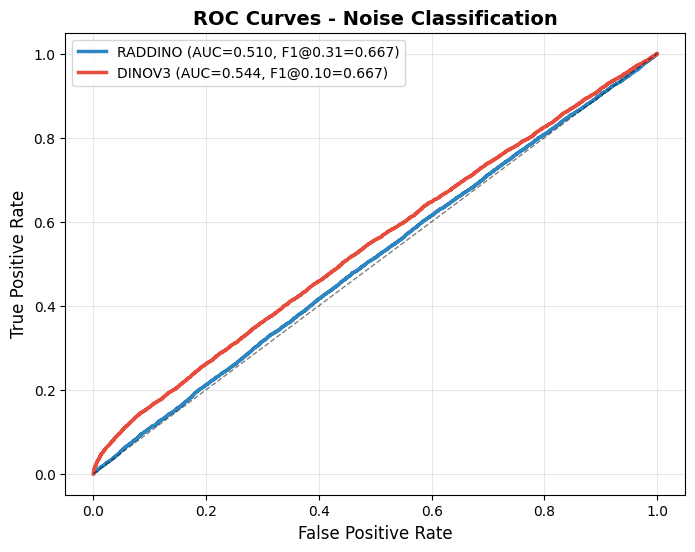


RESULTS SUMMARY TABLE
| Model   | AUC    | F1 Score        |
|:--------|:-------|:----------------|
| RADDINO | 0.5096 | 0.6666 (@0.309) |
| DINOV3  | 0.5439 | 0.6667 (@0.098) |


In [4]:
# Usage
def run_linear_probing():
    # File paths
    BASE_DIR = "/home/rmuthy2/Line-noise/EmbeddingsOutput"
    
    RADDINO_TRAIN = f"{BASE_DIR}/raddino-train-dot8-diagonal.parquet"
    RADDINO_TEST = f"{BASE_DIR}/raddino-test-dot8-diagonal.parquet"
    DINOV3_TRAIN = f"{BASE_DIR}/dinov3-train-dot8-diagonal.parquet"
    DINOV3_TEST = f"{BASE_DIR}/dinov3-test-dot8-diagonal.parquet"
    
    # Run analysis - IMPORTANT: Pass dot_size=4 for dot4 files
    analyzer = LinearProbingAnalyzer()
    results = analyzer.run_analysis(RADDINO_TRAIN, RADDINO_TEST, DINOV3_TRAIN, DINOV3_TEST, dot_size=8)
    
    return analyzer, results

if __name__ == "__main__":
    analyzer, results = run_linear_probing()